In [1]:
import re
import sys
from time import time, sleep
from pprint import pprint
from functools import partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt

FILENAME = "main.cpp"

In [2]:
!cp ../answer/main.cpp ./{FILENAME}

In [3]:
#!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME}.out
!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -o {FILENAME}.out

main.cpp:49: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
   49 | #pragma clang attribute push (__attribute__((target("arch=skylake"))),apply_to=function)
      | 
main.cpp:1578: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
 1578 | #pragma clang attribute pop
      | 
main.cpp: In function ‘void globals::UpdateValueTable()’:
main.cpp:882:15: warning: unused variable ‘vm’ [-Wunused-variable]
  882 |   const auto& vm = v_modified[idx_RCSEV];
      |               ^~
main.cpp: In function ‘void Solve()’:
main.cpp:1369:54: warning: suggest parentheses around ‘-’ in operand of ‘&’ [-Wparentheses]
 1369 |    r = (unsigned)rng.next() & (1 << hash_table_size) - 1;
      |                               ~~~~~~~~~~~~~~~~~~~~~~~^~~
main.cpp:1447:72: warning: missing initializer for member ‘Solve()::Node::action’ [-Wmissing-field-initializers]
 1447 |   node_buffer.push({ state_buffer[0].score, nullptr, &state_buffer[0] });
      |                                  

In [4]:
# テストケース生成
SEED = 1000
N_TESTCASES = 200

!mkdir in
for i in range(N_TESTCASES):
    filename = f"{i:04d}.txt"
    seed = SEED + i
    !python3 ../A/tester/generator.py {seed} > ./in/{filename}
!ls in

0000.txt  0025.txt  0050.txt  0075.txt	0100.txt  0125.txt  0150.txt  0175.txt
0001.txt  0026.txt  0051.txt  0076.txt	0101.txt  0126.txt  0151.txt  0176.txt
0002.txt  0027.txt  0052.txt  0077.txt	0102.txt  0127.txt  0152.txt  0177.txt
0003.txt  0028.txt  0053.txt  0078.txt	0103.txt  0128.txt  0153.txt  0178.txt
0004.txt  0029.txt  0054.txt  0079.txt	0104.txt  0129.txt  0154.txt  0179.txt
0005.txt  0030.txt  0055.txt  0080.txt	0105.txt  0130.txt  0155.txt  0180.txt
0006.txt  0031.txt  0056.txt  0081.txt	0106.txt  0131.txt  0156.txt  0181.txt
0007.txt  0032.txt  0057.txt  0082.txt	0107.txt  0132.txt  0157.txt  0182.txt
0008.txt  0033.txt  0058.txt  0083.txt	0108.txt  0133.txt  0158.txt  0183.txt
0009.txt  0034.txt  0059.txt  0084.txt	0109.txt  0134.txt  0159.txt  0184.txt
0010.txt  0035.txt  0060.txt  0085.txt	0110.txt  0135.txt  0160.txt  0185.txt
0011.txt  0036.txt  0061.txt  0086.txt	0111.txt  0136.txt  0161.txt  0186.txt
0012.txt  0037.txt  0062.txt  0087.txt	0112.txt  0137.txt  0162.

In [6]:
TESTCASE_DIRECTORY = "./in/"
TESTCASES = [f"{i:04d}.txt" for i in range(N_TESTCASES)]

In [7]:
# もとのスコアの確認

scores = []
times = []

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    !./{FILENAME}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase} 2> /dev/null
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

for i in range(200):
    score, t = parallel(i)
    scores.append(score)
    times.append(t)

# with Pool(15) as p:
#     for score, t in p.map(parallel, range(N_TESTCASES)):
#         scores.append(score)
#         times.append(t)

np.mean(scores) * 50 / 1e6, np.std(scores) * 50 / 1e6

mkdir: cannot create directory ‘out’: File exists
0000 time:1.8621 score:4736935
0001 time:1.8625 score:5308167
0002 time:1.8697 score:4795011
0003 time:1.9115 score:4724381
0004 time:1.8524 score:4322547
0005 time:1.8437 score:5222695
0006 time:1.8732 score:5116100
0007 time:1.8490 score:5223317
0008 time:1.8586 score:5190313
0009 time:1.8490 score:4952788
0010 time:1.8548 score:4352613
0011 time:1.8815 score:5414165
0012 time:1.8610 score:4515032
0013 time:1.8686 score:4983540
0014 time:1.8623 score:5226905
0015 time:1.8446 score:5241972
0016 time:1.8587 score:5126032
0017 time:1.8781 score:4568449
0018 time:1.8655 score:5087910
0019 time:1.8728 score:4696477
0020 time:1.8827 score:5034433
0021 time:1.8988 score:4908438
0022 time:1.8687 score:4691666
0023 time:1.8542 score:4621750
0024 time:1.8718 score:5238253
0025 time:1.8750 score:4855467
0026 time:1.8322 score:5202475
0027 time:1.8763 score:5609378
0028 time:1.8534 score:4800607
0029 time:1.8755 score:5246338
0030 time:1.8575 sco

(248.86296749999997, 17.535140313274336)

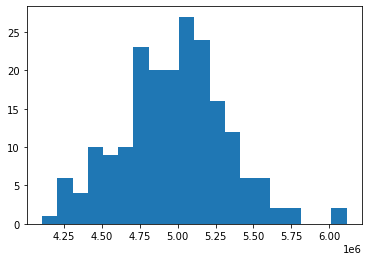

In [8]:
plt.hist(scores, bins=20)
plt.show()

In [9]:
# ここでエラー出力は何かおかしいかもしれない


# パラメータ抽出
with open(FILENAME) as f:
    answer = f.read()


variables_optimize = []

for left, value, right, options in re.findall(r"^([^/\n]*=\s*)(.+?)(\s*;\s*//(?:.*\W)?OPTIMIZE(\W.*))$", answer, re.MULTILINE):
    name = left.replace("=", "").strip().split()[-1]
    
    searched = re.search(r".*\[(?P<min>.*),(?P<max>.*)\].*", options)
    if searched:
        min_value = max_value = None
        try:
            min_value = eval(searched.group("min"))
            max_value = eval(searched.group("max"))
            assert min_value <= max_value
        except Exception as e:
            print(f"searched={searched}", file=sys.stderr)
            print(e, file=sys.stderr)
            continue
        log = "LOG" in options  # 雑、直したほうが良い
        if type(min_value) != type(max_value):
            print(f"searched={searched}", file=sys.stderr)
            print("types not matched", file=sys.stderr)
            continue
        if isinstance(min_value, int):
            method = "suggest_int"
        elif isinstance(min_value, float):
            method = "suggest_float"
        else:
            print(f"searched={searched}", file=sys.stderr)
            print(f"unknown type ({type(min_value)})", file=sys.stderr)
            continue
        variables_optimize.append({
            "name": name,
            "method": method,
            "min": min_value,
            "max": max_value,
            "log": log,
            "left": left,
            "right": right,
        })
    elif searched := re.search(r".*\{(?P<choices>.*?)\}.*", options):
        choices = list(map(lambda x: x.strip(), searched.group("choices").split(",")))
        variables_optimize.append({
            "name": name,
            "method": "suggest_categorical",
            "choices": choices,
            "left": left,
            "right": right,
        })
    else:
        print(f"searched={searched}", file=sys.stderr)
        print(f"pattern was matched but options are incorrect.", file=sys.stderr)

print(len(variables_optimize), "variables were found.")
if globals().get("pd"):
    display(pd.DataFrame(variables_optimize))
else:
    pprint(variables_optimize)

9 variables were found.


,name,method,min,max,log,left,right,choices
0,hash_table_size,suggest_int,9.000,18.000,False,constexpr int hash_table_size =,"; // OPTIMIZE [9, 18]",NaN
1,K_START,suggest_float,0.040,0.200,True,constexpr double K_START =,"; // OPTIMIZE [0.04, 0.2] LOG",NaN
2,K_END,suggest_float,0.030,0.100,True,constexpr double K_END =,"; // OPTIMIZE [0.03, 0.1] LOG",NaN
3,K_H,suggest_float,0.001,0.999,False,constexpr double K_H =,"; // OPTIMIZE [0.001, 0.999]",NaN
4,PURCHASE_TURN_LIMIT,suggest_int,790.000,870.000,False,constexpr short PURCHASE_TURN_LIMIT =,"; // OPTIMIZE [790, 870]",NaN
5,ROUGH_HASH,suggest_categorical,NaN,NaN,NaN,constexpr int ROUGH_HASH =,"; // OPTIMIZE {0, 0b00000001, 0b00010001,...","[0, 0b00000001, 0b00010001, 0b00010011, 0b0011..."
6,TARGET_BEAM_WIDTH_INCREASE_RATE,suggest_float,0.250,4.000,True,constexpr double TARGET_BEAM_WIDTH_INCREASE_RA...,"; // OPTIMIZE [0.25, 4.0] LOG",NaN
7,TARGET_BEAM_WIDTH_HALF_PROGRES_RATE,suggest_float,0.020,0.980,False,constexpr double TARGET_BEAM_WIDTH_HALF_PROGRE...,"; // OPTIMIZE [0.02, 0.98]",NaN
8,MAX_BEAM_WIDTH,suggest_int,400.000,4000.000,True,constexpr auto MAX_BEAM_WIDTH =,"; // OPTIMIZE [400, 400...",NaN


In [10]:
def escape(string):  # 正規表現の中でそのまま使いたい文字列をエスケープ
    res = !echo '{string}' | sed -e 's/[]\/$*.^[]/\\&/g'
    return res[0]

def escape_sed(string):  # sed の置換後の文字列用のエスケープ
    res = !echo '{string}' | sed -e 's/[\/&]/\\&/g'
    return res[0]


def objective_with_index(trial, n_internal_parallel):
    index_parallel = trial.number % 12  # これ変数にする
    print(f"{index_parallel=}")
    
    parameters_changed_filename = f"{index_parallel}_{FILENAME}"
    #directory_input = "./in"  # "/" をつけない  # 中のすべてのファイルに対して実行される
    
    !mkdir {index_parallel}_out 2> /dev/null
    !mkdir {index_parallel}_score 2> /dev/null
    !rm {index_parallel}_out/*
    !rm {index_parallel}_score/*
    
    # ファイル作成
    !cp {FILENAME} {parameters_changed_filename}
    sed_options = [f"-i {parameters_changed_filename}"]
    for variable in variables_optimize:
        if variable["method"] == "suggest_categorical":
            val =  trial.suggest_categorical(variable["name"], variable["choices"])
        else:
            val = getattr(trial, variable["method"])(variable["name"], variable["min"], variable["max"], log=variable["log"])
        left = variable["left"]
        right = variable["right"]
        sed_options.append(f"""-e 's/^{escape(left)}.*{escape(right)}$/{escape_sed(left)}{val}{escape_sed(right)}/'""")
    command_sed = f"sed {' '.join(sed_options)}"
    print(command_sed)
    !{command_sed}
    
    # コンパイル
    command_compile = f"g++ {parameters_changed_filename} -std=gnu++17 -O2 -DONLINE_JUDGE -o {parameters_changed_filename}.out 2> /dev/null"
    print(command_compile)
    !{command_compile}
    
    # 実行・採点コマンド (@ はファイル名)
    command_exec = (
        f"./{parameters_changed_filename}.out < {TESTCASE_DIRECTORY}@ >./{index_parallel}_out/@ 2> /dev/null;"
        f"python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}@ ./{index_parallel}_out/@ > ./{index_parallel}_score/@"
        
        #f"cargo run --release --manifest-path ../tools/Cargo.toml --bin tester {directory_input}/@ $(pwd)/{parameters_changed_filename}.out 2>&1 | grep Score | sed -E s/[^0-9]+// > ./{index_parallel}_score/@;"
        
        #f"./{parameters_changed_filename}.out < {directory_input}/@ > ./{index_parallel}_out/@;"
        #f"cargo run --release --manifest-path ./tools/Cargo.toml --bin vis {directory_input}/@ ./{index_parallel}_out/@ 2> /dev/null > ./{index_parallel}_score/@;"
    )
    
    # 並列実行 (sed はパスのディレクトリ部分を消してファイル名にしてる)
    !find {TESTCASE_DIRECTORY}/* | sed 's!^.*/!!' | xargs -I@ -P {n_internal_parallel} sh -c '{command_exec}'
    
    # 集計
    file_paths = !find ./{index_parallel}_score/*
    sum_score = 0
    for file_path in file_paths:  
        with open(file_path) as f:
            sum_score += int(f.read().split(":")[-1])
    return sum_score

In [11]:
storage_path = f"study.db"
storage = f"sqlite:///{storage_path}"
study_name = "study"
study = optuna.create_study(storage=storage, load_if_exists=True, study_name=study_name, direction="maximize")

def callback(study, trial):
    try:
        if study.best_value == trial.value:
            print(f"Updated! {study.best_value}")
            index_parallel = trial.number % 12
            parameters_changed_filename = f"{index_parallel}_{FILENAME}"
            !cp {parameters_changed_filename} 00000optimized.cpp
        print("callback ok")
    except:
        print(":(")

objective = partial(objective_with_index, n_internal_parallel=4)
study.optimize(objective, n_trials=3000, timeout=86400, n_jobs=4, callbacks=[callback])

[I 2021-09-10 20:11:31,600] A new study created in RDB with name: study


index_parallel=2
index_parallel=0
index_parallel=1
index_parallel=3


/home/nagis/anaconda3/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


rm: cannot remove '2_out/*': No such file or directory
rm: cannot remove '0_out/*': No such file or directory
rm: cannot remove '1_out/*': No such file or directory
rm: cannot remove '3_out/*': No such file or directory
rm: cannot remove '2_score/*': No such file or directory
rm: cannot remove '0_score/*': No such file or directory
rm: cannot remove '1_score/*': No such file or directory
rm: cannot remove '3_score/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 15;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11623793978641761;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.09530132564416496;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr

[I 2021-09-10 20:13:17,096] Trial 2 finished with value: 956782675.0 and parameters: {'hash_table_size': 11, 'K_START': 0.08170890268421763, 'K_END': 0.0344503818029372, 'K_H': 0.9461840342358488, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.81169170038911, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7571842978991685, 'MAX_BEAM_WIDTH': 1220}. Best is trial 2 with value: 956782675.0.


Updated! 956782675.0
callback ok
index_parallel=4
rm: cannot remove '4_out/*': No such file or directory
rm: cannot remove '4_score/*': No such file or directory


[I 2021-09-10 20:13:17,815] Trial 1 finished with value: 943213758.0 and parameters: {'hash_table_size': 13, 'K_START': 0.05906596831086389, 'K_END': 0.08704210165876108, 'K_H': 0.6004215601717493, 'PURCHASE_TURN_LIMIT': 870, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2275145476518468, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9521587864335158, 'MAX_BEAM_WIDTH': 824}. Best is trial 2 with value: 956782675.0.


callback ok
index_parallel=5
rm: cannot remove '5_out/*': No such file or directory
rm: cannot remove '5_score/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 15;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08283745580979833;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07060978162231495;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6817067528794336;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:13:19,601] Trial 0 finished with value: 254214097.0 and parameters: {'hash_table_size': 15, 'K_START': 0.11623793978641761, 'K_END': 0.09530132564416496, 'K_H': 0.5210331348255494, 'PURCHASE_TURN_LIMIT': 793, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.231154813604221, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49088673301637586, 'MAX_BEAM_WIDTH': 522}. Best is trial 2 with value: 956782675.0.


callback ok
index_parallel=6
rm: cannot remove '6_out/*': No such file or directory
rm: cannot remove '6_score/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 14;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1901601657714578;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07013078341880123;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.42949409484588347;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 864;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:13:22,849] Trial 3 finished with value: 955781437.0 and parameters: {'hash_table_size': 16, 'K_START': 0.08722334985623649, 'K_END': 0.06964439746743907, 'K_H': 0.6625567152559877, 'PURCHASE_TURN_LIMIT': 809, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8308470052292909, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47224287897718237, 'MAX_BEAM_WIDTH': 821}. Best is trial 2 with value: 956782675.0.


callback ok
index_parallel=7
rm: cannot remove '7_out/*': No such file or directory
rm: cannot remove '7_score/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 15;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19240226470852143;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.061663501498268866;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.35027767388964837;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 859;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 20:15:00,597] Trial 5 finished with value: 258505475.0 and parameters: {'hash_table_size': 10, 'K_START': 0.169433537757161, 'K_END': 0.05119036575081291, 'K_H': 0.6998326400117901, 'PURCHASE_TURN_LIMIT': 823, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5787109751913897, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.2377033926829104, 'MAX_BEAM_WIDTH': 3211}. Best is trial 2 with value: 956782675.0.


callback ok
index_parallel=8
rm: cannot remove '8_out/*': No such file or directory
rm: cannot remove '8_score/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11284205016656633;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06923989013288646;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.1753074738829838;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 796;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:15:02,476] Trial 4 finished with value: 964639720.0 and parameters: {'hash_table_size': 15, 'K_START': 0.08283745580979833, 'K_END': 0.07060978162231495, 'K_H': 0.6817067528794336, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6965190007580268, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9762559772208137, 'MAX_BEAM_WIDTH': 504}. Best is trial 4 with value: 964639720.0.


Updated! 964639720.0
callback ok
index_parallel=9
rm: cannot remove '9_out/*': No such file or directory
rm: cannot remove '9_score/*': No such file or directory


[I 2021-09-10 20:15:03,359] Trial 6 finished with value: 141990761.0 and parameters: {'hash_table_size': 14, 'K_START': 0.1901601657714578, 'K_END': 0.07013078341880123, 'K_H': 0.42949409484588347, 'PURCHASE_TURN_LIMIT': 864, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.2819033222948164, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.28354197792402275, 'MAX_BEAM_WIDTH': 2635}. Best is trial 4 with value: 964639720.0.


callback ok
index_parallel=10
rm: cannot remove '10_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 18;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1055720324355952;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06607865732647253;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8257014865904063;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;     

[I 2021-09-10 20:15:04,694] Trial 7 finished with value: 152785018.0 and parameters: {'hash_table_size': 15, 'K_START': 0.19240226470852143, 'K_END': 0.061663501498268866, 'K_H': 0.35027767388964837, 'PURCHASE_TURN_LIMIT': 859, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5881768457521644, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9047514166710101, 'MAX_BEAM_WIDTH': 2844}. Best is trial 4 with value: 964639720.0.


callback ok
index_parallel=11
rm: cannot remove '11_out/*': No such file or directory
rm: cannot remove '11_score/*': No such file or directory
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 14;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07712997213843827;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03948751792996909;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7331085190671398;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 809;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001,

[I 2021-09-10 20:16:43,955] Trial 8 finished with value: 252311722.0 and parameters: {'hash_table_size': 12, 'K_START': 0.11284205016656633, 'K_END': 0.06923989013288646, 'K_H': 0.1753074738829838, 'PURCHASE_TURN_LIMIT': 796, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.263697593394773, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5591774919751157, 'MAX_BEAM_WIDTH': 3132}. Best is trial 4 with value: 964639720.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07846381885682185;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05425748921357216;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2970396399301707;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 791;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 20:16:45,868] Trial 10 finished with value: 239299024.0 and parameters: {'hash_table_size': 18, 'K_START': 0.12477021673553529, 'K_END': 0.05669374284700967, 'K_H': 0.28266260807751015, 'PURCHASE_TURN_LIMIT': 806, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.46371785085551803, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.02700522742763905, 'MAX_BEAM_WIDTH': 758}. Best is trial 4 with value: 964639720.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 18;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040021435234563134;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04276606789927563;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.936525159800853;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 20:16:47,536] Trial 9 finished with value: 981619008.0 and parameters: {'hash_table_size': 18, 'K_START': 0.1055720324355952, 'K_END': 0.06607865732647253, 'K_H': 0.8257014865904063, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2967987756408967, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7082372644473831, 'MAX_BEAM_WIDTH': 754}. Best is trial 9 with value: 981619008.0.


Updated! 981619008.0
callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 18;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06056370332412028;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04589312448989164;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9069044569446085;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000

[I 2021-09-10 20:16:49,835] Trial 11 finished with value: 963605888.0 and parameters: {'hash_table_size': 14, 'K_START': 0.07712997213843827, 'K_END': 0.03948751792996909, 'K_H': 0.7331085190671398, 'PURCHASE_TURN_LIMIT': 809, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5893637518423958, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9764262811639871, 'MAX_BEAM_WIDTH': 629}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 18;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04098875587771774;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04777786205261183;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9258965334302452;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 20:18:23,204] Trial 12 finished with value: 948586952.0 and parameters: {'hash_table_size': 9, 'K_START': 0.07846381885682185, 'K_END': 0.05425748921357216, 'K_H': 0.2970396399301707, 'PURCHASE_TURN_LIMIT': 791, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.8192603203992364, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.0375978213423441, 'MAX_BEAM_WIDTH': 1547}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 18;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04207915993144654;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.081471029193115;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9188205056680112;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 20:18:32,816] Trial 14 finished with value: 977137257.0 and parameters: {'hash_table_size': 18, 'K_START': 0.06056370332412028, 'K_END': 0.04589312448989164, 'K_H': 0.9069044569446085, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.266727752528863, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7614937635818595, 'MAX_BEAM_WIDTH': 429}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=5


[I 2021-09-10 20:18:33,701] Trial 13 finished with value: 964461570.0 and parameters: {'hash_table_size': 18, 'K_START': 0.040021435234563134, 'K_END': 0.04276606789927563, 'K_H': 0.936525159800853, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.3082491188930927, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6963116136812566, 'MAX_BEAM_WIDTH': 428}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=6
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 18;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040055682989384105;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04652198935621234;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.819561831855643;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 20:18:35,628] Trial 15 finished with value: 977676856.0 and parameters: {'hash_table_size': 18, 'K_START': 0.04098875587771774, 'K_END': 0.04777786205261183, 'K_H': 0.9258965334302452, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.120469905349118, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7422202178892894, 'MAX_BEAM_WIDTH': 493}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 17;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04273259760562117;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03188772260279166;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8242877486867102;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 20:20:09,349] Trial 16 finished with value: 973534737.0 and parameters: {'hash_table_size': 18, 'K_START': 0.04207915993144654, 'K_END': 0.081471029193115, 'K_H': 0.9188205056680112, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.951440684764262, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7464918539509284, 'MAX_BEAM_WIDTH': 400}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 17;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05414677733052715;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.031639409501831;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7993959151862273;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 20:20:18,707] Trial 17 finished with value: 972743267.0 and parameters: {'hash_table_size': 18, 'K_START': 0.040055682989384105, 'K_END': 0.04652198935621234, 'K_H': 0.819561831855643, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.2405871679121863, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7329609650812045, 'MAX_BEAM_WIDTH': 1143}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=9


[I 2021-09-10 20:20:19,765] Trial 18 finished with value: 971160394.0 and parameters: {'hash_table_size': 17, 'K_START': 0.05688662760250131, 'K_END': 0.04603212982330597, 'K_H': 0.8500278540955083, 'PURCHASE_TURN_LIMIT': 851, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.1822316887992401, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7502053374112841, 'MAX_BEAM_WIDTH': 1187}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=10
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 16;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14250299859141954;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03099098306472074;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8128855729101521;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 823;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 20:20:21,603] Trial 19 finished with value: 959202854.0 and parameters: {'hash_table_size': 17, 'K_START': 0.04273259760562117, 'K_END': 0.03188772260279166, 'K_H': 0.8242877486867102, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5365095558150843, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6294332785082198, 'MAX_BEAM_WIDTH': 1118}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 16;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14355411238750107;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06102034360214521;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.988234699453008;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 853;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 20:21:54,985] Trial 20 finished with value: 957938434.0 and parameters: {'hash_table_size': 17, 'K_START': 0.05414677733052715, 'K_END': 0.031639409501831, 'K_H': 0.7993959151862273, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4417619581019996, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6115929689550416, 'MAX_BEAM_WIDTH': 1154}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 16;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06808355991763283;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.038380632569897315;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9924732580519212;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 849;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:22:04,199] Trial 21 finished with value: 962363461.0 and parameters: {'hash_table_size': 16, 'K_START': 0.14250299859141954, 'K_END': 0.03099098306472074, 'K_H': 0.8128855729101521, 'PURCHASE_TURN_LIMIT': 823, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.570628274309254, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6110397670287244, 'MAX_BEAM_WIDTH': 1789}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=1


[I 2021-09-10 20:22:04,980] Trial 22 finished with value: 958112824.0 and parameters: {'hash_table_size': 16, 'K_START': 0.14628334364273246, 'K_END': 0.030189663006184315, 'K_H': 0.8065388522586969, 'PURCHASE_TURN_LIMIT': 822, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.369027874412849, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5953471411189395, 'MAX_BEAM_WIDTH': 1791}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=2
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 16;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06680097370836413;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03798708942548775;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9802221765790267;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 853;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 20:22:07,549] Trial 23 finished with value: 974584109.0 and parameters: {'hash_table_size': 16, 'K_START': 0.14355411238750107, 'K_END': 0.06102034360214521, 'K_H': 0.988234699453008, 'PURCHASE_TURN_LIMIT': 853, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5218078947301152, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.85063488591464, 'MAX_BEAM_WIDTH': 622}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 17;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06747830668904806;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03943710175363089;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8892576164221073;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 20:23:41,609] Trial 24 finished with value: 970550202.0 and parameters: {'hash_table_size': 16, 'K_START': 0.06808355991763283, 'K_END': 0.038380632569897315, 'K_H': 0.9924732580519212, 'PURCHASE_TURN_LIMIT': 849, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.6456347946466061, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8402292537302536, 'MAX_BEAM_WIDTH': 603}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 17;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10191330261266274;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04742905212064132;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.566035685460078;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 20:23:50,451] Trial 25 finished with value: 964549469.0 and parameters: {'hash_table_size': 16, 'K_START': 0.06680097370836413, 'K_END': 0.03798708942548775, 'K_H': 0.9802221765790267, 'PURCHASE_TURN_LIMIT': 853, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.5599755860420828, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8341983994243022, 'MAX_BEAM_WIDTH': 572}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=5


[I 2021-09-10 20:23:50,943] Trial 26 finished with value: 966755926.0 and parameters: {'hash_table_size': 17, 'K_START': 0.05109946299722831, 'K_END': 0.03796563075682222, 'K_H': 0.9172117042733652, 'PURCHASE_TURN_LIMIT': 852, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.601131883331737, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8659683773739124, 'MAX_BEAM_WIDTH': 626}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=6
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 18;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1003189821799997;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04827717499022184;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.017232126632351685;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:23:53,216] Trial 27 finished with value: 973302369.0 and parameters: {'hash_table_size': 17, 'K_START': 0.06747830668904806, 'K_END': 0.03943710175363089, 'K_H': 0.8892576164221073, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.5308684830854962, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8373429480964755, 'MAX_BEAM_WIDTH': 512}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 18;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09577905918657932;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.049744310842670204;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5808856619598144;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:25:27,129] Trial 28 finished with value: 977405096.0 and parameters: {'hash_table_size': 17, 'K_START': 0.10191330261266274, 'K_END': 0.04742905212064132, 'K_H': 0.566035685460078, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8906211629835982, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3904137579686583, 'MAX_BEAM_WIDTH': 481}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 18;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09788052025378771;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0506302065057131;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5580670185800138;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 20:25:33,013] Trial 29 finished with value: 294841554.0 and parameters: {'hash_table_size': 18, 'K_START': 0.1003189821799997, 'K_END': 0.04827717499022184, 'K_H': 0.017232126632351685, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9638171838633115, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.39187144085084447, 'MAX_BEAM_WIDTH': 930}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 13;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10677719638612419;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06190655555523338;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5716471300508452;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 817;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 20:25:43,349] Trial 30 finished with value: 973680011.0 and parameters: {'hash_table_size': 18, 'K_START': 0.04598122572751351, 'K_END': 0.04905275827745044, 'K_H': 0.5694964232565883, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9091212665053597, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4635135812687651, 'MAX_BEAM_WIDTH': 739}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 17;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0954740170320308;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04477387331672394;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.45360912231842787;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 20:25:46,495] Trial 31 finished with value: 973467968.0 and parameters: {'hash_table_size': 18, 'K_START': 0.09577905918657932, 'K_END': 0.049744310842670204, 'K_H': 0.5808856619598144, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.966441829437958, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.418802053523401, 'MAX_BEAM_WIDTH': 759}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 17;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1124766262365445;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04323618099968708;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4895656371250671;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:27:19,933] Trial 32 finished with value: 973329137.0 and parameters: {'hash_table_size': 18, 'K_START': 0.09788052025378771, 'K_END': 0.0506302065057131, 'K_H': 0.5580670185800138, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9723682786991531, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46039155610625854, 'MAX_BEAM_WIDTH': 903}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 17;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1124872098928998;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04381912910443331;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7474039022360535;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 20:27:24,836] Trial 33 finished with value: 891704063.0 and parameters: {'hash_table_size': 13, 'K_START': 0.10677719638612419, 'K_END': 0.06190655555523338, 'K_H': 0.5716471300508452, 'PURCHASE_TURN_LIMIT': 817, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.0490257466034543, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4723081370903081, 'MAX_BEAM_WIDTH': 721}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 17;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04887662964337457;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04402079773034793;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.47945341872196795;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 848;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:27:28,261] Trial 34 finished with value: 973934135.0 and parameters: {'hash_table_size': 17, 'K_START': 0.0954740170320308, 'K_END': 0.04477387331672394, 'K_H': 0.45360912231842787, 'PURCHASE_TURN_LIMIT': 847, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.1364491753832169, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3670732514559469, 'MAX_BEAM_WIDTH': 467}. Best is trial 9 with value: 981619008.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 17;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12066719936088648;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05586338182730934;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7462807201155287;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 858;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 20:27:33,257] Trial 35 finished with value: 982959459.0 and parameters: {'hash_table_size': 17, 'K_START': 0.1124766262365445, 'K_END': 0.04323618099968708, 'K_H': 0.4895656371250671, 'PURCHASE_TURN_LIMIT': 847, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.1812932664646276, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.678735234086595, 'MAX_BEAM_WIDTH': 442}. Best is trial 35 with value: 982959459.0.


Updated! 982959459.0
callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 15;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12530538668069358;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.094799673085965;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7484481705884259;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 859;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b0000000

[I 2021-09-10 20:29:05,393] Trial 36 finished with value: 975653476.0 and parameters: {'hash_table_size': 17, 'K_START': 0.1124872098928998, 'K_END': 0.04381912910443331, 'K_H': 0.7474039022360535, 'PURCHASE_TURN_LIMIT': 845, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.2230671956998227, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.33335015406316115, 'MAX_BEAM_WIDTH': 462}. Best is trial 35 with value: 982959459.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 15;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12641316658073495;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.09759517362865762;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6280916558243631;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 858;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 20:29:10,213] Trial 37 finished with value: 973207002.0 and parameters: {'hash_table_size': 17, 'K_START': 0.04887662964337457, 'K_END': 0.04402079773034793, 'K_H': 0.47945341872196795, 'PURCHASE_TURN_LIMIT': 848, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.2720222414099436, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6797733389604798, 'MAX_BEAM_WIDTH': 478}. Best is trial 35 with value: 982959459.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 15;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12995999977369405;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05568155621522097;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6429312798131004;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 858;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 20:29:15,751] Trial 38 finished with value: 968528791.0 and parameters: {'hash_table_size': 17, 'K_START': 0.12066719936088648, 'K_END': 0.05586338182730934, 'K_H': 0.7462807201155287, 'PURCHASE_TURN_LIMIT': 858, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7676998015694264, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6896482614686305, 'MAX_BEAM_WIDTH': 440}. Best is trial 35 with value: 982959459.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 15;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1673675368173104;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.09692348703149366;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6512247631903356;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 868;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 20:29:17,068] Trial 39 finished with value: 233709196.0 and parameters: {'hash_table_size': 15, 'K_START': 0.12530538668069358, 'K_END': 0.094799673085965, 'K_H': 0.7484481705884259, 'PURCHASE_TURN_LIMIT': 859, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7887385203189551, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6867179795684157, 'MAX_BEAM_WIDTH': 498}. Best is trial 35 with value: 982959459.0.


callback ok
index_parallel=7
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 15;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08708477143184819;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07740515311583446;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6490153021854368;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 869;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr in

[I 2021-09-10 20:30:49,175] Trial 40 finished with value: 206750971.0 and parameters: {'hash_table_size': 15, 'K_START': 0.12641316658073495, 'K_END': 0.09759517362865762, 'K_H': 0.6280916558243631, 'PURCHASE_TURN_LIMIT': 858, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7458218247814404, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6812033235148311, 'MAX_BEAM_WIDTH': 557}. Best is trial 35 with value: 982959459.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08466308151239348;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.041166095212313535;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3987174214062203;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:30:56,284] Trial 41 finished with value: 550653103.0 and parameters: {'hash_table_size': 15, 'K_START': 0.12995999977369405, 'K_END': 0.05568155621522097, 'K_H': 0.6429312798131004, 'PURCHASE_TURN_LIMIT': 858, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.782025300403566, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.539868630349196, 'MAX_BEAM_WIDTH': 527}. Best is trial 35 with value: 982959459.0.


callback ok
index_parallel=9


[I 2021-09-10 20:30:56,571] Trial 42 finished with value: 162702610.0 and parameters: {'hash_table_size': 15, 'K_START': 0.1673675368173104, 'K_END': 0.09692348703149366, 'K_H': 0.6512247631903356, 'PURCHASE_TURN_LIMIT': 868, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.9835794475055055, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5220976082400095, 'MAX_BEAM_WIDTH': 546}. Best is trial 35 with value: 982959459.0.


callback ok
index_parallel=10
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08681111534651698;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.041641005751788744;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5171622476084761;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 20:31:05,733] Trial 43 finished with value: 885816498.0 and parameters: {'hash_table_size': 15, 'K_START': 0.08708477143184819, 'K_END': 0.07740515311583446, 'K_H': 0.6490153021854368, 'PURCHASE_TURN_LIMIT': 869, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.44071540726065717, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5249851574360304, 'MAX_BEAM_WIDTH': 571}. Best is trial 35 with value: 982959459.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06303380031971298;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04160213282402501;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4081325817641528;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 20:32:35,273] Trial 44 finished with value: 987540248.0 and parameters: {'hash_table_size': 11, 'K_START': 0.08466308151239348, 'K_END': 0.041166095212313535, 'K_H': 0.3987174214062203, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.9852169051792259, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5315341268045082, 'MAX_BEAM_WIDTH': 537}. Best is trial 44 with value: 987540248.0.


Updated! 987540248.0
callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1065979421130133;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.041342135212813796;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3207207148151855;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00

[I 2021-09-10 20:32:41,571] Trial 45 finished with value: 990474764.0 and parameters: {'hash_table_size': 11, 'K_START': 0.08681111534651698, 'K_END': 0.041641005751788744, 'K_H': 0.5171622476084761, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.4183746561495756, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7841154424180038, 'MAX_BEAM_WIDTH': 402}. Best is trial 45 with value: 990474764.0.


Updated! 990474764.0
callback ok
index_parallel=1


[I 2021-09-10 20:32:42,753] Trial 46 finished with value: 987725089.0 and parameters: {'hash_table_size': 11, 'K_START': 0.0872802744764536, 'K_END': 0.04233216570270972, 'K_H': 0.40240667408200825, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.3989824939688809, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7793705924280915, 'MAX_BEAM_WIDTH': 414}. Best is trial 45 with value: 990474764.0.


callback ok
index_parallel=2
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07300753148474884;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03504998679669198;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.40693257929489934;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 20:32:51,762] Trial 47 finished with value: 991108948.0 and parameters: {'hash_table_size': 12, 'K_START': 0.06303380031971298, 'K_END': 0.04160213282402501, 'K_H': 0.4081325817641528, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9160489310507267, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7916390333529904, 'MAX_BEAM_WIDTH': 400}. Best is trial 47 with value: 991108948.0.


Updated! 991108948.0
callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07781317003428694;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03557156683267246;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3749919175041622;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00

[I 2021-09-10 20:34:14,835] Trial 48 finished with value: 869200582.0 and parameters: {'hash_table_size': 11, 'K_START': 0.1065979421130133, 'K_END': 0.041342135212813796, 'K_H': 0.3207207148151855, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.933003030709072, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.1906032211566176, 'MAX_BEAM_WIDTH': 658}. Best is trial 47 with value: 991108948.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07457332214922707;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03566943436546567;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.395173121742946;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 20:34:27,158] Trial 49 finished with value: 989325447.0 and parameters: {'hash_table_size': 11, 'K_START': 0.07300753148474884, 'K_END': 0.03504998679669198, 'K_H': 0.40693257929489934, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.932354053094989, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8043888627107204, 'MAX_BEAM_WIDTH': 405}. Best is trial 47 with value: 991108948.0.


callback ok
index_parallel=5


[I 2021-09-10 20:34:27,973] Trial 50 finished with value: 986351479.0 and parameters: {'hash_table_size': 11, 'K_START': 0.07496280913320764, 'K_END': 0.034881594777338536, 'K_H': 0.3717052592075787, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8766363667133463, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9209601208912801, 'MAX_BEAM_WIDTH': 406}. Best is trial 47 with value: 991108948.0.


callback ok
index_parallel=6
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07839352961918125;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.034985257232591015;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3758052932350001;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 20:34:37,794] Trial 51 finished with value: 987513602.0 and parameters: {'hash_table_size': 11, 'K_START': 0.07781317003428694, 'K_END': 0.03557156683267246, 'K_H': 0.3749919175041622, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.102192817076529, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9245804836826078, 'MAX_BEAM_WIDTH': 415}. Best is trial 47 with value: 991108948.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07362846901595987;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03545904215533711;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.39761194211520895;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 20:36:00,723] Trial 52 finished with value: 989418096.0 and parameters: {'hash_table_size': 11, 'K_START': 0.07457332214922707, 'K_END': 0.03566943436546567, 'K_H': 0.395173121742946, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.0224086372329326, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7960240380520033, 'MAX_BEAM_WIDTH': 445}. Best is trial 47 with value: 991108948.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0837626846376768;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03346515276502302;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.24143041570694995;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 20:36:11,982] Trial 53 finished with value: 987306300.0 and parameters: {'hash_table_size': 11, 'K_START': 0.07839352961918125, 'K_END': 0.034985257232591015, 'K_H': 0.3758052932350001, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0068662078054786, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9364724092277347, 'MAX_BEAM_WIDTH': 402}. Best is trial 47 with value: 991108948.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07249922509553541;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.033130788052615365;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.24782592343135748;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 20:36:13,646] Trial 54 finished with value: 988410234.0 and parameters: {'hash_table_size': 11, 'K_START': 0.07213807782268726, 'K_END': 0.03411699350476313, 'K_H': 0.38448718089273015, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0131768460468296, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9249797937596149, 'MAX_BEAM_WIDTH': 400}. Best is trial 47 with value: 991108948.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07194679520764832;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03278492786528839;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.43795672984806777;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 826;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 20:36:23,225] Trial 55 finished with value: 986851180.0 and parameters: {'hash_table_size': 12, 'K_START': 0.07362846901595987, 'K_END': 0.03545904215533711, 'K_H': 0.39761194211520895, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1224147226816723, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7941595519189598, 'MAX_BEAM_WIDTH': 400}. Best is trial 47 with value: 991108948.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06282512182128706;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.032380088553342984;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2148100511275365;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 20:37:46,316] Trial 56 finished with value: 990742092.0 and parameters: {'hash_table_size': 10, 'K_START': 0.0837626846376768, 'K_END': 0.03346515276502302, 'K_H': 0.24143041570694995, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.9761832508951915, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8056711606055136, 'MAX_BEAM_WIDTH': 408}. Best is trial 47 with value: 991108948.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.061808759017377195;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03287420936055406;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.23467294206949313;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 819;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 20:37:57,353] Trial 57 finished with value: 991179196.0 and parameters: {'hash_table_size': 10, 'K_START': 0.07249922509553541, 'K_END': 0.033130788052615365, 'K_H': 0.24782592343135748, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.8896055722710405, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7709905105045545, 'MAX_BEAM_WIDTH': 455}. Best is trial 57 with value: 991179196.0.


Updated! 991179196.0
callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06200908113947779;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03250697780218136;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.21737696239473125;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b0

[I 2021-09-10 20:37:59,102] Trial 58 finished with value: 982862858.0 and parameters: {'hash_table_size': 10, 'K_START': 0.07194679520764832, 'K_END': 0.03278492786528839, 'K_H': 0.43795672984806777, 'PURCHASE_TURN_LIMIT': 826, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.450156298723523, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7936912033131222, 'MAX_BEAM_WIDTH': 446}. Best is trial 57 with value: 991179196.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06061451336169917;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03291589656120836;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.21606430130514043;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 819;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 20:38:08,510] Trial 59 finished with value: 988394160.0 and parameters: {'hash_table_size': 10, 'K_START': 0.06282512182128706, 'K_END': 0.032380088553342984, 'K_H': 0.2148100511275365, 'PURCHASE_TURN_LIMIT': 825, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.629722844004717, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8902216847314091, 'MAX_BEAM_WIDTH': 444}. Best is trial 57 with value: 991179196.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06228103188076437;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.036467395150524023;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2460994286609705;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 821;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 20:39:31,963] Trial 60 finished with value: 986244107.0 and parameters: {'hash_table_size': 10, 'K_START': 0.061808759017377195, 'K_END': 0.03287420936055406, 'K_H': 0.23467294206949313, 'PURCHASE_TURN_LIMIT': 819, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4927900200880564, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8885659704438785, 'MAX_BEAM_WIDTH': 449}. Best is trial 57 with value: 991179196.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08185471861029442;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03645440886243852;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.15838014713981352;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 20:39:42,244] Trial 61 finished with value: 986175126.0 and parameters: {'hash_table_size': 10, 'K_START': 0.06200908113947779, 'K_END': 0.03250697780218136, 'K_H': 0.21737696239473125, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.8082932088565529, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8814162810775039, 'MAX_BEAM_WIDTH': 452}. Best is trial 57 with value: 991179196.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08186374172799078;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03689753846772216;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.1474714532707275;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 20:39:45,403] Trial 62 finished with value: 974681813.0 and parameters: {'hash_table_size': 10, 'K_START': 0.06061451336169917, 'K_END': 0.03291589656120836, 'K_H': 0.21606430130514043, 'PURCHASE_TURN_LIMIT': 819, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.859317457556612, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8905177951857342, 'MAX_BEAM_WIDTH': 3607}. Best is trial 57 with value: 991179196.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07013711662381393;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03664627373967958;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.12452051201857936;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 20:39:55,222] Trial 63 finished with value: 982041152.0 and parameters: {'hash_table_size': 9, 'K_START': 0.06228103188076437, 'K_END': 0.036467395150524023, 'K_H': 0.2460994286609705, 'PURCHASE_TURN_LIMIT': 821, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.8481269845338588, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8111758485413713, 'MAX_BEAM_WIDTH': 3559}. Best is trial 57 with value: 991179196.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0703870466110824;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.036819306846685364;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.15931616667645732;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 814;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 20:41:18,724] Trial 64 finished with value: 990785622.0 and parameters: {'hash_table_size': 9, 'K_START': 0.08185471861029442, 'K_END': 0.03645440886243852, 'K_H': 0.15838014713981352, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.623008058150419, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8048851861867075, 'MAX_BEAM_WIDTH': 2400}. Best is trial 57 with value: 991179196.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09186987049026794;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.037072535073983795;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.15688767215546978;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 20:41:28,610] Trial 65 finished with value: 979403380.0 and parameters: {'hash_table_size': 12, 'K_START': 0.08186374172799078, 'K_END': 0.03689753846772216, 'K_H': 0.1474714532707275, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.720249958375143, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8141001678823327, 'MAX_BEAM_WIDTH': 2247}. Best is trial 57 with value: 991179196.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0920164544571246;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0398563226434364;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.13390675385683393;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 20:41:31,429] Trial 66 finished with value: 986486099.0 and parameters: {'hash_table_size': 12, 'K_START': 0.07013711662381393, 'K_END': 0.03664627373967958, 'K_H': 0.12452051201857936, 'PURCHASE_TURN_LIMIT': 844, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.790890322056775, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9706225811433697, 'MAX_BEAM_WIDTH': 497}. Best is trial 57 with value: 991179196.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09230809041334978;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03975717694998458;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.33338522726435776;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 813;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 20:41:40,659] Trial 67 finished with value: 981887644.0 and parameters: {'hash_table_size': 12, 'K_START': 0.0703870466110824, 'K_END': 0.036819306846685364, 'K_H': 0.15931616667645732, 'PURCHASE_TURN_LIMIT': 814, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6878684150163092, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7348553254321364, 'MAX_BEAM_WIDTH': 500}. Best is trial 57 with value: 991179196.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05507659674612688;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.030158886596628978;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.08829568789613768;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 20:43:05,493] Trial 68 finished with value: 984884562.0 and parameters: {'hash_table_size': 12, 'K_START': 0.09186987049026794, 'K_END': 0.037072535073983795, 'K_H': 0.15688767215546978, 'PURCHASE_TURN_LIMIT': 845, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7041717396746683, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7220129530332852, 'MAX_BEAM_WIDTH': 2398}. Best is trial 57 with value: 991179196.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06555476345495018;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.030224341847748068;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5206115884345768;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 20:43:14,457] Trial 69 finished with value: 987205033.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0920164544571246, 'K_END': 0.0398563226434364, 'K_H': 0.13390675385683393, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2286773341286423, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7129784685621978, 'MAX_BEAM_WIDTH': 1381}. Best is trial 57 with value: 991179196.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05514353374549243;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.030646886818361425;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5219289885431209;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 20:43:16,503] Trial 70 finished with value: 982623206.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09230809041334978, 'K_END': 0.03975717694998458, 'K_H': 0.33338522726435776, 'PURCHASE_TURN_LIMIT': 813, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.222238267407949, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7217552768267993, 'MAX_BEAM_WIDTH': 2698}. Best is trial 57 with value: 991179196.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.056838490700920175;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03401363388200984;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5265449974239658;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 20:43:26,594] Trial 71 finished with value: 992153272.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05507659674612688, 'K_END': 0.030158886596628978, 'K_H': 0.08829568789613768, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.360010887909228, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6492032294774693, 'MAX_BEAM_WIDTH': 1382}. Best is trial 71 with value: 992153272.0.


Updated! 992153272.0
callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08244080617072892;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.030417440164749274;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.08283705850178265;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b

[I 2021-09-10 20:44:51,238] Trial 72 finished with value: 980934745.0 and parameters: {'hash_table_size': 9, 'K_START': 0.06555476345495018, 'K_END': 0.030224341847748068, 'K_H': 0.5206115884345768, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1793825299690814, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6518239523290231, 'MAX_BEAM_WIDTH': 1392}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08248011587406838;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03346347036855015;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.09462584872453231;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 20:45:00,562] Trial 73 finished with value: 976508950.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05514353374549243, 'K_END': 0.030646886818361425, 'K_H': 0.5219289885431209, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3976244279494527, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7685108331824337, 'MAX_BEAM_WIDTH': 676}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08336506234680192;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03403764976001621;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.09168637759719389;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 20:45:01,881] Trial 74 finished with value: 979077357.0 and parameters: {'hash_table_size': 10, 'K_START': 0.056838490700920175, 'K_END': 0.03401363388200984, 'K_H': 0.5265449974239658, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.432120198089411, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7761666452156883, 'MAX_BEAM_WIDTH': 427}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=6
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08166355146765741;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03373941453625239;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.28667784488457343;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr i

[I 2021-09-10 20:45:12,401] Trial 75 finished with value: 986961994.0 and parameters: {'hash_table_size': 10, 'K_START': 0.08244080617072892, 'K_END': 0.030417440164749274, 'K_H': 0.08283705850178265, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4113411310642876, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7730325126566207, 'MAX_BEAM_WIDTH': 1954}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05175286437860439;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03135457448395699;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.27899651311218965;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 800;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 20:46:37,289] Trial 76 finished with value: 989445085.0 and parameters: {'hash_table_size': 10, 'K_START': 0.08248011587406838, 'K_END': 0.03346347036855015, 'K_H': 0.09462584872453231, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.414265976059596, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7518454482283434, 'MAX_BEAM_WIDTH': 1998}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05137688531046906;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.033826093505327254;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.063732333814369;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 796;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 20:46:46,346] Trial 77 finished with value: 986905963.0 and parameters: {'hash_table_size': 10, 'K_START': 0.08336506234680192, 'K_END': 0.03403764976001621, 'K_H': 0.09168637759719389, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.4225203250932916, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8550397170816842, 'MAX_BEAM_WIDTH': 1859}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=9


[I 2021-09-10 20:46:47,160] Trial 78 finished with value: 983408774.0 and parameters: {'hash_table_size': 10, 'K_START': 0.08166355146765741, 'K_END': 0.03373941453625239, 'K_H': 0.28667784488457343, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.9237652074300255, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8201265499707759, 'MAX_BEAM_WIDTH': 1914}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=10
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0763042519516752;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03150656104310392;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.007559032548405176;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 801;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:46:57,754] Trial 79 finished with value: 960789105.0 and parameters: {'hash_table_size': 10, 'K_START': 0.05175286437860439, 'K_END': 0.03135457448395699, 'K_H': 0.27899651311218965, 'PURCHASE_TURN_LIMIT': 800, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.377819731427704, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8552557678157496, 'MAX_BEAM_WIDTH': 1067}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06552587566561996;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.031331993829248915;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.05372458019580164;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 826;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 20:48:23,048] Trial 80 finished with value: 959035902.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05137688531046906, 'K_END': 0.033826093505327254, 'K_H': 0.063732333814369, 'PURCHASE_TURN_LIMIT': 796, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.6934237395190863, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5863643008438676, 'MAX_BEAM_WIDTH': 3033}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 13;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07575328656701319;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052393790753662996;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.017321550414566345;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 20:48:32,702] Trial 81 finished with value: 964561279.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0763042519516752, 'K_END': 0.03150656104310392, 'K_H': 0.007559032548405176, 'PURCHASE_TURN_LIMIT': 801, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.6700905551661867, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7560103608353861, 'MAX_BEAM_WIDTH': 1026}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=1


[I 2021-09-10 20:48:32,864] Trial 82 finished with value: 961904346.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05172927730328072, 'K_END': 0.038625861552160336, 'K_H': 0.04598611314462008, 'PURCHASE_TURN_LIMIT': 799, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.417349850542111, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6463069290709746, 'MAX_BEAM_WIDTH': 1012}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=2
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 13;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06625575574547038;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03579429555826514;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.09856726001766442;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 20:48:44,290] Trial 83 finished with value: 980011984.0 and parameters: {'hash_table_size': 9, 'K_START': 0.06552587566561996, 'K_END': 0.031331993829248915, 'K_H': 0.05372458019580164, 'PURCHASE_TURN_LIMIT': 826, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.7084230416153598, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6504529298442667, 'MAX_BEAM_WIDTH': 2176}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 13;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05844608342702944;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03550996668158855;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.18605220274658044;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 20:50:09,724] Trial 84 finished with value: 980760312.0 and parameters: {'hash_table_size': 13, 'K_START': 0.07575328656701319, 'K_END': 0.052393790753662996, 'K_H': 0.017321550414566345, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.0005528111949027, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6549117427903364, 'MAX_BEAM_WIDTH': 2336}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08852106778555084;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03577003057171845;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.10759162963600807;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 20:50:19,147] Trial 86 finished with value: 975943595.0 and parameters: {'hash_table_size': 13, 'K_START': 0.0647034893946166, 'K_END': 0.035716918947825915, 'K_H': 0.4644889651310411, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.002656832743763, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8012040329219994, 'MAX_BEAM_WIDTH': 2231}. Best is trial 71 with value: 992153272.0.
[I 2021-09-10 20:50:19,148] Trial 85 finished with value: 978492343.0 and parameters: {'hash_table_size': 13, 'K_START': 0.06625575574547038, 'K_END': 0.03579429555826514, 'K_H': 0.09856726001766442, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.9813709509334723, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8162391122416608, 'MAX_BEAM_WIDTH': 2090}. Best is trial 71 with value: 992153272.0.


callback ok
callback ok
index_parallel=5
index_parallel=6
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0582509565695365;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04103909570916528;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.18035678065616442;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 849;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b000000

[I 2021-09-10 20:50:30,115] Trial 87 finished with value: 979905754.0 and parameters: {'hash_table_size': 13, 'K_START': 0.05844608342702944, 'K_END': 0.03550996668158855, 'K_H': 0.18605220274658044, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.956539232018829, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.807408069407544, 'MAX_BEAM_WIDTH': 1694}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07990582635518938;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.037864981620835014;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.18677238065976243;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 846;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 20:51:56,324] Trial 88 finished with value: 988472685.0 and parameters: {'hash_table_size': 11, 'K_START': 0.08852106778555084, 'K_END': 0.03577003057171845, 'K_H': 0.10759162963600807, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3092300046027905, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8025447789583413, 'MAX_BEAM_WIDTH': 2069}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07944996563563958;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04103572469103097;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3130295802452345;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 20:52:05,158] Trial 89 finished with value: 986620095.0 and parameters: {'hash_table_size': 11, 'K_START': 0.0582509565695365, 'K_END': 0.04103909570916528, 'K_H': 0.18035678065616442, 'PURCHASE_TURN_LIMIT': 849, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1865688617104007, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.746292708865323, 'MAX_BEAM_WIDTH': 1753}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06888478290242196;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03812466877475242;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.26397600046010206;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:52:06,606] Trial 90 finished with value: 984596714.0 and parameters: {'hash_table_size': 11, 'K_START': 0.08803590769103764, 'K_END': 0.037929035648193825, 'K_H': 0.422239001961192, 'PURCHASE_TURN_LIMIT': 850, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1814009720750596, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7518519817236482, 'MAX_BEAM_WIDTH': 1669}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08022121507759934;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03339018253552817;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.12591770194939633;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 20:52:16,374] Trial 91 finished with value: 987490257.0 and parameters: {'hash_table_size': 11, 'K_START': 0.07990582635518938, 'K_END': 0.037864981620835014, 'K_H': 0.18677238065976243, 'PURCHASE_TURN_LIMIT': 846, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2485620526545747, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.746512264084693, 'MAX_BEAM_WIDTH': 1506}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08553654397969508;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.032130853844382516;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.1093311699877827;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 20:53:42,669] Trial 92 finished with value: 971974984.0 and parameters: {'hash_table_size': 11, 'K_START': 0.07944996563563958, 'K_END': 0.04103572469103097, 'K_H': 0.3130295802452345, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5695443551903123, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7446680363862165, 'MAX_BEAM_WIDTH': 1621}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08522976823645502;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.033235124771840215;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.10516140499448448;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 20:53:52,013] Trial 93 finished with value: 973335578.0 and parameters: {'hash_table_size': 11, 'K_START': 0.06888478290242196, 'K_END': 0.03812466877475242, 'K_H': 0.26397600046010206, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5341108049632126, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8345661626789093, 'MAX_BEAM_WIDTH': 1539}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=1


[I 2021-09-10 20:53:52,569] Trial 94 finished with value: 987090574.0 and parameters: {'hash_table_size': 11, 'K_START': 0.08022121507759934, 'K_END': 0.03339018253552817, 'K_H': 0.12591770194939633, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.557747160449143, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8612634884652098, 'MAX_BEAM_WIDTH': 2554}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=2
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08494008244024223;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03467223355764121;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.10676462029802608;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:54:03,701] Trial 95 finished with value: 971267857.0 and parameters: {'hash_table_size': 10, 'K_START': 0.08553654397969508, 'K_END': 0.032130853844382516, 'K_H': 0.1093311699877827, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5219916842019514, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8350658615188405, 'MAX_BEAM_WIDTH': 2007}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07392780699679143;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.034758423379407245;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3430616913789495;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:55:29,613] Trial 96 finished with value: 985167514.0 and parameters: {'hash_table_size': 10, 'K_START': 0.08522976823645502, 'K_END': 0.033235124771840215, 'K_H': 0.10516140499448448, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.5035587611461398, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8728532213446707, 'MAX_BEAM_WIDTH': 2659}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07364896234754084;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03463169803962178;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.49755519640823526;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:55:37,399] Trial 97 finished with value: 987362901.0 and parameters: {'hash_table_size': 10, 'K_START': 0.08494008244024223, 'K_END': 0.03467223355764121, 'K_H': 0.10676462029802608, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3057041841005934, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7078377897405388, 'MAX_BEAM_WIDTH': 2028}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=5


[I 2021-09-10 20:55:38,648] Trial 98 finished with value: 980753360.0 and parameters: {'hash_table_size': 10, 'K_START': 0.08468024152748824, 'K_END': 0.03452256324630371, 'K_H': 0.10365048521194176, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.5393544061650184, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7876873865366155, 'MAX_BEAM_WIDTH': 2015}. Best is trial 71 with value: 992153272.0.


callback ok
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07227996660415753;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0321502008929848;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3578282897110054;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011

[I 2021-09-10 20:55:49,310] Trial 99 finished with value: 982203327.0 and parameters: {'hash_table_size': 12, 'K_START': 0.07392780699679143, 'K_END': 0.034758423379407245, 'K_H': 0.3430616913789495, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.5448936619123876, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7034218327090942, 'MAX_BEAM_WIDTH': 468}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09025551010620127;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03887114512152258;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.19946352874077591;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:57:15,236] Trial 100 finished with value: 980012131.0 and parameters: {'hash_table_size': 12, 'K_START': 0.07364896234754084, 'K_END': 0.03463169803962178, 'K_H': 0.49755519640823526, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1011854103610434, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.785275076399989, 'MAX_BEAM_WIDTH': 470}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09023808907566391;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03215846448865718;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3609731103188601;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 20:57:22,977] Trial 101 finished with value: 973926464.0 and parameters: {'hash_table_size': 12, 'K_START': 0.07227996660415753, 'K_END': 0.0321502008929848, 'K_H': 0.3578282897110054, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.110170878669487, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7856197126247855, 'MAX_BEAM_WIDTH': 426}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0900791151413943;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03630555514972652;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.46389665964198773;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 20:57:24,324] Trial 102 finished with value: 978562794.0 and parameters: {'hash_table_size': 12, 'K_START': 0.0739486723866682, 'K_END': 0.03216583853520114, 'K_H': 0.3396608687265175, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.113043810381587, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7811389831561659, 'MAX_BEAM_WIDTH': 476}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09658294311942658;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03616622665123197;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.42354571298260285;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 20:57:35,214] Trial 103 finished with value: 982448044.0 and parameters: {'hash_table_size': 11, 'K_START': 0.09025551010620127, 'K_END': 0.03887114512152258, 'K_H': 0.19946352874077591, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.094911983489105, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7829236834050346, 'MAX_BEAM_WIDTH': 1235}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09622666072507549;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03617979517755976;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.41970703787385544;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 20:59:00,930] Trial 104 finished with value: 983527867.0 and parameters: {'hash_table_size': 11, 'K_START': 0.09023808907566391, 'K_END': 0.03215846448865718, 'K_H': 0.3609731103188601, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.70643818864249, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8990038859883636, 'MAX_BEAM_WIDTH': 424}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10167911071776235;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03626520302310139;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4407849035613587;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 20:59:07,001] Trial 105 finished with value: 987567555.0 and parameters: {'hash_table_size': 11, 'K_START': 0.0900791151413943, 'K_END': 0.03630555514972652, 'K_H': 0.46389665964198773, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.907976487233077, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9070603378447287, 'MAX_BEAM_WIDTH': 418}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 14;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09801279517574499;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.030027814947337153;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4322190375889331;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 20:59:09,751] Trial 106 finished with value: 988132237.0 and parameters: {'hash_table_size': 11, 'K_START': 0.09658294311942658, 'K_END': 0.03616622665123197, 'K_H': 0.42354571298260285, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8926226938373976, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9387956650042544, 'MAX_BEAM_WIDTH': 423}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07058587497563654;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04520646534292248;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6057572645153342;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 20:59:19,840] Trial 107 finished with value: 990089238.0 and parameters: {'hash_table_size': 11, 'K_START': 0.09622666072507549, 'K_END': 0.03617979517755976, 'K_H': 0.41970703787385544, 'PURCHASE_TURN_LIMIT': 825, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.908523323312329, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8267623871454253, 'MAX_BEAM_WIDTH': 429}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10106043589521255;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.030024502575508955;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5443724271028986;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:00:46,191] Trial 108 finished with value: 987478539.0 and parameters: {'hash_table_size': 11, 'K_START': 0.10167911071776235, 'K_END': 0.03626520302310139, 'K_H': 0.4407849035613587, 'PURCHASE_TURN_LIMIT': 825, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9328794350092116, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9182582258058296, 'MAX_BEAM_WIDTH': 816}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04667463752144531;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0403339200973129;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2508227727971024;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 21:00:52,077] Trial 109 finished with value: 977593948.0 and parameters: {'hash_table_size': 14, 'K_START': 0.09801279517574499, 'K_END': 0.030027814947337153, 'K_H': 0.4322190375889331, 'PURCHASE_TURN_LIMIT': 825, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.419989165549804, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8332442272190415, 'MAX_BEAM_WIDTH': 401}. Best is trial 71 with value: 992153272.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.047506442344125745;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05950566068373276;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6032240974440471;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:00:55,260] Trial 110 finished with value: 993341219.0 and parameters: {'hash_table_size': 9, 'K_START': 0.07058587497563654, 'K_END': 0.04520646534292248, 'K_H': 0.6057572645153342, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.305666784635626, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8274979042126894, 'MAX_BEAM_WIDTH': 507}. Best is trial 110 with value: 993341219.0.


Updated! 993341219.0
callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0772970379150635;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04255220767593272;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.68576371606125;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b000100

[I 2021-09-10 21:01:05,773] Trial 111 finished with value: 983289419.0 and parameters: {'hash_table_size': 10, 'K_START': 0.10106043589521255, 'K_END': 0.030024502575508955, 'K_H': 0.5443724271028986, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.307128120420523, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8443591530561164, 'MAX_BEAM_WIDTH': 835}. Best is trial 110 with value: 993341219.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07799340331914979;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045440355638649226;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5994482274889649;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:02:31,624] Trial 112 finished with value: 992163438.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04667463752144531, 'K_END': 0.0403339200973129, 'K_H': 0.2508227727971024, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.450299990226432, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8454697074499417, 'MAX_BEAM_WIDTH': 517}. Best is trial 110 with value: 993341219.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06970292874453922;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04511987485196332;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2517783259418573;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:02:37,362] Trial 113 finished with value: 992128535.0 and parameters: {'hash_table_size': 9, 'K_START': 0.047506442344125745, 'K_END': 0.05950566068373276, 'K_H': 0.6032240974440471, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3468168252938897, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8248475336092087, 'MAX_BEAM_WIDTH': 531}. Best is trial 110 with value: 993341219.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.047698083021957896;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057868113208152216;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6089814559342963;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:02:40,414] Trial 114 finished with value: 994205915.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0772970379150635, 'K_END': 0.04255220767593272, 'K_H': 0.68576371606125, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3450514025924365, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8227131067319606, 'MAX_BEAM_WIDTH': 528}. Best is trial 114 with value: 994205915.0.


Updated! 994205915.0
callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05000064746006273;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.058910380615194255;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.704665043467283;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b0

[I 2021-09-10 21:02:51,301] Trial 115 finished with value: 992454489.0 and parameters: {'hash_table_size': 9, 'K_START': 0.07799340331914979, 'K_END': 0.045440355638649226, 'K_H': 0.5994482274889649, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.802736695362602, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7275853252819133, 'MAX_BEAM_WIDTH': 584}. Best is trial 114 with value: 994205915.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04500734767710617;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05927810994214808;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6007923638286952;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:04:16,820] Trial 116 finished with value: 995943208.0 and parameters: {'hash_table_size': 9, 'K_START': 0.06970292874453922, 'K_END': 0.04511987485196332, 'K_H': 0.2517783259418573, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.7849705754082033, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8245083491989844, 'MAX_BEAM_WIDTH': 514}. Best is trial 116 with value: 995943208.0.


Updated! 995943208.0
callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04938483514371595;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.046292685916374074;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6064372473412181;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00

[I 2021-09-10 21:04:22,140] Trial 117 finished with value: 995641201.0 and parameters: {'hash_table_size': 9, 'K_START': 0.047698083021957896, 'K_END': 0.057868113208152216, 'K_H': 0.6089814559342963, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.827555470210554, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7267702217172117, 'MAX_BEAM_WIDTH': 528}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.043845684390367526;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06327169538571095;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6812621097308779;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 846;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:04:25,460] Trial 118 finished with value: 991423900.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05000064746006273, 'K_END': 0.058910380615194255, 'K_H': 0.704665043467283, 'PURCHASE_TURN_LIMIT': 845, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.763967266184849, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.872676349386151, 'MAX_BEAM_WIDTH': 594}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04532917261430463;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06350073034723691;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.691327925131688;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 21:04:37,355] Trial 119 finished with value: 991214167.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04500734767710617, 'K_END': 0.05927810994214808, 'K_H': 0.6007923638286952, 'PURCHASE_TURN_LIMIT': 845, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.6937282309471127, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8657869382097095, 'MAX_BEAM_WIDTH': 594}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.047182774348876355;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05888554096669233;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5999686315873658;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:05:54,581] Trial 120 finished with value: 990383582.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04938483514371595, 'K_END': 0.046292685916374074, 'K_H': 0.6064372473412181, 'PURCHASE_TURN_LIMIT': 845, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.8327117232397963, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.059896727775310354, 'MAX_BEAM_WIDTH': 585}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04634264041886348;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06031033071918458;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6648655306389957;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:06:07,360] Trial 121 finished with value: 992384454.0 and parameters: {'hash_table_size': 9, 'K_START': 0.043845684390367526, 'K_END': 0.06327169538571095, 'K_H': 0.6812621097308779, 'PURCHASE_TURN_LIMIT': 846, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.9649071192541463, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.873043952936151, 'MAX_BEAM_WIDTH': 577}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04491359065709654;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05820440193024117;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6954924032904414;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 846;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:06:10,663] Trial 122 finished with value: 989710166.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04532917261430463, 'K_END': 0.06350073034723691, 'K_H': 0.691327925131688, 'PURCHASE_TURN_LIMIT': 845, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.9866967135943354, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8742197332284445, 'MAX_BEAM_WIDTH': 599}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04557499887273184;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05841883071991985;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7133875034659982;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:06:23,223] Trial 123 finished with value: 993491518.0 and parameters: {'hash_table_size': 9, 'K_START': 0.047182774348876355, 'K_END': 0.05888554096669233, 'K_H': 0.5999686315873658, 'PURCHASE_TURN_LIMIT': 845, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.949293743665209, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8799262287243058, 'MAX_BEAM_WIDTH': 616}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04489948276370256;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05949598595047376;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7119296448180918;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:07:40,274] Trial 124 finished with value: 993726230.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04634264041886348, 'K_END': 0.06031033071918458, 'K_H': 0.6648655306389957, 'PURCHASE_TURN_LIMIT': 847, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.996997807754064, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8645970579275982, 'MAX_BEAM_WIDTH': 518}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04510079596537759;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05870512400168531;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7112468709653745;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:07:52,442] Trial 125 finished with value: 994374804.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04491359065709654, 'K_END': 0.05820440193024117, 'K_H': 0.6954924032904414, 'PURCHASE_TURN_LIMIT': 846, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.9655215164013464, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8749061745511857, 'MAX_BEAM_WIDTH': 522}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.043159002295564436;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.058260813202949124;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.722446731141826;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 853;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:07:57,208] Trial 126 finished with value: 991743635.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04557499887273184, 'K_END': 0.05841883071991985, 'K_H': 0.7133875034659982, 'PURCHASE_TURN_LIMIT': 847, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.731546539211651, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8585421728447411, 'MAX_BEAM_WIDTH': 519}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04314097754429821;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06518317070586285;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.778183282750174;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 852;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:08:09,159] Trial 127 finished with value: 991038869.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04489948276370256, 'K_END': 0.05949598595047376, 'K_H': 0.7119296448180918, 'PURCHASE_TURN_LIMIT': 847, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.648383919462256, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9632154892251764, 'MAX_BEAM_WIDTH': 532}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.047192004273730596;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06529441013409455;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6624901861270807;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 853;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 21:09:25,084] Trial 128 finished with value: 991011380.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04510079596537759, 'K_END': 0.05870512400168531, 'K_H': 0.7112468709653745, 'PURCHASE_TURN_LIMIT': 847, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.6908527420779063, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9676648316428857, 'MAX_BEAM_WIDTH': 529}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.047095027484531246;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06781888280513759;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6672873421538223;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 849;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:09:37,887] Trial 129 finished with value: 990154724.0 and parameters: {'hash_table_size': 9, 'K_START': 0.043159002295564436, 'K_END': 0.058260813202949124, 'K_H': 0.722446731141826, 'PURCHASE_TURN_LIMIT': 853, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.576176206963449, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9107107957873737, 'MAX_BEAM_WIDTH': 536}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04725036794912018;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06592779935133244;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6641064517936078;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 850;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:09:43,827] Trial 130 finished with value: 985394173.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04314097754429821, 'K_END': 0.06518317070586285, 'K_H': 0.778183282750174, 'PURCHASE_TURN_LIMIT': 852, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.551975756656516, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9026633600056245, 'MAX_BEAM_WIDTH': 540}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04745677545194237;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05365037310617831;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.673373016292246;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 21:09:54,416] Trial 131 finished with value: 984746822.0 and parameters: {'hash_table_size': 9, 'K_START': 0.047192004273730596, 'K_END': 0.06529441013409455, 'K_H': 0.6624901861270807, 'PURCHASE_TURN_LIMIT': 853, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5233710928897963, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9157151194076929, 'MAX_BEAM_WIDTH': 555}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04806124844034551;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05366599239869838;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6719696346741106;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 855;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:11:10,491] Trial 132 finished with value: 987713643.0 and parameters: {'hash_table_size': 9, 'K_START': 0.047095027484531246, 'K_END': 0.06781888280513759, 'K_H': 0.6672873421538223, 'PURCHASE_TURN_LIMIT': 849, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.478523595916286, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9422839621760025, 'MAX_BEAM_WIDTH': 560}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.049655510306245716;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06218733355181514;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6260499239260393;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:11:23,660] Trial 133 finished with value: 988873716.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04725036794912018, 'K_END': 0.06592779935133244, 'K_H': 0.6641064517936078, 'PURCHASE_TURN_LIMIT': 850, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.9915845794181695, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9444926395274003, 'MAX_BEAM_WIDTH': 651}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04201344019498412;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05694055506144285;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6224968490284426;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:11:29,432] Trial 134 finished with value: 995774790.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04745677545194237, 'K_END': 0.05365037310617831, 'K_H': 0.673373016292246, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.9636953196843416, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8515280414687875, 'MAX_BEAM_WIDTH': 657}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040206882519163406;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05402111634957247;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6297053058402484;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 855;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:11:40,890] Trial 135 finished with value: 989078329.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04806124844034551, 'K_END': 0.05366599239869838, 'K_H': 0.6719696346741106, 'PURCHASE_TURN_LIMIT': 855, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.9371510238076315, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9486259838934428, 'MAX_BEAM_WIDTH': 651}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.041661107454690274;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05690783972195925;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6313809895525008;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:12:56,402] Trial 136 finished with value: 993866172.0 and parameters: {'hash_table_size': 9, 'K_START': 0.049655510306245716, 'K_END': 0.06218733355181514, 'K_H': 0.6260499239260393, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.987908019306602, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8495039694381264, 'MAX_BEAM_WIDTH': 633}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040741840145726294;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04510608790315154;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6214642651438517;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 21:13:09,301] Trial 137 finished with value: 994277578.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04201344019498412, 'K_END': 0.05694055506144285, 'K_H': 0.6224968490284426, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.854687733154029, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8260617826512726, 'MAX_BEAM_WIDTH': 629}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04123085776194283;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.044893044723101024;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6222433630575286;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 21:13:16,084] Trial 138 finished with value: 985283344.0 and parameters: {'hash_table_size': 9, 'K_START': 0.040206882519163406, 'K_END': 0.05402111634957247, 'K_H': 0.6297053058402484, 'PURCHASE_TURN_LIMIT': 855, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.854141165325786, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8459593990696919, 'MAX_BEAM_WIDTH': 628}. Best is trial 116 with value: 995943208.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.042822858353361255;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0613508374382603;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6311350233872263;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 21:13:27,867] Trial 139 finished with value: 997196037.0 and parameters: {'hash_table_size': 9, 'K_START': 0.041661107454690274, 'K_END': 0.05690783972195925, 'K_H': 0.6313809895525008, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3536999535718444, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8465991326204805, 'MAX_BEAM_WIDTH': 505}. Best is trial 139 with value: 997196037.0.


Updated! 997196037.0
callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04170010529761114;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06185650964297559;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6279277359143506;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b0000

[I 2021-09-10 21:14:42,384] Trial 140 finished with value: 983197335.0 and parameters: {'hash_table_size': 9, 'K_START': 0.040741840145726294, 'K_END': 0.04510608790315154, 'K_H': 0.6214642651438517, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3474082067343542, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.851298988347534, 'MAX_BEAM_WIDTH': 696}. Best is trial 139 with value: 997196037.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04213282136989001;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056235317720045454;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6418067532742375;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:14:55,063] Trial 141 finished with value: 984569945.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04123085776194283, 'K_END': 0.044893044723101024, 'K_H': 0.6222433630575286, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.9835946645109734, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8479565934781251, 'MAX_BEAM_WIDTH': 695}. Best is trial 139 with value: 997196037.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04321606153271972;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.061322606166728875;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5759157069994281;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:15:02,689] Trial 142 finished with value: 990338332.0 and parameters: {'hash_table_size': 9, 'K_START': 0.042822858353361255, 'K_END': 0.0613508374382603, 'K_H': 0.6311350233872263, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1630696085080596, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8852849070109183, 'MAX_BEAM_WIDTH': 694}. Best is trial 139 with value: 997196037.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04384550574203465;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05549311156320988;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6829438935507517;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:15:14,125] Trial 143 finished with value: 988373992.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04170010529761114, 'K_END': 0.06185650964297559, 'K_H': 0.6279277359143506, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.336471170512021, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.850441811678026, 'MAX_BEAM_WIDTH': 685}. Best is trial 139 with value: 997196037.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0442558668018101;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056530355436669906;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.578047667858759;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 21:16:27,578] Trial 144 finished with value: 992509470.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04213282136989001, 'K_END': 0.056235317720045454, 'K_H': 0.6418067532742375, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.15832641973962, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8880160155152591, 'MAX_BEAM_WIDTH': 504}. Best is trial 139 with value: 997196037.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04383607174354364;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056811810190655454;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5819979859516824;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:16:40,351] Trial 145 finished with value: 992685355.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04321606153271972, 'K_END': 0.061322606166728875, 'K_H': 0.5759157069994281, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.106421396477875, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8845431373787466, 'MAX_BEAM_WIDTH': 502}. Best is trial 139 with value: 997196037.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04347423637038135;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05634594490214138;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5854720388029172;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:16:48,489] Trial 146 finished with value: 996756418.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04384550574203465, 'K_END': 0.05549311156320988, 'K_H': 0.6829438935507517, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0917159003633885, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8869314585377737, 'MAX_BEAM_WIDTH': 502}. Best is trial 139 with value: 997196037.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04396560222123642;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056982636511260384;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.582995363477706;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:16:59,365] Trial 147 finished with value: 994790130.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0442558668018101, 'K_END': 0.056530355436669906, 'K_H': 0.578047667858759, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.7686876604496526, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8821942588932496, 'MAX_BEAM_WIDTH': 501}. Best is trial 139 with value: 997196037.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.053168871943119256;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056613282092387675;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5793672089832413;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:18:12,960] Trial 148 finished with value: 992160264.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04383607174354364, 'K_END': 0.056811810190655454, 'K_H': 0.5819979859516824, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.7561459637502863, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8834604426881241, 'MAX_BEAM_WIDTH': 501}. Best is trial 139 with value: 997196037.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05315872405912636;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05650457233623921;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5839196101298392;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:18:26,265] Trial 149 finished with value: 996711829.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04347423637038135, 'K_END': 0.05634594490214138, 'K_H': 0.5854720388029172, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1279216923970705, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.888157471884021, 'MAX_BEAM_WIDTH': 492}. Best is trial 139 with value: 997196037.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04983820141460255;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05279860596468407;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5510108051861724;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:18:34,150] Trial 150 finished with value: 995885348.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04396560222123642, 'K_END': 0.056982636511260384, 'K_H': 0.582995363477706, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0438173239943236, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.882125171428681, 'MAX_BEAM_WIDTH': 502}. Best is trial 139 with value: 997196037.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0492764268761357;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052198809954545976;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5535515875399147;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:18:45,613] Trial 151 finished with value: 997427887.0 and parameters: {'hash_table_size': 9, 'K_START': 0.053168871943119256, 'K_END': 0.056613282092387675, 'K_H': 0.5793672089832413, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.09914075617263, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.893818168950674, 'MAX_BEAM_WIDTH': 492}. Best is trial 151 with value: 997427887.0.


Updated! 997427887.0
callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05319017234956481;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052093120683028266;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.585552822725201;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b0

[I 2021-09-10 21:19:58,172] Trial 152 finished with value: 993698784.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05315872405912636, 'K_END': 0.05650457233623921, 'K_H': 0.5839196101298392, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0685622138246162, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8968662856041297, 'MAX_BEAM_WIDTH': 490}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05318941215280192;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05139962546537916;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5510829227477803;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:20:11,986] Trial 153 finished with value: 994612719.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04983820141460255, 'K_END': 0.05279860596468407, 'K_H': 0.5510108051861724, 'PURCHASE_TURN_LIMIT': 844, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0656022645360785, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8230013120624163, 'MAX_BEAM_WIDTH': 488}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0529611715732818;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05201307934102564;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5517246128757276;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 21:20:18,497] Trial 154 finished with value: 993434673.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0492764268761357, 'K_END': 0.052198809954545976, 'K_H': 0.5535515875399147, 'PURCHASE_TURN_LIMIT': 844, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1392952862154493, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8975688579898732, 'MAX_BEAM_WIDTH': 485}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.053672157574997895;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05503232275318858;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5585158036878831;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:20:31,762] Trial 155 finished with value: 994146551.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05319017234956481, 'K_END': 0.052093120683028266, 'K_H': 0.585552822725201, 'PURCHASE_TURN_LIMIT': 844, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5352410293292738, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8997418294969032, 'MAX_BEAM_WIDTH': 477}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.052734164238826535;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05488051597073287;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5437463432134483;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:21:44,402] Trial 156 finished with value: 981002819.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05318941215280192, 'K_END': 0.05139962546537916, 'K_H': 0.5510829227477803, 'PURCHASE_TURN_LIMIT': 844, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.2791754690351866, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.891490549886753, 'MAX_BEAM_WIDTH': 481}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05051349658705549;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05434877517649573;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5366710754066115;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 848;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:21:57,937] Trial 157 finished with value: 992431655.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0529611715732818, 'K_END': 0.05201307934102564, 'K_H': 0.5517246128757276, 'PURCHASE_TURN_LIMIT': 844, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.038695967407826, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8992928264700969, 'MAX_BEAM_WIDTH': 483}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.050337035415034155;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04964381352349189;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6490949252328926;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:22:04,392] Trial 158 finished with value: 985670862.0 and parameters: {'hash_table_size': 9, 'K_START': 0.053672157574997895, 'K_END': 0.05503232275318858, 'K_H': 0.5585158036878831, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.3525782587821208, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9249839476011043, 'MAX_BEAM_WIDTH': 490}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05028557786574519;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05361004215608756;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6484478927860615;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 848;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:22:16,948] Trial 159 finished with value: 993626039.0 and parameters: {'hash_table_size': 9, 'K_START': 0.052734164238826535, 'K_END': 0.05488051597073287, 'K_H': 0.5437463432134483, 'PURCHASE_TURN_LIMIT': 844, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5507781984878184, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9127489164759742, 'MAX_BEAM_WIDTH': 463}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05099764272093078;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04955996962333068;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7722719134524332;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 848;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:23:30,418] Trial 160 finished with value: 990128175.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05051349658705549, 'K_END': 0.05434877517649573, 'K_H': 0.5366710754066115, 'PURCHASE_TURN_LIMIT': 848, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.583973407952167, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9119920987315655, 'MAX_BEAM_WIDTH': 460}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04846587795487721;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057376329929888954;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5848871166853591;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:23:43,493] Trial 161 finished with value: 992048476.0 and parameters: {'hash_table_size': 9, 'K_START': 0.050337035415034155, 'K_END': 0.04964381352349189, 'K_H': 0.6490949252328926, 'PURCHASE_TURN_LIMIT': 847, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4705946363063056, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9301341022464581, 'MAX_BEAM_WIDTH': 457}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04425426899900504;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056885728717750196;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5894046551901915;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:23:50,185] Trial 162 finished with value: 993595130.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05028557786574519, 'K_END': 0.05361004215608756, 'K_H': 0.6484478927860615, 'PURCHASE_TURN_LIMIT': 848, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.568409405200315, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9266453981806371, 'MAX_BEAM_WIDTH': 565}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05654432004942169;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05727733591322716;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5850619622952015;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:24:03,109] Trial 163 finished with value: 991322076.0 and parameters: {'hash_table_size': 10, 'K_START': 0.05099764272093078, 'K_END': 0.04955996962333068, 'K_H': 0.7722719134524332, 'PURCHASE_TURN_LIMIT': 848, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7454780343043113, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8177992418398381, 'MAX_BEAM_WIDTH': 558}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05659021892951815;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0571247942163303;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5058258269748239;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:25:16,259] Trial 164 finished with value: 995680114.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04846587795487721, 'K_END': 0.057376329929888954, 'K_H': 0.5848871166853591, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.733237947371144, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8665960198025431, 'MAX_BEAM_WIDTH': 515}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04869095174778663;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05727468721436887;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6881791731292243;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:25:29,502] Trial 165 finished with value: 995851806.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04425426899900504, 'K_END': 0.056885728717750196, 'K_H': 0.5894046551901915, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0294977585254097, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.858016507083949, 'MAX_BEAM_WIDTH': 560}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04428144181612372;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056336025250618926;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5087771281511976;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:25:36,153] Trial 166 finished with value: 995106550.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05654432004942169, 'K_END': 0.05727733591322716, 'K_H': 0.5850619622952015, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.775259214053914, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8605250828510173, 'MAX_BEAM_WIDTH': 553}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04176827153276277;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0572418193097292;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5117568534045076;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 21:25:49,135] Trial 167 finished with value: 993165229.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05659021892951815, 'K_END': 0.0571247942163303, 'K_H': 0.5058258269748239, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0416988043174764, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8656475324270818, 'MAX_BEAM_WIDTH': 514}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04435694667056711;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056942712850505506;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5703973798965908;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:27:01,327] Trial 168 finished with value: 996956478.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04869095174778663, 'K_END': 0.05727468721436887, 'K_H': 0.6881791731292243, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2557642857266114, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8604508737165851, 'MAX_BEAM_WIDTH': 522}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.044386267177654745;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05768439882920694;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7357256568597056;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 21:27:15,280] Trial 169 finished with value: 985433595.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04428144181612372, 'K_END': 0.056336025250618926, 'K_H': 0.5087771281511976, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.617702294211497, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8320579348151371, 'MAX_BEAM_WIDTH': 626}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.041776965257422534;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0577796219471462;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6818027712463616;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:27:22,058] Trial 170 finished with value: 993527625.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04176827153276277, 'K_END': 0.0572418193097292, 'K_H': 0.5117568534045076, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8290971859846596, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8280831529916386, 'MAX_BEAM_WIDTH': 553}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04802531671065933;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053052680572470076;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5812350689663907;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:27:34,666] Trial 171 finished with value: 993923770.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04435694667056711, 'K_END': 0.056942712850505506, 'K_H': 0.5703973798965908, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.787931172842953, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8259198084065487, 'MAX_BEAM_WIDTH': 553}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04843867722965699;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05320482445134857;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6875528698551819;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:28:47,197] Trial 172 finished with value: 979630039.0 and parameters: {'hash_table_size': 10, 'K_START': 0.044386267177654745, 'K_END': 0.05768439882920694, 'K_H': 0.7357256568597056, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.762937097606513, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8233851368386544, 'MAX_BEAM_WIDTH': 553}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04820628738870154;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05316327366241931;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5892823452226328;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:29:00,647] Trial 173 finished with value: 995137651.0 and parameters: {'hash_table_size': 10, 'K_START': 0.041776965257422534, 'K_END': 0.0577796219471462, 'K_H': 0.6818027712463616, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8028700355386147, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8145967196244017, 'MAX_BEAM_WIDTH': 549}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04023272206159598;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05542849052682512;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6797687112751246;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:29:07,784] Trial 174 finished with value: 995003191.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04802531671065933, 'K_END': 0.053052680572470076, 'K_H': 0.5812350689663907, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2507284155801597, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8643284151726063, 'MAX_BEAM_WIDTH': 541}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.048508128929553404;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05316620662016734;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5925484791567563;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 21:29:20,229] Trial 175 finished with value: 996659863.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04843867722965699, 'K_END': 0.05320482445134857, 'K_H': 0.6875528698551819, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2534261567726506, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8651471146468822, 'MAX_BEAM_WIDTH': 527}. Best is trial 151 with value: 997427887.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04850553896700569;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05354829492091026;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5893227721513622;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:30:32,499] Trial 176 finished with value: 998601583.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04820628738870154, 'K_END': 0.05316327366241931, 'K_H': 0.5892823452226328, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2883173609586858, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.861028168517845, 'MAX_BEAM_WIDTH': 518}. Best is trial 176 with value: 998601583.0.


Updated! 998601583.0
callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04830289644950093;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05564542138189775;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5887904564528134;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b000

[I 2021-09-10 21:30:45,796] Trial 177 finished with value: 997155568.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04023272206159598, 'K_END': 0.05542849052682512, 'K_H': 0.6797687112751246, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2110355441235185, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8682079926572669, 'MAX_BEAM_WIDTH': 513}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04007864362495505;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05519537385583336;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.590921585204565;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 21:30:52,923] Trial 178 finished with value: 997373517.0 and parameters: {'hash_table_size': 9, 'K_START': 0.048508128929553404, 'K_END': 0.05316620662016734, 'K_H': 0.5925484791567563, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1893695602114858, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8595997577087015, 'MAX_BEAM_WIDTH': 516}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04873888883407252;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05087036992096472;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6804736671800298;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:31:06,386] Trial 179 finished with value: 996105718.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04850553896700569, 'K_END': 0.05354829492091026, 'K_H': 0.5893227721513622, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6367754639051375, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8695668837942996, 'MAX_BEAM_WIDTH': 511}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04621605747065176;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05508247491358684;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6891283167035822;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:32:18,538] Trial 180 finished with value: 995492111.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04830289644950093, 'K_END': 0.05564542138189775, 'K_H': 0.5887904564528134, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0066844875098226, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8631227238991201, 'MAX_BEAM_WIDTH': 581}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040645976957694285;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0552413650219057;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.606019543147751;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 21:32:31,180] Trial 181 finished with value: 997342338.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04007864362495505, 'K_END': 0.05519537385583336, 'K_H': 0.590921585204565, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.640456176682271, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8620119573251643, 'MAX_BEAM_WIDTH': 579}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04078982598822822;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05066608401548189;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6084049536298585;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:32:38,446] Trial 182 finished with value: 996289764.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04873888883407252, 'K_END': 0.05087036992096472, 'K_H': 0.6804736671800298, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2887021820265008, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8622584699169944, 'MAX_BEAM_WIDTH': 592}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04608936085504749;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05494747637361;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6125881158270391;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b001

[I 2021-09-10 21:32:52,266] Trial 183 finished with value: 995144770.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04621605747065176, 'K_END': 0.05508247491358684, 'K_H': 0.6891283167035822, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.631745041293159, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8590242464615986, 'MAX_BEAM_WIDTH': 585}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.047947910831938875;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05071325140596412;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6088424216489018;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:34:03,840] Trial 184 finished with value: 995549175.0 and parameters: {'hash_table_size': 9, 'K_START': 0.040645976957694285, 'K_END': 0.0552413650219057, 'K_H': 0.606019543147751, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9278179125122543, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8578783322046386, 'MAX_BEAM_WIDTH': 586}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040070982948337226;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05088628666576427;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.609137335732166;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:34:17,385] Trial 185 finished with value: 995586884.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04078982598822822, 'K_END': 0.05066608401548189, 'K_H': 0.6084049536298585, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6143274393222113, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8497372526305659, 'MAX_BEAM_WIDTH': 583}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04024177645686832;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047895665919694255;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6540444407268957;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:34:23,834] Trial 186 finished with value: 994951315.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04608936085504749, 'K_END': 0.05494747637361, 'K_H': 0.6125881158270391, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2144016475986352, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8636088639753352, 'MAX_BEAM_WIDTH': 585}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040025954555381195;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04845389451858201;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6481028110324526;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 21:34:37,188] Trial 187 finished with value: 996867987.0 and parameters: {'hash_table_size': 9, 'K_START': 0.047947910831938875, 'K_END': 0.05071325140596412, 'K_H': 0.6088424216489018, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9818201956191137, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8437565710080168, 'MAX_BEAM_WIDTH': 579}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04866284114907042;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05076803933625467;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6381724301322785;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 21:35:48,852] Trial 188 finished with value: 993446773.0 and parameters: {'hash_table_size': 9, 'K_START': 0.040070982948337226, 'K_END': 0.05088628666576427, 'K_H': 0.609137335732166, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2588717396166262, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8433062318727781, 'MAX_BEAM_WIDTH': 517}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.048698760845903806;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.048815610175896744;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6459030502443281;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:36:03,218] Trial 189 finished with value: 995017577.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04024177645686832, 'K_END': 0.047895665919694255, 'K_H': 0.6540444407268957, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2158465461858916, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8843842926548972, 'MAX_BEAM_WIDTH': 519}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04843305367545238;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053590384337009266;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6395945531080559;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:36:08,573] Trial 190 finished with value: 994213750.0 and parameters: {'hash_table_size': 9, 'K_START': 0.040025954555381195, 'K_END': 0.04845389451858201, 'K_H': 0.6481028110324526, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5694635925603606, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8802085742046647, 'MAX_BEAM_WIDTH': 523}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.048900827055188674;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05332773878183155;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6356756043336906;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 21:36:23,394] Trial 191 finished with value: 985942025.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04866284114907042, 'K_END': 0.05076803933625467, 'K_H': 0.6381724301322785, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.24371147829239, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8797605655364966, 'MAX_BEAM_WIDTH': 511}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.043133664665156425;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053679838627859695;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.566141578365695;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:37:35,066] Trial 192 finished with value: 995088966.0 and parameters: {'hash_table_size': 9, 'K_START': 0.048698760845903806, 'K_END': 0.048815610175896744, 'K_H': 0.6459030502443281, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.986183398542551, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8792057734683686, 'MAX_BEAM_WIDTH': 517}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.042877803616043327;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053377062374832;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5633402029180508;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 21:37:48,954] Trial 193 finished with value: 996249393.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04843305367545238, 'K_END': 0.053590384337009266, 'K_H': 0.6395945531080559, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.992520445385764, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9113143187054381, 'MAX_BEAM_WIDTH': 442}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04611600491388749;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05387679079159513;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6629440034841186;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:37:53,930] Trial 194 finished with value: 985882876.0 and parameters: {'hash_table_size': 9, 'K_START': 0.048900827055188674, 'K_END': 0.05332773878183155, 'K_H': 0.6356756043336906, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9983510973598024, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8411565382891741, 'MAX_BEAM_WIDTH': 499}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.046187579413236285;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05432440862047884;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6684852531889237;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:38:09,269] Trial 195 finished with value: 995693166.0 and parameters: {'hash_table_size': 9, 'K_START': 0.043133664665156425, 'K_END': 0.053679838627859695, 'K_H': 0.566141578365695, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0074234997298803, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8433351106870288, 'MAX_BEAM_WIDTH': 445}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.042993403187190436;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05370920712780546;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.669672124338085;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:39:19,791] Trial 196 finished with value: 993544513.0 and parameters: {'hash_table_size': 9, 'K_START': 0.042877803616043327, 'K_END': 0.053377062374832, 'K_H': 0.5633402029180508, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.67942484587739, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8442002907719925, 'MAX_BEAM_WIDTH': 607}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04542363069502117;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053916111789565485;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6728880848802077;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:39:34,217] Trial 197 finished with value: 995847935.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04611600491388749, 'K_END': 0.05387679079159513, 'K_H': 0.6629440034841186, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.991729601793065, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9124719678882337, 'MAX_BEAM_WIDTH': 445}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04638430690538588;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05367155153843576;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.730114525187628;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 21:39:39,281] Trial 198 finished with value: 997117320.0 and parameters: {'hash_table_size': 9, 'K_START': 0.046187579413236285, 'K_END': 0.05432440862047884, 'K_H': 0.6684852531889237, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.444938472999989, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9115215461721513, 'MAX_BEAM_WIDTH': 446}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.046277644695042856;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051909115814341565;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6736997532302799;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 21:39:54,503] Trial 199 finished with value: 995643325.0 and parameters: {'hash_table_size': 9, 'K_START': 0.042993403187190436, 'K_END': 0.05370920712780546, 'K_H': 0.669672124338085, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8799164556266432, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9010753241777741, 'MAX_BEAM_WIDTH': 438}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.046273691161678704;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052028303956906725;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6986423752748541;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 21:41:05,599] Trial 200 finished with value: 996032734.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04542363069502117, 'K_END': 0.053916111789565485, 'K_H': 0.6728880848802077, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8945639632171813, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9127401324073803, 'MAX_BEAM_WIDTH': 442}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0460200945339018;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054947955719811044;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6999043070041435;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:41:19,447] Trial 201 finished with value: 995114768.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04638430690538588, 'K_END': 0.05367155153843576, 'K_H': 0.730114525187628, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.908411285366792, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9798310899598368, 'MAX_BEAM_WIDTH': 441}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04527728128906664;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05170036729374414;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7022605745012442;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:41:25,260] Trial 202 finished with value: 993509208.0 and parameters: {'hash_table_size': 9, 'K_START': 0.046277644695042856, 'K_END': 0.051909115814341565, 'K_H': 0.6736997532302799, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.425428977932513, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9499839256185253, 'MAX_BEAM_WIDTH': 440}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04586852344364352;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05513633695514547;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7011419744289569;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:41:33,007] Trial 203 finished with value: 986978632.0 and parameters: {'hash_table_size': 9, 'K_START': 0.046273691161678704, 'K_END': 0.052028303956906725, 'K_H': 0.6986423752748541, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3924016693216537, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.2811465585223286, 'MAX_BEAM_WIDTH': 464}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04524292157223689;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05528775248165157;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7017523916811426;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:42:51,305] Trial 204 finished with value: 995968370.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0460200945339018, 'K_END': 0.054947955719811044, 'K_H': 0.6999043070041435, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.364616178187154, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9493161910112408, 'MAX_BEAM_WIDTH': 460}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04468987678181878;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05543357215608352;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7016927825599564;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:43:05,316] Trial 205 finished with value: 991617737.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04527728128906664, 'K_END': 0.05170036729374414, 'K_H': 0.7022605745012442, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3940885602024466, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.935117164168057, 'MAX_BEAM_WIDTH': 463}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04528225441132033;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.055198081560504646;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7413097696471147;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:43:10,927] Trial 206 finished with value: 998209978.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04586852344364352, 'K_END': 0.05513633695514547, 'K_H': 0.7011419744289569, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1764292408236856, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9271835144169676, 'MAX_BEAM_WIDTH': 469}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.044150264119995286;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05526633685632376;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7423107098458017;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:43:18,455] Trial 207 finished with value: 994610393.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04524292157223689, 'K_END': 0.05528775248165157, 'K_H': 0.7017523916811426, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.120205752630471, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9147292524801038, 'MAX_BEAM_WIDTH': 471}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04235596821051442;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054763866264616046;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7366448418638571;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:44:36,255] Trial 208 finished with value: 994622703.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04468987678181878, 'K_END': 0.05543357215608352, 'K_H': 0.7016927825599564, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.117887117550497, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9356938186896091, 'MAX_BEAM_WIDTH': 453}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04237460109951419;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05530787286205494;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7445009581057719;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 21:44:50,484] Trial 209 finished with value: 991625227.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04528225441132033, 'K_END': 0.055198081560504646, 'K_H': 0.7413097696471147, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.140914043736608, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9199123935973201, 'MAX_BEAM_WIDTH': 475}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.051397133357925624;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04993805560439736;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7545207328066518;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 21:44:56,716] Trial 210 finished with value: 994764901.0 and parameters: {'hash_table_size': 9, 'K_START': 0.044150264119995286, 'K_END': 0.05526633685632376, 'K_H': 0.7423107098458017, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.159028411662747, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9547078479062603, 'MAX_BEAM_WIDTH': 471}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05161763697934865;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05436424125570405;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6595885759353433;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:45:03,637] Trial 211 finished with value: 994926175.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04235596821051442, 'K_END': 0.054763866264616046, 'K_H': 0.7366448418638571, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1475995733675206, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9463160812037005, 'MAX_BEAM_WIDTH': 480}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05127984128980028;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05043777669181071;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6614911711542497;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:46:21,769] Trial 212 finished with value: 976442157.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04237460109951419, 'K_END': 0.05530787286205494, 'K_H': 0.7445009581057719, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.212220348414491, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9506367853050871, 'MAX_BEAM_WIDTH': 489}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.051265742092368435;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04994528380348037;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.681793685960985;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:46:36,683] Trial 213 finished with value: 979635701.0 and parameters: {'hash_table_size': 9, 'K_START': 0.051397133357925624, 'K_END': 0.04993805560439736, 'K_H': 0.7545207328066518, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2811468512859694, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9009008866539703, 'MAX_BEAM_WIDTH': 483}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04742615028629933;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05262873294327388;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6605989099101485;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:46:41,950] Trial 214 finished with value: 994351920.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05161763697934865, 'K_END': 0.05436424125570405, 'K_H': 0.6595885759353433, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3213975747319076, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9125701687106853, 'MAX_BEAM_WIDTH': 491}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.047044986607929655;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052616539788428035;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6730958704540659;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:46:49,113] Trial 215 finished with value: 996601347.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05127984128980028, 'K_END': 0.05043777669181071, 'K_H': 0.6614911711542497, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3139540391442295, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.920850427424958, 'MAX_BEAM_WIDTH': 492}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04775658515213007;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0469909618129941;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7157962885825829;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 21:48:07,510] Trial 216 finished with value: 996005712.0 and parameters: {'hash_table_size': 9, 'K_START': 0.051265742092368435, 'K_END': 0.04994528380348037, 'K_H': 0.681793685960985, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3787465374444983, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9058678245171465, 'MAX_BEAM_WIDTH': 443}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05027483557355195;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05260826211904291;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6818601222564129;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:48:22,147] Trial 217 finished with value: 994957063.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04742615028629933, 'K_END': 0.05262873294327388, 'K_H': 0.6605989099101485, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9056103059401015, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9133296929543415, 'MAX_BEAM_WIDTH': 427}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05474964966651648;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047460762821560525;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7186155173387215;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:48:27,289] Trial 218 finished with value: 995405505.0 and parameters: {'hash_table_size': 9, 'K_START': 0.047044986607929655, 'K_END': 0.052616539788428035, 'K_H': 0.6730958704540659, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9611661444959974, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9057577885552354, 'MAX_BEAM_WIDTH': 432}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18423022363986544;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.046683279124134634;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6846480297923304;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:48:35,127] Trial 219 finished with value: 991350697.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04775658515213007, 'K_END': 0.0469909618129941, 'K_H': 0.7157962885825829, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5119350150207618, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9250340700924843, 'MAX_BEAM_WIDTH': 538}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 14;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04943265805956435;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05082382872028586;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6897998094726867;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:49:52,496] Trial 220 finished with value: 994565731.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05027483557355195, 'K_END': 0.05260826211904291, 'K_H': 0.6818601222564129, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4423078005698664, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9265797281781495, 'MAX_BEAM_WIDTH': 456}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 14;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.049157828243933076;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050754356146834025;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6281210914062443;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 21:50:07,142] Trial 221 finished with value: 995406301.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05474964966651648, 'K_END': 0.047460762821560525, 'K_H': 0.7186155173387215, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.486005893672672, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9300702182112881, 'MAX_BEAM_WIDTH': 457}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04942664854924794;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05013160857651911;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6228724585433101;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:50:09,031] Trial 222 finished with value: 212499690.0 and parameters: {'hash_table_size': 9, 'K_START': 0.18423022363986544, 'K_END': 0.046683279124134634, 'K_H': 0.6846480297923304, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4389411073382083, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9290719661990849, 'MAX_BEAM_WIDTH': 450}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.049738336773227816;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050119845827640154;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6292254625721405;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 21:50:20,822] Trial 223 finished with value: 985600155.0 and parameters: {'hash_table_size': 14, 'K_START': 0.04943265805956435, 'K_END': 0.05082382872028586, 'K_H': 0.6897998094726867, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3942543744252966, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8910920898210236, 'MAX_BEAM_WIDTH': 463}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05186531654977909;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06019967997883764;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6313129257237646;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:51:38,167] Trial 224 finished with value: 986999379.0 and parameters: {'hash_table_size': 14, 'K_START': 0.049157828243933076, 'K_END': 0.050754356146834025, 'K_H': 0.6281210914062443, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4113776047515443, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8939128280945127, 'MAX_BEAM_WIDTH': 498}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05206244375070403;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05003709864483751;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6375503868638042;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:51:51,838] Trial 225 finished with value: 993088320.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04942664854924794, 'K_END': 0.05013160857651911, 'K_H': 0.6228724585433101, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3343669571677768, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8973411243845391, 'MAX_BEAM_WIDTH': 505}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.051445722468370814;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05642765746089658;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6433714562342787;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:51:54,810] Trial 226 finished with value: 993050453.0 and parameters: {'hash_table_size': 9, 'K_START': 0.049738336773227816, 'K_END': 0.050119845827640154, 'K_H': 0.6292254625721405, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.294710839998642, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8907949808663702, 'MAX_BEAM_WIDTH': 541}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05162744530371774;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05625297046840966;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6488711922289386;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:52:06,581] Trial 227 finished with value: 993754846.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05186531654977909, 'K_END': 0.06019967997883764, 'K_H': 0.6313129257237646, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0778342311189584, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8920467171961666, 'MAX_BEAM_WIDTH': 499}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.043714011653045184;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056859966837463416;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5939303938461065;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:53:23,402] Trial 228 finished with value: 994030299.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05206244375070403, 'K_END': 0.05003709864483751, 'K_H': 0.6375503868638042, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.825118122354948, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8882289067948911, 'MAX_BEAM_WIDTH': 535}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.043653308075498394;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05594691232475974;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6489101257298087;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:53:36,831] Trial 229 finished with value: 995234597.0 and parameters: {'hash_table_size': 9, 'K_START': 0.051445722468370814, 'K_END': 0.05642765746089658, 'K_H': 0.6433714562342787, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.819641072132836, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.873874569600331, 'MAX_BEAM_WIDTH': 536}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04424070700889036;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07479306058962086;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.598292572002838;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 21:53:40,024] Trial 230 finished with value: 995963786.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05162744530371774, 'K_END': 0.05625297046840966, 'K_H': 0.6488711922289386, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.813264018776689, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8740161922588118, 'MAX_BEAM_WIDTH': 499}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04380263926905671;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05639989263022773;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6054342067638654;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:53:52,215] Trial 231 finished with value: 995639182.0 and parameters: {'hash_table_size': 9, 'K_START': 0.043714011653045184, 'K_END': 0.056859966837463416, 'K_H': 0.5939303938461065, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8213615510348653, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9660112921774804, 'MAX_BEAM_WIDTH': 419}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.047575564309105325;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07278830801971463;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6844454297836553;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:55:08,642] Trial 232 finished with value: 994712892.0 and parameters: {'hash_table_size': 9, 'K_START': 0.043653308075498394, 'K_END': 0.05594691232475974, 'K_H': 0.6489101257298087, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.073501466789597, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.871708477447067, 'MAX_BEAM_WIDTH': 568}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04158493390816928;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05430211398121078;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6822909677601083;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:55:21,607] Trial 233 finished with value: 990561318.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04424070700889036, 'K_END': 0.07479306058962086, 'K_H': 0.598292572002838, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0740860247644344, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8704784641193771, 'MAX_BEAM_WIDTH': 418}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04781330788013006;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05438191213628604;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.690556689349988;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 21:55:25,796] Trial 234 finished with value: 995070411.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04380263926905671, 'K_END': 0.05639989263022773, 'K_H': 0.6054342067638654, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.081360895156172, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9610121096568878, 'MAX_BEAM_WIDTH': 480}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04796332071302701;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05407246094837537;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6865787838031667;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:55:38,104] Trial 235 finished with value: 991533163.0 and parameters: {'hash_table_size': 9, 'K_START': 0.047575564309105325, 'K_END': 0.07278830801971463, 'K_H': 0.6844454297836553, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0295692638366774, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8581008141672376, 'MAX_BEAM_WIDTH': 487}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04155292209458459;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05400147574533114;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6619921959591952;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:56:54,246] Trial 236 finished with value: 996209027.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04158493390816928, 'K_END': 0.05430211398121078, 'K_H': 0.6822909677601083, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.177719898921555, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8777906841234987, 'MAX_BEAM_WIDTH': 482}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04193463036099709;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05406735805487472;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7168663638083044;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:57:00,700] Trial 237 finished with value: 990933155.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04781330788013006, 'K_END': 0.05438191213628604, 'K_H': 0.690556689349988, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7000918256201194, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.16425036731507076, 'MAX_BEAM_WIDTH': 482}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04122211408922852;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051526158631310576;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7166710213660027;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:57:11,267] Trial 238 finished with value: 995275997.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04796332071302701, 'K_END': 0.05407246094837537, 'K_H': 0.6865787838031667, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.642005178142038, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8647824228873863, 'MAX_BEAM_WIDTH': 506}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04139330568497997;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05169078544196094;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6626981899583536;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 21:57:23,258] Trial 239 finished with value: 994492933.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04155292209458459, 'K_END': 0.05400147574533114, 'K_H': 0.6619921959591952, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4849227099849824, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8755357014642173, 'MAX_BEAM_WIDTH': 513}. Best is trial 176 with value: 998601583.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.042016482151269706;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051721679282672184;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6605019262934102;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 21:58:45,439] Trial 240 finished with value: 1001082232.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04193463036099709, 'K_END': 0.05406735805487472, 'K_H': 0.7168663638083044, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.235948165981578, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4248062783245873, 'MAX_BEAM_WIDTH': 504}. Best is trial 240 with value: 1001082232.0.


Updated! 1001082232.0
callback ok
index_parallel=4


[I 2021-09-10 21:58:46,242] Trial 241 finished with value: 994883505.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04122211408922852, 'K_END': 0.051526158631310576, 'K_H': 0.7166710213660027, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5806005225797928, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.878278605008813, 'MAX_BEAM_WIDTH': 509}. Best is trial 240 with value: 1001082232.0.


callback ok
index_parallel=5
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0419547964465766;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05317893768419999;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7174868870197356;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 21:58:57,114] Trial 242 finished with value: 998429701.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04139330568497997, 'K_END': 0.05169078544196094, 'K_H': 0.6626981899583536, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.273212594352515, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9058178806021292, 'MAX_BEAM_WIDTH': 511}. Best is trial 240 with value: 1001082232.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.041516358911009195;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05234599835778329;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7020675418142335;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 21:59:08,923] Trial 243 finished with value: 994448216.0 and parameters: {'hash_table_size': 9, 'K_START': 0.042016482151269706, 'K_END': 0.051721679282672184, 'K_H': 0.6605019262934102, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.0497877764411467, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9019497223916246, 'MAX_BEAM_WIDTH': 464}. Best is trial 240 with value: 1001082232.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.041070453614401446;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052815692821091054;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7065607280584749;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 22:00:36,012] Trial 244 finished with value: 997438941.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0419547964465766, 'K_END': 0.05317893768419999, 'K_H': 0.7174868870197356, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.258798659128309, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4449786959261192, 'MAX_BEAM_WIDTH': 472}. Best is trial 240 with value: 1001082232.0.


callback ok
index_parallel=8


[I 2021-09-10 22:00:37,110] Trial 245 finished with value: 998501162.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04187487575739419, 'K_END': 0.05200657418565421, 'K_H': 0.71380893540351, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2433175752062047, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47147086287202883, 'MAX_BEAM_WIDTH': 464}. Best is trial 240 with value: 1001082232.0.


callback ok
index_parallel=9
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04189839151336596;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052831452303423176;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7124528424150155;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 22:00:42,180] Trial 246 finished with value: 995747807.0 and parameters: {'hash_table_size': 9, 'K_START': 0.041516358911009195, 'K_END': 0.05234599835778329, 'K_H': 0.7020675418142335, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.25686757055454, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9073067637991632, 'MAX_BEAM_WIDTH': 466}. Best is trial 240 with value: 1001082232.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040222624264582715;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05247276593394447;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7740629918149803;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 22:00:59,614] Trial 247 finished with value: 1002992743.0 and parameters: {'hash_table_size': 9, 'K_START': 0.041070453614401446, 'K_END': 0.052815692821091054, 'K_H': 0.7065607280584749, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.258790499211783, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44648228348716007, 'MAX_BEAM_WIDTH': 531}. Best is trial 247 with value: 1002992743.0.


Updated! 1002992743.0
callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04007491823215381;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05290626738357457;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.763243643271;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b0001

[I 2021-09-10 22:02:26,577] Trial 248 finished with value: 1002543315.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04189839151336596, 'K_END': 0.052831452303423176, 'K_H': 0.7124528424150155, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2354981175465256, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4409631839194776, 'MAX_BEAM_WIDTH': 433}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04012366466982458;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05244832777840761;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7151917951804483;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 22:02:28,075] Trial 249 finished with value: 998662552.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04144067234081536, 'K_END': 0.05286068154453322, 'K_H': 0.703114981661066, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2445676103469703, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4346208637467614, 'MAX_BEAM_WIDTH': 439}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04014580924815803;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052925509473835564;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7583323233747378;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 22:02:32,583] Trial 250 finished with value: 1001829928.0 and parameters: {'hash_table_size': 9, 'K_START': 0.040222624264582715, 'K_END': 0.05247276593394447, 'K_H': 0.7740629918149803, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2391605568968855, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4367878771663975, 'MAX_BEAM_WIDTH': 432}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040319871941700974;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0515755998612754;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7667879681080366;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 22:02:49,772] Trial 251 finished with value: 999043617.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04007491823215381, 'K_END': 0.05290626738357457, 'K_H': 0.763243643271, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1551966973057466, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4109428292700365, 'MAX_BEAM_WIDTH': 433}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04000703935108578;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05273260223252047;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7859394701791851;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 22:04:17,414] Trial 252 finished with value: 999769269.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04012366466982458, 'K_END': 0.05244832777840761, 'K_H': 0.7151917951804483, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.269743407131947, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4831073168295376, 'MAX_BEAM_WIDTH': 535}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04005295644335663;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051357690872882125;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7715761329799693;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:04:19,172] Trial 253 finished with value: 998481410.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04014580924815803, 'K_END': 0.052925509473835564, 'K_H': 0.7583323233747378, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3095211651820193, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43875206547534384, 'MAX_BEAM_WIDTH': 533}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04048083378662966;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05250978040146131;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7775896179634965;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:04:21,964] Trial 254 finished with value: 996797326.0 and parameters: {'hash_table_size': 10, 'K_START': 0.040319871941700974, 'K_END': 0.0515755998612754, 'K_H': 0.7667879681080366, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2244498106675157, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42527174051944844, 'MAX_BEAM_WIDTH': 441}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040077691807401235;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05242295301661724;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7748573223962558;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:04:39,463] Trial 255 finished with value: 999397031.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04000703935108578, 'K_END': 0.05273260223252047, 'K_H': 0.7859394701791851, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2579777373882903, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42819437292025764, 'MAX_BEAM_WIDTH': 422}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04085162332477106;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052361480371321774;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7808621029412564;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:06:07,977] Trial 256 finished with value: 995864861.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04005295644335663, 'K_END': 0.051357690872882125, 'K_H': 0.7715761329799693, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2601488413478568, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4356440494358073, 'MAX_BEAM_WIDTH': 409}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=8


[I 2021-09-10 22:06:09,331] Trial 257 finished with value: 995494862.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04048083378662966, 'K_END': 0.05250978040146131, 'K_H': 0.7775896179634965, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.226284034966765, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43303099761969616, 'MAX_BEAM_WIDTH': 417}. Best is trial 247 with value: 1002992743.0.


callback ok
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04000495220828931;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052335431590433065;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8013908808907904;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/' -e 

[I 2021-09-10 22:06:13,053] Trial 258 finished with value: 993372880.0 and parameters: {'hash_table_size': 10, 'K_START': 0.040077691807401235, 'K_END': 0.05242295301661724, 'K_H': 0.7748573223962558, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.615075118976604, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43896026399798715, 'MAX_BEAM_WIDTH': 436}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04199680713768652;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05182658235323105;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.837503370510436;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:06:30,878] Trial 259 finished with value: 997030751.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04085162332477106, 'K_END': 0.052361480371321774, 'K_H': 0.7808621029412564, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.567215849704519, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44497821123813996, 'MAX_BEAM_WIDTH': 411}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.041399970581706004;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04891269532456236;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8078282138975555;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 22:07:52,290] Trial 262 finished with value: 985783664.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04199680713768652, 'K_END': 0.05182658235323105, 'K_H': 0.837503370510436, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5783761577320754, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.398395936486248, 'MAX_BEAM_WIDTH': 405}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.041187777597446615;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04912880525977466;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8129303521217803;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:07:58,384] Trial 260 finished with value: 996837625.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04000495220828931, 'K_END': 0.052335431590433065, 'K_H': 0.8013908808907904, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5660110288950557, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48591036094521206, 'MAX_BEAM_WIDTH': 433}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=1


[I 2021-09-10 22:07:59,223] Trial 261 finished with value: 995990228.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04005943137623386, 'K_END': 0.05255963033579692, 'K_H': 0.8028164359163461, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.626056392371988, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.487029227826227, 'MAX_BEAM_WIDTH': 428}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=2
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04004250301206462;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0490616741588395;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8004894867631813;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:08:21,499] Trial 263 finished with value: 995778054.0 and parameters: {'hash_table_size': 10, 'K_START': 0.041399970581706004, 'K_END': 0.04891269532456236, 'K_H': 0.8078282138975555, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.619941978735882, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48784573301384865, 'MAX_BEAM_WIDTH': 403}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04122826860441664;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051405274873508176;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7895925638188093;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:09:42,409] Trial 264 finished with value: 997878199.0 and parameters: {'hash_table_size': 10, 'K_START': 0.041187777597446615, 'K_END': 0.04912880525977466, 'K_H': 0.8129303521217803, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.623604301858891, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48656606894091076, 'MAX_BEAM_WIDTH': 426}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04135017045502883;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04929318592133185;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8677591617980828;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:09:48,820] Trial 265 finished with value: 980991875.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04004250301206462, 'K_END': 0.0490616741588395, 'K_H': 0.8004894867631813, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.45280273173674923, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4601212930614652, 'MAX_BEAM_WIDTH': 422}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.042139171757925434;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05299177886767757;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8394065098897717;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:09:50,064] Trial 266 finished with value: 999073222.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04181752499379247, 'K_END': 0.05132748148165623, 'K_H': 0.8027048046629919, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.502657612500659, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4619942490723934, 'MAX_BEAM_WIDTH': 423}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=6
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04220137882740637;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05113354761518109;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8711219432136219;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr in

[I 2021-09-10 22:10:12,596] Trial 267 finished with value: 993187495.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04122826860441664, 'K_END': 0.051405274873508176, 'K_H': 0.7895925638188093, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.472339317803858, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46270937533141715, 'MAX_BEAM_WIDTH': 425}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.042117608377998265;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05312423354663656;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8819239107465823;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:11:33,205] Trial 268 finished with value: 994269005.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04135017045502883, 'K_END': 0.04929318592133185, 'K_H': 0.8677591617980828, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4641921166196843, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4596910985093199, 'MAX_BEAM_WIDTH': 424}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=8


[I 2021-09-10 22:11:33,322] Trial 269 finished with value: 997452721.0 and parameters: {'hash_table_size': 10, 'K_START': 0.042139171757925434, 'K_END': 0.05299177886767757, 'K_H': 0.8394065098897717, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5346946149361376, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5116481454867926, 'MAX_BEAM_WIDTH': 422}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=9
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.042327414866306055;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052782757697248946;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8282158910379378;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 22:11:35,883] Trial 270 finished with value: 994619902.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04220137882740637, 'K_END': 0.05113354761518109, 'K_H': 0.8711219432136219, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4191085411156252, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.514972960482725, 'MAX_BEAM_WIDTH': 418}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.042554979502927505;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05317524542392898;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8310089551867271;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 22:11:52,452] Trial 271 finished with value: 988539233.0 and parameters: {'hash_table_size': 10, 'K_START': 0.042117608377998265, 'K_END': 0.05312423354663656, 'K_H': 0.8819239107465823, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.415435265919992, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40579637887704767, 'MAX_BEAM_WIDTH': 403}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04240306598541374;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05290216026381169;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8299921543201695;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 22:13:12,753] Trial 272 finished with value: 985293701.0 and parameters: {'hash_table_size': 10, 'K_START': 0.042327414866306055, 'K_END': 0.052782757697248946, 'K_H': 0.8282158910379378, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.7118260884250716, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4071070828783213, 'MAX_BEAM_WIDTH': 405}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04255440084870585;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05449420572450416;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7570117811447077;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 22:13:14,806] Trial 274 finished with value: 985748610.0 and parameters: {'hash_table_size': 10, 'K_START': 0.042554979502927505, 'K_END': 0.05317524542392898, 'K_H': 0.8310089551867271, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.7468365979481666, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40795910792460804, 'MAX_BEAM_WIDTH': 405}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04117906474213742;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0545253701384049;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7497346029897656;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:13:17,819] Trial 273 finished with value: 993656999.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04250433476977481, 'K_END': 0.053055510142100394, 'K_H': 0.8668061909256402, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.7521801588121875, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5134955695128999, 'MAX_BEAM_WIDTH': 401}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04126607798159673;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054101559299129916;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7504490595725215;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:13:32,355] Trial 275 finished with value: 986194518.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04240306598541374, 'K_END': 0.05290216026381169, 'K_H': 0.8299921543201695, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.7262622085241475, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3797210894811945, 'MAX_BEAM_WIDTH': 449}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.041361390612670086;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05435286781607611;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7503577158009199;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:14:52,493] Trial 276 finished with value: 989460943.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04255440084870585, 'K_END': 0.05449420572450416, 'K_H': 0.7570117811447077, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.714615612740823, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3621825766193884, 'MAX_BEAM_WIDTH': 453}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04082097920209815;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054669052155850044;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.730013157111053;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:14:57,666] Trial 278 finished with value: 986312738.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04126607798159673, 'K_END': 0.054101559299129916, 'K_H': 0.7504490595725215, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2624915356770368, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3785713769431743, 'MAX_BEAM_WIDTH': 454}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04101614964656052;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05169124737658096;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.721132741485573;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 22:15:04,949] Trial 277 finished with value: 996920313.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04117906474213742, 'K_END': 0.0545253701384049, 'K_H': 0.7497346029897656, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.6633777318532372, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45192071356402425, 'MAX_BEAM_WIDTH': 453}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 16;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04097992326173358;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.08920861494551251;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.815375868326693;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:15:12,425] Trial 279 finished with value: 986262300.0 and parameters: {'hash_table_size': 10, 'K_START': 0.041361390612670086, 'K_END': 0.05435286781607611, 'K_H': 0.7503577158009199, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2482637823676344, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3544959484768375, 'MAX_BEAM_WIDTH': 451}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040084474155635756;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051402680653831606;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7890374174801423;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:16:43,511] Trial 280 finished with value: 995326773.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04082097920209815, 'K_END': 0.054669052155850044, 'K_H': 0.730013157111053, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2423104651373853, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44760649663499325, 'MAX_BEAM_WIDTH': 434}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 16;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04298489987610017;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051315240629542506;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7847688370359193;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:16:48,769] Trial 281 finished with value: 998419466.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04101614964656052, 'K_END': 0.05169124737658096, 'K_H': 0.721132741485573, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.441454425397854, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45221911266297365, 'MAX_BEAM_WIDTH': 435}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040003012768871964;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05146848661329134;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7823746408757879;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:16:56,451] Trial 282 finished with value: 974604253.0 and parameters: {'hash_table_size': 16, 'K_START': 0.04097992326173358, 'K_END': 0.08920861494551251, 'K_H': 0.815375868326693, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3988821498785318, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4403212636042985, 'MAX_BEAM_WIDTH': 432}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.043041697487839564;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05213993292544117;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7841895317821254;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 22:17:03,886] Trial 283 finished with value: 996977834.0 and parameters: {'hash_table_size': 9, 'K_START': 0.040084474155635756, 'K_END': 0.051402680653831606, 'K_H': 0.7890374174801423, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4457613706294636, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4399736821739302, 'MAX_BEAM_WIDTH': 434}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.043021080836406135;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05053845682276637;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7236113105070663;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 22:18:34,952] Trial 284 finished with value: 984586263.0 and parameters: {'hash_table_size': 16, 'K_START': 0.04298489987610017, 'K_END': 0.051315240629542506, 'K_H': 0.7847688370359193, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4725289314431755, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47506347055941583, 'MAX_BEAM_WIDTH': 424}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04294701058518608;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.049597051915733756;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7217930796315684;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:18:39,424] Trial 285 finished with value: 997647457.0 and parameters: {'hash_table_size': 9, 'K_START': 0.040003012768871964, 'K_END': 0.05146848661329134, 'K_H': 0.7823746408757879, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4770571200053313, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47494268922328226, 'MAX_BEAM_WIDTH': 428}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04330773014785057;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.049615806052423994;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7283207226529455;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:18:47,347] Trial 286 finished with value: 980711828.0 and parameters: {'hash_table_size': 9, 'K_START': 0.043041697487839564, 'K_END': 0.05213993292544117, 'K_H': 0.7841895317821254, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.2501084061375335, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4759859727194207, 'MAX_BEAM_WIDTH': 427}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04161909759995957;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.049114504369661624;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7287579751321909;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:18:54,572] Trial 287 finished with value: 995547644.0 and parameters: {'hash_table_size': 9, 'K_START': 0.043021080836406135, 'K_END': 0.05053845682276637, 'K_H': 0.7236113105070663, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5540622487058537, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47575637425871276, 'MAX_BEAM_WIDTH': 422}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040080577117887435;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04976103828067066;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7229444941111915;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:20:25,808] Trial 288 finished with value: 993081073.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04294701058518608, 'K_END': 0.049597051915733756, 'K_H': 0.7217930796315684, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.136213079698922, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42251807198203034, 'MAX_BEAM_WIDTH': 468}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04005743921569535;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04838865576938024;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7297611954515978;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:20:28,656] Trial 289 finished with value: 996460745.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04330773014785057, 'K_END': 0.049615806052423994, 'K_H': 0.7283207226529455, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1697060523951945, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49708055919026106, 'MAX_BEAM_WIDTH': 472}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04000180174598079;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05326209356546748;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7584551525510304;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:20:33,023] Trial 290 finished with value: 992364720.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04161909759995957, 'K_END': 0.049114504369661624, 'K_H': 0.7287579751321909, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.124972279376426, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5417953084949776, 'MAX_BEAM_WIDTH': 471}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04080442270365209;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.048351152226023236;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.764998430637415;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:20:42,967] Trial 291 finished with value: 997583291.0 and parameters: {'hash_table_size': 9, 'K_START': 0.040080577117887435, 'K_END': 0.04976103828067066, 'K_H': 0.7229444941111915, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0805156641708096, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49801775111500735, 'MAX_BEAM_WIDTH': 468}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0401182315120216;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047780378601643074;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8472122574938638;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:22:10,333] Trial 292 finished with value: 978835942.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04005743921569535, 'K_END': 0.04838865576938024, 'K_H': 0.7297611954515978, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1623709593622378, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5643841600005897, 'MAX_BEAM_WIDTH': 476}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04005763060810012;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0506811780640349;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7610673378414501;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 22:22:19,472] Trial 293 finished with value: 979794486.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04000180174598079, 'K_END': 0.05326209356546748, 'K_H': 0.7584551525510304, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3988498882222045, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4162883154281259, 'MAX_BEAM_WIDTH': 918}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.13851058179027503;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04806530454455543;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8480388185133573;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 863;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:22:23,589] Trial 294 finished with value: 981609864.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04080442270365209, 'K_END': 0.048351152226023236, 'K_H': 0.764998430637415, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3582291780580125, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42185592599080907, 'MAX_BEAM_WIDTH': 452}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04162144747210948;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05062558084548031;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.714913772396316;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:22:35,015] Trial 295 finished with value: 987090617.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0401182315120216, 'K_END': 0.047780378601643074, 'K_H': 0.8472122574938638, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9089242708633136, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42347591325774003, 'MAX_BEAM_WIDTH': 926}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.041744423953242384;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051258832288652335;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7117302440947063;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 805;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 22:23:55,471] Trial 296 finished with value: 994886272.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04005763060810012, 'K_END': 0.0506811780640349, 'K_H': 0.7610673378414501, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.941733611255727, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5039297559969876, 'MAX_BEAM_WIDTH': 464}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04211544473110142;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051428299429191755;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.809054016816649;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:24:06,509] Trial 297 finished with value: 975376240.0 and parameters: {'hash_table_size': 9, 'K_START': 0.13851058179027503, 'K_END': 0.04806530454455543, 'K_H': 0.8480388185133573, 'PURCHASE_TURN_LIMIT': 863, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9477478014459204, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5041112156133934, 'MAX_BEAM_WIDTH': 460}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04164595392375464;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051279093083309975;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7139169753783279;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:24:08,942] Trial 298 finished with value: 995728501.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04162144747210948, 'K_END': 0.05062558084548031, 'K_H': 0.714913772396316, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.968397997162101, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5044049139084505, 'MAX_BEAM_WIDTH': 467}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04181087060317575;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05165877374726794;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8158991980586004;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:24:25,570] Trial 299 finished with value: 979956965.0 and parameters: {'hash_table_size': 9, 'K_START': 0.041744423953242384, 'K_END': 0.051258832288652335, 'K_H': 0.7117302440947063, 'PURCHASE_TURN_LIMIT': 805, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9872214739027396, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4656947197809412, 'MAX_BEAM_WIDTH': 471}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.041927143943449256;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0526376963961234;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8100118600533307;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:25:41,282] Trial 300 finished with value: 993859128.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04211544473110142, 'K_END': 0.051428299429191755, 'K_H': 0.809054016816649, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9722625894470025, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5001044724963672, 'MAX_BEAM_WIDTH': 545}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04145503796825058;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.055711091367748114;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7380939572724545;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:25:56,999] Trial 301 finished with value: 994566842.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04164595392375464, 'K_END': 0.051279093083309975, 'K_H': 0.7139169753783279, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0583982907233755, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4659142025796215, 'MAX_BEAM_WIDTH': 541}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04336988533717586;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05557533548008576;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7494200280955664;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 22:26:00,595] Trial 302 finished with value: 988110856.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04181087060317575, 'K_END': 0.05165877374726794, 'K_H': 0.8158991980586004, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.226478112613153, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46955370858862744, 'MAX_BEAM_WIDTH': 546}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04329393506697698;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.055602913861562436;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7377448818893907;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 22:26:16,253] Trial 303 finished with value: 975567580.0 and parameters: {'hash_table_size': 9, 'K_START': 0.041927143943449256, 'K_END': 0.0526376963961234, 'K_H': 0.8100118600533307, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.40721914931347847, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46358189480629114, 'MAX_BEAM_WIDTH': 544}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04356058327397516;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.055977047227504795;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7623102296708686;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 22:27:31,810] Trial 304 finished with value: 992870179.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04145503796825058, 'K_END': 0.055711091367748114, 'K_H': 0.7380939572724545, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2815648236268062, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4543582353174095, 'MAX_BEAM_WIDTH': 437}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04341487032275756;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05278890109251278;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.744278200949144;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 22:27:47,593] Trial 305 finished with value: 989285897.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04336988533717586, 'K_END': 0.05557533548008576, 'K_H': 0.7494200280955664, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5489369347021872, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4511733514697336, 'MAX_BEAM_WIDTH': 443}. Best is trial 247 with value: 1002992743.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0435802931799374;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05342153049279916;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7691511252553198;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 22:27:51,267] Trial 306 finished with value: 1003985216.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04329393506697698, 'K_END': 0.055602913861562436, 'K_H': 0.7377448818893907, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3271871625216525, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4485847333412561, 'MAX_BEAM_WIDTH': 438}. Best is trial 306 with value: 1003985216.0.


Updated! 1003985216.0
callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04412411051573107;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053048780701457826;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7613888447669728;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0

[I 2021-09-10 22:28:07,887] Trial 307 finished with value: 995461165.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04356058327397516, 'K_END': 0.055977047227504795, 'K_H': 0.7623102296708686, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8339716750866557, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43841771758455766, 'MAX_BEAM_WIDTH': 437}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04463979748632465;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05321428865224868;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7395902164208166;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:29:15,906] Trial 308 finished with value: 983618403.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04341487032275756, 'K_END': 0.05278890109251278, 'K_H': 0.744278200949144, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6851939930023363, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.39675036557888343, 'MAX_BEAM_WIDTH': 484}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04467066893642486;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05346302389425794;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.773630432051304;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 826;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 22:29:33,169] Trial 309 finished with value: 997280734.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0435802931799374, 'K_END': 0.05342153049279916, 'K_H': 0.7691511252553198, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5426578674902074, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.528962130389443, 'MAX_BEAM_WIDTH': 494}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04480577265077064;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053437478972152286;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7940320575011204;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:29:38,398] Trial 310 finished with value: 989576566.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04412411051573107, 'K_END': 0.053048780701457826, 'K_H': 0.7613888447669728, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5942270480507528, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5287808183891276, 'MAX_BEAM_WIDTH': 3915}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.044700534545842004;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04972405527143706;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7796214381748776;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:29:47,773] Trial 311 finished with value: 987586680.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04463979748632465, 'K_END': 0.05321428865224868, 'K_H': 0.7395902164208166, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.6245128467497247, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3906338978284436, 'MAX_BEAM_WIDTH': 425}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04250735826789324;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05041105694719453;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7833032702078496;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:31:02,560] Trial 312 finished with value: 983594757.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04467066893642486, 'K_END': 0.05346302389425794, 'K_H': 0.773630432051304, 'PURCHASE_TURN_LIMIT': 826, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5677915104913556, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5339136079157516, 'MAX_BEAM_WIDTH': 3987}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04268148246903148;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04993214224025633;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7126743445082587;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:31:19,284] Trial 313 finished with value: 996827476.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04480577265077064, 'K_END': 0.053437478972152286, 'K_H': 0.7940320575011204, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.631173192794106, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5350612749685772, 'MAX_BEAM_WIDTH': 421}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.042632544562233324;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04955428938971311;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7885642579578082;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 22:31:29,249] Trial 314 finished with value: 998609683.0 and parameters: {'hash_table_size': 9, 'K_START': 0.044700534545842004, 'K_END': 0.04972405527143706, 'K_H': 0.7796214381748776, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.64786536887351, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4806347433902965, 'MAX_BEAM_WIDTH': 419}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04248517147019685;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.048965287381596126;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7098134469430998;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:31:37,970] Trial 315 finished with value: 995147171.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04250735826789324, 'K_END': 0.05041105694719453, 'K_H': 0.7833032702078496, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.7799003754068754, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4904363403226994, 'MAX_BEAM_WIDTH': 417}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.041178384716803074;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04904634743979224;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7108853801984576;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 822;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:32:53,825] Trial 316 finished with value: 993423223.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04268148246903148, 'K_END': 0.04993214224025633, 'K_H': 0.7126743445082587, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.7918784364166407, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4807262552419612, 'MAX_BEAM_WIDTH': 800}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0411598253964243;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0494749705648525;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.733470918359877;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 22:33:10,172] Trial 317 finished with value: 1003710274.0 and parameters: {'hash_table_size': 9, 'K_START': 0.042632544562233324, 'K_END': 0.04955428938971311, 'K_H': 0.7885642579578082, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.79096091252912, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4867800014767756, 'MAX_BEAM_WIDTH': 414}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04114855600660536;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04942552439197875;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.821335745576623;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 22:33:18,789] Trial 318 finished with value: 998215496.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04248517147019685, 'K_END': 0.048965287381596126, 'K_H': 0.7098134469430998, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.8071680685507925, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48199848860799455, 'MAX_BEAM_WIDTH': 401}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.041238190666944924;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.049070299837370775;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7973072356422599;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 823;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 22:33:28,300] Trial 319 finished with value: 996236964.0 and parameters: {'hash_table_size': 9, 'K_START': 0.041178384716803074, 'K_END': 0.04904634743979224, 'K_H': 0.7108853801984576, 'PURCHASE_TURN_LIMIT': 822, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3164162112764854, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48085916683956104, 'MAX_BEAM_WIDTH': 402}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0427449468883162;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04725133936320941;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7958251906137672;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:34:44,058] Trial 320 finished with value: 995621271.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0411598253964243, 'K_END': 0.0494749705648525, 'K_H': 0.733470918359877, 'PURCHASE_TURN_LIMIT': 825, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3726145450897165, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4240750730131898, 'MAX_BEAM_WIDTH': 409}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04278552709977348;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04690086391539322;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8222572731228003;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 826;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:35:00,114] Trial 321 finished with value: 997614069.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04114855600660536, 'K_END': 0.04942552439197875, 'K_H': 0.821335745576623, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.848991777991388, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4213634429530386, 'MAX_BEAM_WIDTH': 407}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04291636903521469;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04754245617942514;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8197150294237526;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 823;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:35:07,884] Trial 322 finished with value: 995497200.0 and parameters: {'hash_table_size': 9, 'K_START': 0.041238190666944924, 'K_END': 0.049070299837370775, 'K_H': 0.7973072356422599, 'PURCHASE_TURN_LIMIT': 823, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.984531747061775, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42389221037314406, 'MAX_BEAM_WIDTH': 402}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04288048805089329;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04697011739148455;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.822533684761567;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 824;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:35:17,471] Trial 323 finished with value: 996513313.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0427449468883162, 'K_END': 0.04725133936320941, 'K_H': 0.7958251906137672, 'PURCHASE_TURN_LIMIT': 825, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.957410353395706, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4252684508088661, 'MAX_BEAM_WIDTH': 401}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04272747309873711;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.046818450412375756;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8291172001804025;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:36:34,002] Trial 324 finished with value: 992697845.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04278552709977348, 'K_END': 0.04690086391539322, 'K_H': 0.8222572731228003, 'PURCHASE_TURN_LIMIT': 826, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.834023452110711, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4460062878297193, 'MAX_BEAM_WIDTH': 418}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.041058434071930515;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04823703847661172;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8209573735936483;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:36:50,571] Trial 325 finished with value: 991275425.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04291636903521469, 'K_END': 0.04754245617942514, 'K_H': 0.8197150294237526, 'PURCHASE_TURN_LIMIT': 823, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.9888449611282946, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4448084194660852, 'MAX_BEAM_WIDTH': 413}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040011380275365264;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04993806777188294;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7498255379729993;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:36:58,083] Trial 326 finished with value: 992082932.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04288048805089329, 'K_END': 0.04697011739148455, 'K_H': 0.822533684761567, 'PURCHASE_TURN_LIMIT': 824, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.8308189377005113, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44524186419343503, 'MAX_BEAM_WIDTH': 425}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04001501309770826;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04974762487354942;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8564733722444313;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:37:08,112] Trial 327 finished with value: 992649621.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04272747309873711, 'K_END': 0.046818450412375756, 'K_H': 0.8291172001804025, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.790185741780105, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44815406197445545, 'MAX_BEAM_WIDTH': 422}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.041278069784867664;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04994293732381181;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7356585625033722;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:38:25,164] Trial 328 finished with value: 996814205.0 and parameters: {'hash_table_size': 10, 'K_START': 0.041058434071930515, 'K_END': 0.04823703847661172, 'K_H': 0.8209573735936483, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.7681231297145383, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45710423739224043, 'MAX_BEAM_WIDTH': 434}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04011570959454873;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05017294956342816;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7335822124802763;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:38:41,428] Trial 329 finished with value: 998288756.0 and parameters: {'hash_table_size': 9, 'K_START': 0.040011380275365264, 'K_END': 0.04993806777188294, 'K_H': 0.7498255379729993, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.7701703605870938, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46280570469006593, 'MAX_BEAM_WIDTH': 435}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11649753855232485;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04975222870515902;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7571735913277474;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:38:48,805] Trial 330 finished with value: 991953500.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04001501309770826, 'K_END': 0.04974762487354942, 'K_H': 0.8564733722444313, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.6927353309360544, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46953690474932136, 'MAX_BEAM_WIDTH': 1316}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04013849296635318;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05026590091031961;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7573864166226111;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:38:58,514] Trial 331 finished with value: 995274360.0 and parameters: {'hash_table_size': 9, 'K_START': 0.041278069784867664, 'K_END': 0.04994293732381181, 'K_H': 0.7356585625033722, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.712733538917956, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47620548749754144, 'MAX_BEAM_WIDTH': 443}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04425561651475182;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050878821348437395;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7756084707355294;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 22:40:16,470] Trial 332 finished with value: 996028655.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04011570959454873, 'K_END': 0.05017294956342816, 'K_H': 0.7335822124802763, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5975208936979612, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4857431153935434, 'MAX_BEAM_WIDTH': 443}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 15;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.044602212214060966;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04868891617306387;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9060245498550692;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:40:32,478] Trial 333 finished with value: 997788148.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11649753855232485, 'K_END': 0.04975222870515902, 'K_H': 0.7571735913277474, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.6466779185308837, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48968696403356743, 'MAX_BEAM_WIDTH': 439}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040039161120086694;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04855431760335097;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7677053224357634;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:40:38,921] Trial 334 finished with value: 994005618.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04013849296635318, 'K_END': 0.05026590091031961, 'K_H': 0.7573864166226111, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.539865283749034, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4924890613232156, 'MAX_BEAM_WIDTH': 400}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04458934178471206;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.048593195446731824;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7817596758022585;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 826;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:40:49,039] Trial 335 finished with value: 997599355.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04425561651475182, 'K_END': 0.050878821348437395, 'K_H': 0.7756084707355294, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4876243065296664, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4895041851097405, 'MAX_BEAM_WIDTH': 436}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.045228002847781466;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04877628201982777;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7812369396501139;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 826;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:42:06,727] Trial 336 finished with value: 989709147.0 and parameters: {'hash_table_size': 15, 'K_START': 0.044602212214060966, 'K_END': 0.04868891617306387, 'K_H': 0.9060245498550692, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.46585505190067, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4126843158343315, 'MAX_BEAM_WIDTH': 418}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1187006664449042;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05140744953676063;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7920703632108066;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 22:42:20,802] Trial 337 finished with value: 996196086.0 and parameters: {'hash_table_size': 9, 'K_START': 0.040039161120086694, 'K_END': 0.04855431760335097, 'K_H': 0.7677053224357634, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.463347747507237, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49817002821661516, 'MAX_BEAM_WIDTH': 442}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.045406366609054866;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05120905104956431;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7833496666344787;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:42:23,963] Trial 338 finished with value: 990525740.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04458934178471206, 'K_END': 0.048593195446731824, 'K_H': 0.7817596758022585, 'PURCHASE_TURN_LIMIT': 826, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.445404213858754, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40957971596714277, 'MAX_BEAM_WIDTH': 446}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.044014775167133285;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05112544090688296;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7944306699318114;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 826;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:42:28,078] Trial 339 finished with value: 984502593.0 and parameters: {'hash_table_size': 9, 'K_START': 0.045228002847781466, 'K_END': 0.04877628201982777, 'K_H': 0.7812369396501139, 'PURCHASE_TURN_LIMIT': 826, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.749846186408916, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3991850594963552, 'MAX_BEAM_WIDTH': 400}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10487354675642528;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05106119672200037;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9594418417474593;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:43:45,881] Trial 340 finished with value: 986757032.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1187006664449042, 'K_END': 0.05140744953676063, 'K_H': 0.7920703632108066, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.867641130872681, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40666776909490404, 'MAX_BEAM_WIDTH': 441}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.043964774831335755;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0510991820847574;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7522193425096334;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:44:11,063] Trial 341 finished with value: 997989512.0 and parameters: {'hash_table_size': 9, 'K_START': 0.045406366609054866, 'K_END': 0.05120905104956431, 'K_H': 0.7833496666344787, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.811162372316286, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46661161317993544, 'MAX_BEAM_WIDTH': 437}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1152971188673883;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04599351757592892;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9661598911949182;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 22:44:13,946] Trial 342 finished with value: 995048777.0 and parameters: {'hash_table_size': 9, 'K_START': 0.044014775167133285, 'K_END': 0.05112544090688296, 'K_H': 0.7944306699318114, 'PURCHASE_TURN_LIMIT': 826, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.842928186787228, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46962148382249835, 'MAX_BEAM_WIDTH': 430}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04151739391385301;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05192561252917258;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7517370837908703;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 824;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:44:18,685] Trial 343 finished with value: 998817388.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10487354675642528, 'K_END': 0.05106119672200037, 'K_H': 0.9594418417474593, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.9889190615351384, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4651297076605223, 'MAX_BEAM_WIDTH': 433}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11859548656269656;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05216524472970732;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7451411579361699;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 22:45:36,715] Trial 344 finished with value: 995635540.0 and parameters: {'hash_table_size': 9, 'K_START': 0.043964774831335755, 'K_END': 0.0510991820847574, 'K_H': 0.7522193425096334, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.7784368539655437, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4674945571001154, 'MAX_BEAM_WIDTH': 423}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10591661813122415;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05173050092672041;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7437625521295834;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 824;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:46:02,380] Trial 345 finished with value: 994432155.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1152971188673883, 'K_END': 0.04599351757592892, 'K_H': 0.9661598911949182, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.8674546308643154, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4658967135666613, 'MAX_BEAM_WIDTH': 426}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10744108484920548;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05188219512232965;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7520107666713933;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 824;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:46:04,116] Trial 346 finished with value: 997221970.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04151739391385301, 'K_END': 0.05192561252917258, 'K_H': 0.7517370837908703, 'PURCHASE_TURN_LIMIT': 824, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.9770419439451308, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4334541561788098, 'MAX_BEAM_WIDTH': 417}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10920622353717242;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05205327431440668;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7077196938670862;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 22:46:10,009] Trial 347 finished with value: 991761070.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11859548656269656, 'K_END': 0.05216524472970732, 'K_H': 0.7451411579361699, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.9566096450985286, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4619735123060279, 'MAX_BEAM_WIDTH': 1123}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1264682550199818;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05187704458398078;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7649253450516837;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 22:47:27,505] Trial 348 finished with value: 992019962.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10591661813122415, 'K_END': 0.05173050092672041, 'K_H': 0.7437625521295834, 'PURCHASE_TURN_LIMIT': 824, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.9788216903540414, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45324751209447706, 'MAX_BEAM_WIDTH': 453}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12816533359271096;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050451669575126305;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9429666532122017;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 22:47:50,286] Trial 350 finished with value: 989771766.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10920622353717242, 'K_END': 0.05205327431440668, 'K_H': 0.7077196938670862, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.642168238171117, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5593036863536962, 'MAX_BEAM_WIDTH': 448}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1271246831350773;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05013881446613064;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7021199953603748;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 22:47:52,712] Trial 349 finished with value: 994373347.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10744108484920548, 'K_END': 0.05188219512232965, 'K_H': 0.7520107666713933, 'PURCHASE_TURN_LIMIT': 824, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.631358899191341, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4347780252397621, 'MAX_BEAM_WIDTH': 454}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1313887741135219;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050358356694246355;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.701612278702849;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 22:48:01,158] Trial 351 finished with value: 994919912.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1264682550199818, 'K_END': 0.05187704458398078, 'K_H': 0.7649253450516837, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.6409919532404524, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4558280261878814, 'MAX_BEAM_WIDTH': 449}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11197666747902715;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04999182209678636;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9719257482544138;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 22:49:13,100] Trial 352 finished with value: 994767741.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12816533359271096, 'K_END': 0.050451669575126305, 'K_H': 0.9429666532122017, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.6497960960503515, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5141644988672439, 'MAX_BEAM_WIDTH': 458}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04555523455717806;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05051377363353489;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7013042256483586;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 22:49:34,884] Trial 353 finished with value: 998682913.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1271246831350773, 'K_END': 0.05013881446613064, 'K_H': 0.7021199953603748, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3693905951082352, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5201721343400645, 'MAX_BEAM_WIDTH': 451}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04561119546302274;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047962649192943234;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7037077642550518;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 22:49:43,481] Trial 354 finished with value: 992037048.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1313887741135219, 'K_END': 0.050358356694246355, 'K_H': 0.701612278702849, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.348360996454389, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48814042450871326, 'MAX_BEAM_WIDTH': 400}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14190583964756134;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.049491315077735555;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9903500410411692;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 22:49:45,677] Trial 355 finished with value: 997877384.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11197666747902715, 'K_END': 0.04999182209678636, 'K_H': 0.9719257482544138, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3837501419747995, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5134406820971134, 'MAX_BEAM_WIDTH': 432}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04597789715202627;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04786936082804485;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9844648965531926;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 22:51:03,226] Trial 356 finished with value: 999346154.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04555523455717806, 'K_END': 0.05051377363353489, 'K_H': 0.7013042256483586, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.2708873667743696, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47840606908424727, 'MAX_BEAM_WIDTH': 432}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 13;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17328293440783518;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05429494670126416;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7000763997192032;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 793;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 22:51:17,449] Trial 357 finished with value: 986333988.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04561119546302274, 'K_END': 0.047962649192943234, 'K_H': 0.7037077642550518, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.2749007625066864, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.38422927254390066, 'MAX_BEAM_WIDTH': 470}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0462997659164663;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05059170976228588;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.719447360967635;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-10 22:51:22,313] Trial 358 finished with value: 988564404.0 and parameters: {'hash_table_size': 9, 'K_START': 0.14190583964756134, 'K_END': 0.049491315077735555, 'K_H': 0.9903500410411692, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3642073297591955, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.37847981022867694, 'MAX_BEAM_WIDTH': 465}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04341509091581485;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05404079437657126;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9184800760266559;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 22:51:25,250] Trial 359 finished with value: 988959032.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04597789715202627, 'K_END': 0.04786936082804485, 'K_H': 0.9844648965531926, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3356994112535223, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.37937941539256786, 'MAX_BEAM_WIDTH': 469}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15016328372889653;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05407981861362287;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9170303471332701;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 22:52:35,704] Trial 360 finished with value: 233996769.0 and parameters: {'hash_table_size': 13, 'K_START': 0.17328293440783518, 'K_END': 0.05429494670126416, 'K_H': 0.7000763997192032, 'PURCHASE_TURN_LIMIT': 793, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2620935588520767, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.37336353521635735, 'MAX_BEAM_WIDTH': 469}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.043377341894567656;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.08184046510630795;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7196389086127842;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 22:52:55,644] Trial 361 finished with value: 991880279.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0462997659164663, 'K_END': 0.05059170976228588, 'K_H': 0.719447360967635, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3119315463254253, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.1025142512857562, 'MAX_BEAM_WIDTH': 460}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12262320165056048;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05193161975401225;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7308525089602272;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 22:53:12,715] Trial 362 finished with value: 1000344198.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04341509091581485, 'K_END': 0.05404079437657126, 'K_H': 0.9184800760266559, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1794494674628333, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43376926359439866, 'MAX_BEAM_WIDTH': 418}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12193325657379186;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05399386480261126;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9595440492836154;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 22:53:15,653] Trial 363 finished with value: 998006090.0 and parameters: {'hash_table_size': 9, 'K_START': 0.15016328372889653, 'K_END': 0.05407981861362287, 'K_H': 0.9170303471332701, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0916955672716346, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4271749825393959, 'MAX_BEAM_WIDTH': 418}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04312538345588712;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05463338530894291;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9172633419791196;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 22:54:25,335] Trial 364 finished with value: 993065945.0 and parameters: {'hash_table_size': 9, 'K_START': 0.043377341894567656, 'K_END': 0.08184046510630795, 'K_H': 0.7196389086127842, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.16814870470611, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4324806549993423, 'MAX_BEAM_WIDTH': 420}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04279144057603436;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0545958541951461;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8850431877139224;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 22:54:46,987] Trial 365 finished with value: 992154117.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12262320165056048, 'K_END': 0.05193161975401225, 'K_H': 0.7308525089602272, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5535858842484821, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43165909727646745, 'MAX_BEAM_WIDTH': 417}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15132165867839242;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054428693259473804;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9634480126184259;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 22:54:55,497] Trial 367 finished with value: 990811685.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04312538345588712, 'K_END': 0.05463338530894291, 'K_H': 0.9172633419791196, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1221566729568924, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.30445716818490787, 'MAX_BEAM_WIDTH': 400}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14951042215721574;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054314845006219296;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8839695171585433;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 22:55:01,820] Trial 366 finished with value: 1000474854.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12193325657379186, 'K_END': 0.05399386480261126, 'K_H': 0.9595440492836154, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1337609119988996, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42921357034564117, 'MAX_BEAM_WIDTH': 416}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.128949522607635;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05269216683804471;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9550987895232372;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 22:56:05,146] Trial 368 finished with value: 993781145.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04279144057603436, 'K_END': 0.0545958541951461, 'K_H': 0.8850431877139224, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0864145663468823, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3492825296184324, 'MAX_BEAM_WIDTH': 415}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1018616058471853;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05276172091292571;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8992032284349363;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 22:56:32,286] Trial 369 finished with value: 995265087.0 and parameters: {'hash_table_size': 9, 'K_START': 0.15132165867839242, 'K_END': 0.054428693259473804, 'K_H': 0.9634480126184259, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.136235411056981, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6255518553096627, 'MAX_BEAM_WIDTH': 400}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.041892649239792315;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052811240311160884;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9395771908636377;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 22:56:44,933] Trial 370 finished with value: 999998261.0 and parameters: {'hash_table_size': 9, 'K_START': 0.14951042215721574, 'K_END': 0.054314845006219296, 'K_H': 0.8839695171585433, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8804651918413855, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41430519066877547, 'MAX_BEAM_WIDTH': 415}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10445943082585507;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052664820019588096;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9496410080729802;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 22:56:46,449] Trial 371 finished with value: 985618426.0 and parameters: {'hash_table_size': 9, 'K_START': 0.128949522607635, 'K_END': 0.05269216683804471, 'K_H': 0.9550987895232372, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.060391208684217, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40816247307767045, 'MAX_BEAM_WIDTH': 441}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.13987361452622535;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05286030374057597;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9363164366622595;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 22:57:48,341] Trial 372 finished with value: 987603563.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1018616058471853, 'K_END': 0.05276172091292571, 'K_H': 0.8992032284349363, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.1234278955616672, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4052626659232273, 'MAX_BEAM_WIDTH': 441}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04199085363603017;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05365350200214833;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9813554554999627;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 22:58:12,515] Trial 373 finished with value: 990226352.0 and parameters: {'hash_table_size': 9, 'K_START': 0.041892649239792315, 'K_END': 0.052811240311160884, 'K_H': 0.9395771908636377, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.853761587079205, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4048080357871384, 'MAX_BEAM_WIDTH': 441}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1505521682906313;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05367689038445233;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9365011742654074;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 22:58:24,589] Trial 374 finished with value: 986882549.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10445943082585507, 'K_END': 0.052664820019588096, 'K_H': 0.9496410080729802, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9109405848604326, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40513517370601715, 'MAX_BEAM_WIDTH': 443}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15011875723592902;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05371268213665477;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9267526966870306;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 22:58:27,012] Trial 375 finished with value: 987078538.0 and parameters: {'hash_table_size': 9, 'K_START': 0.13987361452622535, 'K_END': 0.05286030374057597, 'K_H': 0.9363164366622595, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.991424814197978, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4007275206666604, 'MAX_BEAM_WIDTH': 420}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09776079889053052;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05401525143375682;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8963732976550083;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 820;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 22:59:38,015] Trial 376 finished with value: 999477204.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04199085363603017, 'K_END': 0.05365350200214833, 'K_H': 0.9813554554999627, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.840018407708506, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4424881100676135, 'MAX_BEAM_WIDTH': 400}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.160480230407865;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053995019300009724;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9871873717501715;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 23:00:02,818] Trial 377 finished with value: 996320736.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1505521682906313, 'K_END': 0.05367689038445233, 'K_H': 0.9365011742654074, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.903260425429396, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4478474766464147, 'MAX_BEAM_WIDTH': 417}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15588859122889037;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05514738078835277;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9724937510254935;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:00:14,256] Trial 378 finished with value: 996951068.0 and parameters: {'hash_table_size': 9, 'K_START': 0.15011875723592902, 'K_END': 0.05371268213665477, 'K_H': 0.9267526966870306, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2775115667325427, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4446664149842273, 'MAX_BEAM_WIDTH': 415}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18821379539971966;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05517721995172082;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9571061843812857;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 23:00:17,336] Trial 379 finished with value: 995626273.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09776079889053052, 'K_END': 0.05401525143375682, 'K_H': 0.8963732976550083, 'PURCHASE_TURN_LIMIT': 820, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3313809972819923, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.455014265715604, 'MAX_BEAM_WIDTH': 414}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04145142897056257;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05585075644686812;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9784056088837982;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 23:01:30,362] Trial 380 finished with value: 991054547.0 and parameters: {'hash_table_size': 9, 'K_START': 0.160480230407865, 'K_END': 0.053995019300009724, 'K_H': 0.9871873717501715, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.797549484779796, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44410761933893544, 'MAX_BEAM_WIDTH': 3113}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.13261128963927957;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05544302909247421;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9728213263785241;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:01:53,963] Trial 381 finished with value: 1000246135.0 and parameters: {'hash_table_size': 9, 'K_START': 0.15588859122889037, 'K_END': 0.05514738078835277, 'K_H': 0.9724937510254935, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.755578174788275, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43194428511601657, 'MAX_BEAM_WIDTH': 428}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16247935573418565;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.055429554197315;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9987170106399363;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-10 23:02:04,054] Trial 382 finished with value: 1001084864.0 and parameters: {'hash_table_size': 9, 'K_START': 0.18821379539971966, 'K_END': 0.05517721995172082, 'K_H': 0.9571061843812857, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7267284987432263, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4244259389676683, 'MAX_BEAM_WIDTH': 431}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17426667572036503;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05586234457205676;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9436728379543425;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:02:07,333] Trial 383 finished with value: 1000149904.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04145142897056257, 'K_END': 0.05585075644686812, 'K_H': 0.9784056088837982, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7165212454214056, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43028188497083314, 'MAX_BEAM_WIDTH': 485}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18862638890313901;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.055731485832120786;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9975353850535902;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:03:21,044] Trial 384 finished with value: 997066515.0 and parameters: {'hash_table_size': 9, 'K_START': 0.13261128963927957, 'K_END': 0.05544302909247421, 'K_H': 0.9728213263785241, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0492543230367595, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4270074073956848, 'MAX_BEAM_WIDTH': 486}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11173249554523926;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05869889838501047;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9933535555539653;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:03:44,924] Trial 385 finished with value: 998660036.0 and parameters: {'hash_table_size': 9, 'K_START': 0.16247935573418565, 'K_END': 0.055429554197315, 'K_H': 0.9987170106399363, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.491674145064142, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4201742517969106, 'MAX_BEAM_WIDTH': 486}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1979546401526946;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05765212970580912;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9955170845039701;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 23:03:48,570] Trial 387 finished with value: 986952821.0 and parameters: {'hash_table_size': 9, 'K_START': 0.18862638890313901, 'K_END': 0.055731485832120786, 'K_H': 0.9975353850535902, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.445799393033722, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3896171959851206, 'MAX_BEAM_WIDTH': 987}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15927899433081513;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05621151475039197;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9678130460381813;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:03:54,329] Trial 386 finished with value: 998286931.0 and parameters: {'hash_table_size': 9, 'K_START': 0.17426667572036503, 'K_END': 0.05586234457205676, 'K_H': 0.9436728379543425, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8943662763122924, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4238729041503385, 'MAX_BEAM_WIDTH': 486}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1633727689589142;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05707378145801033;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9692416227172053;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 23:05:12,053] Trial 388 finished with value: 1000663661.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11173249554523926, 'K_END': 0.05869889838501047, 'K_H': 0.9933535555539653, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3913547707968736, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41875716216057857, 'MAX_BEAM_WIDTH': 462}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15645674450435473;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05930085771994759;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9704929240197613;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:05:35,315] Trial 389 finished with value: 996006041.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1979546401526946, 'K_END': 0.05765212970580912, 'K_H': 0.9955170845039701, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6995506986586255, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4228685194755171, 'MAX_BEAM_WIDTH': 451}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15555543189847593;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.058704686301280014;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9673360880120343;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:05:38,798] Trial 390 finished with value: 996070716.0 and parameters: {'hash_table_size': 9, 'K_START': 0.15927899433081513, 'K_END': 0.05621151475039197, 'K_H': 0.9678130460381813, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6667035566853063, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41818319676964927, 'MAX_BEAM_WIDTH': 456}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16796987970675525;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05809571775361788;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9594922324110524;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 23:05:45,166] Trial 391 finished with value: 995978388.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1633727689589142, 'K_END': 0.05707378145801033, 'K_H': 0.9692416227172053, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.693846998812252, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4178477156270086, 'MAX_BEAM_WIDTH': 460}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1673716747630013;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05756347348849949;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9812299769599014;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:06:52,773] Trial 392 finished with value: 988650099.0 and parameters: {'hash_table_size': 9, 'K_START': 0.15645674450435473, 'K_END': 0.05930085771994759, 'K_H': 0.9704929240197613, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3553435719337767, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.38832680585929685, 'MAX_BEAM_WIDTH': 401}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18048928852900978;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.058157995707914696;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9952918542850336;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 23:07:15,083] Trial 393 finished with value: 983083707.0 and parameters: {'hash_table_size': 9, 'K_START': 0.15555543189847593, 'K_END': 0.058704686301280014, 'K_H': 0.9673360880120343, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5076830911319936, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3367565245660957, 'MAX_BEAM_WIDTH': 401}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16966371532921512;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05799972501132627;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9546952098697298;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:07:19,623] Trial 394 finished with value: 986907301.0 and parameters: {'hash_table_size': 12, 'K_START': 0.16796987970675525, 'K_END': 0.05809571775361788, 'K_H': 0.9594922324110524, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3407690811628146, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3931994786559621, 'MAX_BEAM_WIDTH': 401}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.13740256749242852;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05536669193103901;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9210394716848922;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:07:25,641] Trial 395 finished with value: 986251983.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1673716747630013, 'K_END': 0.05756347348849949, 'K_H': 0.9812299769599014, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3022771635075974, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3892645159611038, 'MAX_BEAM_WIDTH': 427}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1800637740191152;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05551717539834331;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9859220070219027;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 23:08:35,317] Trial 396 finished with value: 977355393.0 and parameters: {'hash_table_size': 12, 'K_START': 0.18048928852900978, 'K_END': 0.058157995707914696, 'K_H': 0.9952918542850336, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.26798830633153, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3559067104283571, 'MAX_BEAM_WIDTH': 2902}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11087150840658486;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06000637816169736;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9477309657847991;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:09:05,202] Trial 397 finished with value: 997431877.0 and parameters: {'hash_table_size': 9, 'K_START': 0.16966371532921512, 'K_END': 0.05799972501132627, 'K_H': 0.9546952098697298, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2731169262167623, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.431871147062847, 'MAX_BEAM_WIDTH': 429}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11182050089775795;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05549960545943759;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9317945218920399;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 23:09:10,763] Trial 398 finished with value: 997434285.0 and parameters: {'hash_table_size': 9, 'K_START': 0.13740256749242852, 'K_END': 0.05536669193103901, 'K_H': 0.9210394716848922, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.569186952724925, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43005084311250363, 'MAX_BEAM_WIDTH': 430}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12189229873844955;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056078002930258455;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9955331091903715;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 23:09:15,921] Trial 399 finished with value: 997167953.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1800637740191152, 'K_END': 0.05551717539834331, 'K_H': 0.9859220070219027, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5992077272583014, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42876499790170014, 'MAX_BEAM_WIDTH': 431}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1242518048547985;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.060410567123291625;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9985932918970171;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 23:10:26,376] Trial 400 finished with value: 1000104114.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11087150840658486, 'K_END': 0.06000637816169736, 'K_H': 0.9477309657847991, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6276776846663576, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42942469963296465, 'MAX_BEAM_WIDTH': 431}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11207251699989737;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.061361420627406286;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9478011080833535;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:10:55,871] Trial 401 finished with value: 982736314.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11182050089775795, 'K_END': 0.05549960545943759, 'K_H': 0.9317945218920399, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5343379811605855, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41416154271994826, 'MAX_BEAM_WIDTH': 452}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1208511903850752;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05984082197940544;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9988685231965863;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 23:11:02,154] Trial 402 finished with value: 979621459.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12189229873844955, 'K_END': 0.056078002930258455, 'K_H': 0.9955331091903715, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6302062519228033, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41046390548555767, 'MAX_BEAM_WIDTH': 864}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1458107652080846;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06001811596410061;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9320523327374485;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:11:06,424] Trial 403 finished with value: 980674675.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1242518048547985, 'K_END': 0.060410567123291625, 'K_H': 0.9985932918970171, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.809753150532225, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4154291274783656, 'MAX_BEAM_WIDTH': 488}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11270005338020092;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06290898852138276;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9515865291155796;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 23:12:06,964] Trial 404 finished with value: 987231640.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11207251699989737, 'K_END': 0.061361420627406286, 'K_H': 0.9478011080833535, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5199935585999365, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40395168545052307, 'MAX_BEAM_WIDTH': 445}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1145545072187742;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05999728441551135;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9517536282317018;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 23:12:45,956] Trial 405 finished with value: 1000892605.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1208511903850752, 'K_END': 0.05984082197940544, 'K_H': 0.9988685231965863, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7013101337547956, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.445583641897663, 'MAX_BEAM_WIDTH': 419}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1347308370348949;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.059942291447503696;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9742600416262117;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:12:52,501] Trial 406 finished with value: 997869581.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1458107652080846, 'K_END': 0.06001811596410061, 'K_H': 0.9320523327374485, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4821490415818355, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4475834037383272, 'MAX_BEAM_WIDTH': 421}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12141585365367963;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06233873302484359;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9533292060680699;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:12:56,977] Trial 407 finished with value: 997795285.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11270005338020092, 'K_END': 0.06290898852138276, 'K_H': 0.9515865291155796, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4186415807872907, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44574038257931337, 'MAX_BEAM_WIDTH': 420}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10921774605789296;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06440013293903768;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9781571564138614;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:13:57,485] Trial 408 finished with value: 993765875.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1145545072187742, 'K_END': 0.05999728441551135, 'K_H': 0.9517536282317018, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7653378240570645, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44418299391693605, 'MAX_BEAM_WIDTH': 418}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11848366207239083;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05911424603682199;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.973853309998433;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 23:14:36,176] Trial 409 finished with value: 996181221.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1347308370348949, 'K_END': 0.059942291447503696, 'K_H': 0.9742600416262117, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4695601911366505, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4452886598813697, 'MAX_BEAM_WIDTH': 419}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12093622055121848;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06167731466370815;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9115358239104249;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:14:43,224] Trial 410 finished with value: 997524880.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12141585365367963, 'K_END': 0.06233873302484359, 'K_H': 0.9533292060680699, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.729914191689054, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4405311996793162, 'MAX_BEAM_WIDTH': 452}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11767479616461315;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05889661195023082;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9794264017421754;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:14:48,207] Trial 411 finished with value: 996219027.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10921774605789296, 'K_END': 0.06440013293903768, 'K_H': 0.9781571564138614, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.775667852341478, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4422946649878591, 'MAX_BEAM_WIDTH': 450}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11772650974587012;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05834686167844245;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9041243029728515;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:15:37,580] Trial 412 finished with value: 987563097.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11848366207239083, 'K_END': 0.05911424603682199, 'K_H': 0.973853309998433, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6903437796640235, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3746708119474971, 'MAX_BEAM_WIDTH': 453}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 13;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1634991428611826;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06104942164373683;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9791307427771253;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:16:17,112] Trial 413 finished with value: 984923519.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12093622055121848, 'K_END': 0.06167731466370815, 'K_H': 0.9115358239104249, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7329682876161017, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3703853731862149, 'MAX_BEAM_WIDTH': 1476}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0942305625659456;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.058345973869059375;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9796453561726035;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:16:23,337] Trial 414 finished with value: 987822557.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11767479616461315, 'K_END': 0.05889661195023082, 'K_H': 0.9794264017421754, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.635758416377567, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3700447965585322, 'MAX_BEAM_WIDTH': 471}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 18;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19841188203151025;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05632236173782345;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9952444657146691;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 23:16:28,364] Trial 415 finished with value: 986533908.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11772650974587012, 'K_END': 0.05834686167844245, 'K_H': 0.9041243029728515, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.665583654145636, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.38972169926481737, 'MAX_BEAM_WIDTH': 484}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1255320920719599;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05677961351784975;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9272908564360689;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 23:17:18,336] Trial 416 finished with value: 979933707.0 and parameters: {'hash_table_size': 13, 'K_START': 0.1634991428611826, 'K_END': 0.06104942164373683, 'K_H': 0.9791307427771253, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.803753077336137, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3950290558682883, 'MAX_BEAM_WIDTH': 1482}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 15;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12676093697980312;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05718908294413643;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9297041564304258;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:18:04,745] Trial 418 finished with value: 978851490.0 and parameters: {'hash_table_size': 18, 'K_START': 0.19841188203151025, 'K_END': 0.05632236173782345, 'K_H': 0.9952444657146691, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8443925979584304, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3955904331045133, 'MAX_BEAM_WIDTH': 435}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 15;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12424475156602988;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05470290746542057;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9250573908314151;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 23:18:08,299] Trial 417 finished with value: 997652936.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0942305625659456, 'K_END': 0.058345973869059375, 'K_H': 0.9796453561726035, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.596775560973882, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4611916155487388, 'MAX_BEAM_WIDTH': 480}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10349491604442916;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05465651938447228;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9297906212691123;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 812;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 23:18:20,066] Trial 419 finished with value: 988018774.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1255320920719599, 'K_END': 0.05677961351784975, 'K_H': 0.9272908564360689, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8498453212656996, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4642328369579231, 'MAX_BEAM_WIDTH': 436}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 15;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10415758852505641;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054837149907046016;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9582141619308566;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 23:19:09,217] Trial 420 finished with value: 984765089.0 and parameters: {'hash_table_size': 15, 'K_START': 0.12676093697980312, 'K_END': 0.05718908294413643, 'K_H': 0.9297041564304258, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8741693458274087, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4681148006395304, 'MAX_BEAM_WIDTH': 438}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10773733141432809;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05512327882493278;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9568761179903205;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:19:57,334] Trial 421 finished with value: 979043446.0 and parameters: {'hash_table_size': 15, 'K_START': 0.12424475156602988, 'K_END': 0.05470290746542057, 'K_H': 0.9250573908314151, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.3370985486826747, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46453266192154286, 'MAX_BEAM_WIDTH': 760}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1062224404355736;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05533433071887636;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9441026315806083;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 23:19:58,711] Trial 422 finished with value: 979768407.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10349491604442916, 'K_END': 0.05465651938447228, 'K_H': 0.9297906212691123, 'PURCHASE_TURN_LIMIT': 812, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.7182876192568082, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42294214804403063, 'MAX_BEAM_WIDTH': 436}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14485653719580888;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05440015760516325;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.952420323111607;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int

[I 2021-09-10 23:20:11,613] Trial 423 finished with value: 988277288.0 and parameters: {'hash_table_size': 15, 'K_START': 0.10415758852505641, 'K_END': 0.054837149907046016, 'K_H': 0.9582141619308566, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.163667520589331, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4190745358961967, 'MAX_BEAM_WIDTH': 400}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11605735801983146;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05418020179486724;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9988646450822247;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:21:00,219] Trial 424 finished with value: 998051051.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10773733141432809, 'K_END': 0.05512327882493278, 'K_H': 0.9568761179903205, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4022048342354076, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4207345589434674, 'MAX_BEAM_WIDTH': 735}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14323999924243155;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054082784165377436;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9673943758195764;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:21:47,239] Trial 425 finished with value: 998690760.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1062224404355736, 'K_END': 0.05533433071887636, 'K_H': 0.9441026315806083, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.390600548821601, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.420518540408311, 'MAX_BEAM_WIDTH': 411}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10084453813090252;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05395147539145551;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9462175395855299;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:21:48,875] Trial 426 finished with value: 993122302.0 and parameters: {'hash_table_size': 10, 'K_START': 0.14485653719580888, 'K_END': 0.05440015760516325, 'K_H': 0.952420323111607, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1331102491998593, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4180900932712814, 'MAX_BEAM_WIDTH': 414}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10926062621318001;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05689644741932803;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.901979528326648;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:22:02,371] Trial 427 finished with value: 999153220.0 and parameters: {'hash_table_size': 10, 'K_START': 0.11605735801983146, 'K_END': 0.05418020179486724, 'K_H': 0.9988646450822247, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.479975641706232, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4325092276172998, 'MAX_BEAM_WIDTH': 459}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1101228783098263;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05639769252973961;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9007172600143081;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 23:22:50,511] Trial 428 finished with value: 997938307.0 and parameters: {'hash_table_size': 9, 'K_START': 0.14323999924243155, 'K_END': 0.054082784165377436, 'K_H': 0.9673943758195764, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9309525874613227, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4317115955863342, 'MAX_BEAM_WIDTH': 465}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10927972066522364;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05672759703621059;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8866199689321926;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:23:37,335] Trial 429 finished with value: 996426820.0 and parameters: {'hash_table_size': 10, 'K_START': 0.10084453813090252, 'K_END': 0.05395147539145551, 'K_H': 0.9462175395855299, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.897190659833695, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4380413304322832, 'MAX_BEAM_WIDTH': 400}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1108629765641703;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05685191638554421;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9634354312390357;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:23:39,789] Trial 430 finished with value: 1001112716.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10926062621318001, 'K_END': 0.05689644741932803, 'K_H': 0.901979528326648, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9717290291772382, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43677890147063814, 'MAX_BEAM_WIDTH': 410}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1027015211910787;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057188327730631164;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8847684898049101;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:23:52,780] Trial 431 finished with value: 997310253.0 and parameters: {'hash_table_size': 10, 'K_START': 0.1101228783098263, 'K_END': 0.05639769252973961, 'K_H': 0.9007172600143081, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2763113758091924, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43870404268085617, 'MAX_BEAM_WIDTH': 413}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11434229913540127;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05720013356824071;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.876276072052532;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:24:36,202] Trial 432 finished with value: 993728826.0 and parameters: {'hash_table_size': 10, 'K_START': 0.10927972066522364, 'K_END': 0.05672759703621059, 'K_H': 0.8866199689321926, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4027582050090897, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.551697026990212, 'MAX_BEAM_WIDTH': 402}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11405833522193809;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05778863865281795;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9177459014799436;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:25:27,651] Trial 433 finished with value: 998661123.0 and parameters: {'hash_table_size': 10, 'K_START': 0.1108629765641703, 'K_END': 0.05685191638554421, 'K_H': 0.9634354312390357, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4569206416755494, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4585364958123554, 'MAX_BEAM_WIDTH': 416}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10398646694837507;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0588260835454817;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.907287988683933;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 23:25:30,492] Trial 434 finished with value: 994235463.0 and parameters: {'hash_table_size': 10, 'K_START': 0.1027015211910787, 'K_END': 0.057188327730631164, 'K_H': 0.8847684898049101, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.355978509980205, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4549599488775901, 'MAX_BEAM_WIDTH': 417}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11480129411017685;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05987960427548057;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9077936790441348;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:25:43,783] Trial 435 finished with value: 995627850.0 and parameters: {'hash_table_size': 10, 'K_START': 0.11434229913540127, 'K_END': 0.05720013356824071, 'K_H': 0.876276072052532, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.713314285157108, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46250172796466715, 'MAX_BEAM_WIDTH': 419}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11630818608648308;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05929418786542018;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9320144881688618;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:26:26,880] Trial 436 finished with value: 996513932.0 and parameters: {'hash_table_size': 10, 'K_START': 0.11405833522193809, 'K_END': 0.05778863865281795, 'K_H': 0.9177459014799436, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.609449727113264, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4556069274675905, 'MAX_BEAM_WIDTH': 400}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10702662322826187;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05963920956454971;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9971901404517637;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:27:11,629] Trial 438 finished with value: 984135351.0 and parameters: {'hash_table_size': 11, 'K_START': 0.11480129411017685, 'K_END': 0.05987960427548057, 'K_H': 0.9077936790441348, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5459528289255418, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40453514899962034, 'MAX_BEAM_WIDTH': 400}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10942180802729276;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05893536360560031;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9409440449721748;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:27:18,224] Trial 437 finished with value: 991928910.0 and parameters: {'hash_table_size': 11, 'K_START': 0.10398646694837507, 'K_END': 0.0588260835454817, 'K_H': 0.907287988683933, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.603054084636404, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45501232276068837, 'MAX_BEAM_WIDTH': 428}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10735786101254494;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05560609361769631;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9372141284728738;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 23:27:34,914] Trial 439 finished with value: 997854382.0 and parameters: {'hash_table_size': 10, 'K_START': 0.11630818608648308, 'K_END': 0.05929418786542018, 'K_H': 0.9320144881688618, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5579715879196607, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41405308391528106, 'MAX_BEAM_WIDTH': 430}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.105820440536515;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05503358449885587;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9810088850123391;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:28:07,578] Trial 440 finished with value: 986584770.0 and parameters: {'hash_table_size': 11, 'K_START': 0.10702662322826187, 'K_END': 0.05963920956454971, 'K_H': 0.9971901404517637, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.607937511848438, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4074286373101666, 'MAX_BEAM_WIDTH': 432}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10641957860014749;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.055795992100498924;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.948568148050671;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:28:57,026] Trial 441 finished with value: 979103689.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10942180802729276, 'K_END': 0.05893536360560031, 'K_H': 0.9409440449721748, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.4963793078312478, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4063888563799522, 'MAX_BEAM_WIDTH': 429}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18846569181166395;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05545910059472915;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.97850353608147;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-10 23:28:58,904] Trial 442 finished with value: 992407122.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10735786101254494, 'K_END': 0.05560609361769631, 'K_H': 0.9372141284728738, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9160558206584293, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40590611341571564, 'MAX_BEAM_WIDTH': 437}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10601699292287005;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05396294504811046;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9756792042104495;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 23:29:26,203] Trial 443 finished with value: 1001615865.0 and parameters: {'hash_table_size': 9, 'K_START': 0.105820440536515, 'K_END': 0.05503358449885587, 'K_H': 0.9810088850123391, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.961926611897032, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47954634483427344, 'MAX_BEAM_WIDTH': 458}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19158545326207524;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054071998450341045;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9797111831203934;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 867;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:29:58,778] Trial 444 finished with value: 999837899.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10641957860014749, 'K_END': 0.055795992100498924, 'K_H': 0.948568148050671, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7926625219209744, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4803211545318701, 'MAX_BEAM_WIDTH': 456}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11005476219877891;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053951930853451006;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.984895581999822;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:30:48,425] Trial 445 finished with value: 998605743.0 and parameters: {'hash_table_size': 9, 'K_START': 0.18846569181166395, 'K_END': 0.05545910059472915, 'K_H': 0.97850353608147, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9541913825526045, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4829899915218707, 'MAX_BEAM_WIDTH': 460}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11183665786308962;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05385667898935751;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9978294406031661;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:30:49,858] Trial 446 finished with value: 994976633.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10601699292287005, 'K_END': 0.05396294504811046, 'K_H': 0.9756792042104495, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9948701856741424, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48158598294264177, 'MAX_BEAM_WIDTH': 457}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11211396559398201;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05623819919084171;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.996989101041624;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int 

[I 2021-09-10 23:31:17,193] Trial 447 finished with value: 980620573.0 and parameters: {'hash_table_size': 9, 'K_START': 0.19158545326207524, 'K_END': 0.054071998450341045, 'K_H': 0.9797111831203934, 'PURCHASE_TURN_LIMIT': 867, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0018872092057753, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49218340846636677, 'MAX_BEAM_WIDTH': 458}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11176552847197642;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05636724477230101;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9986909142953999;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:31:45,007] Trial 448 finished with value: 998627597.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11005476219877891, 'K_END': 0.053951930853451006, 'K_H': 0.984895581999822, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.785080757990849, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5026177616339376, 'MAX_BEAM_WIDTH': 464}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11211258880384575;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05656840591572964;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.855944134259895;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 23:32:36,063] Trial 450 finished with value: 997582521.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11211396559398201, 'K_END': 0.05623819919084171, 'K_H': 0.996989101041624, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7830210276150797, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5091636386148841, 'MAX_BEAM_WIDTH': 473}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11977258175781638;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05649721413591312;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9982079205792592;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:32:38,573] Trial 449 finished with value: 1002365388.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11183665786308962, 'K_END': 0.05385667898935751, 'K_H': 0.9978294406031661, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7481378664709157, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49160309485063597, 'MAX_BEAM_WIDTH': 469}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11607505560113987;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05643795887487582;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9629553411326947;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 23:33:02,744] Trial 451 finished with value: 996239720.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11176552847197642, 'K_END': 0.05636724477230101, 'K_H': 0.9986909142953999, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7427067080558127, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.503790598204593, 'MAX_BEAM_WIDTH': 481}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12121965886631234;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057252962671936254;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.964797268534012;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 23:33:36,070] Trial 452 finished with value: 996876184.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11211258880384575, 'K_END': 0.05656840591572964, 'K_H': 0.855944134259895, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.731722067714544, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43655197861964873, 'MAX_BEAM_WIDTH': 485}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11860114828524163;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.058154543290765054;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9621727576347894;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 23:34:26,508] Trial 453 finished with value: 998429217.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11977258175781638, 'K_END': 0.05649721413591312, 'K_H': 0.9982079205792592, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.777772115079, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43386696757040955, 'MAX_BEAM_WIDTH': 487}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09868249243404532;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05804369980194224;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9687392285150119;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:34:29,906] Trial 454 finished with value: 1000599362.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11607505560113987, 'K_END': 0.05643795887487582, 'K_H': 0.9629553411326947, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7668209579959955, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4819846898455754, 'MAX_BEAM_WIDTH': 502}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11919588006081754;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05745825496229131;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.960151887764116;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 23:34:53,412] Trial 455 finished with value: 996397545.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12121965886631234, 'K_END': 0.057252962671936254, 'K_H': 0.964797268534012, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7652117025310092, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4784293855348737, 'MAX_BEAM_WIDTH': 494}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11528488366117752;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06371615458584307;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9615664920469359;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:35:26,812] Trial 456 finished with value: 995168083.0 and parameters: {'hash_table_size': 10, 'K_START': 0.11860114828524163, 'K_END': 0.058154543290765054, 'K_H': 0.9621727576347894, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.953511800532335, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4807816586717544, 'MAX_BEAM_WIDTH': 503}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09836683372607001;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05499562420492413;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9538251229555976;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:36:17,112] Trial 457 finished with value: 996825948.0 and parameters: {'hash_table_size': 10, 'K_START': 0.09868249243404532, 'K_END': 0.05804369980194224, 'K_H': 0.9687392285150119, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.006469713068053, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47594451540881344, 'MAX_BEAM_WIDTH': 450}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11617180611034386;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054958055450992985;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9791004730255888;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:36:20,600] Trial 458 finished with value: 997848618.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11919588006081754, 'K_END': 0.05745825496229131, 'K_H': 0.960151887764116, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8711974034213554, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48128093975240366, 'MAX_BEAM_WIDTH': 517}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11425474911065468;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.061538206337263576;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9448453248980719;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:36:39,062] Trial 459 finished with value: 994996712.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11528488366117752, 'K_END': 0.06371615458584307, 'K_H': 0.9615664920469359, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.925796347130437, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5179960918848674, 'MAX_BEAM_WIDTH': 499}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11563800377705467;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06055291164498925;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9417096830319376;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:37:12,692] Trial 460 finished with value: 995325247.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09836683372607001, 'K_END': 0.05499562420492413, 'K_H': 0.9538251229555976, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6196076455339377, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5258079417375513, 'MAX_BEAM_WIDTH': 500}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11551295872562342;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05497442427365716;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9810757132498334;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:38:02,287] Trial 461 finished with value: 997102027.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11617180611034386, 'K_END': 0.054958055450992985, 'K_H': 0.9791004730255888, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6594619949982543, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.520194210038415, 'MAX_BEAM_WIDTH': 473}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10899446450268752;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.060361443352671226;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9361516880364824;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:38:05,943] Trial 462 finished with value: 993560447.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11425474911065468, 'K_END': 0.061538206337263576, 'K_H': 0.9448453248980719, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.640151303493699, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5302429867163863, 'MAX_BEAM_WIDTH': 469}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10816797373579753;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05571667398939455;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9793364236812888;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 23:38:24,818] Trial 463 finished with value: 995946712.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11563800377705467, 'K_END': 0.06055291164498925, 'K_H': 0.9417096830319376, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5675192823944486, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49997663567811845, 'MAX_BEAM_WIDTH': 476}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11001443920712602;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05584065469023029;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9819816604050775;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 23:39:02,514] Trial 464 finished with value: 1001876164.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11551295872562342, 'K_END': 0.05497442427365716, 'K_H': 0.9810757132498334, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6859213575307086, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49757184154926426, 'MAX_BEAM_WIDTH': 460}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10828149740456033;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05562448862520498;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9097536027499346;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:39:53,027] Trial 466 finished with value: 998038185.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10816797373579753, 'K_END': 0.05571667398939455, 'K_H': 0.9793364236812888, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.819147754724313, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4994563196478725, 'MAX_BEAM_WIDTH': 450}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1


[I 2021-09-10 23:39:53,107] Trial 465 finished with value: 995995909.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10899446450268752, 'K_END': 0.060361443352671226, 'K_H': 0.9361516880364824, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5305156386638976, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44762158147185777, 'MAX_BEAM_WIDTH': 463}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.13377179394243463;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.055318305353752914;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9190312952968093;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:40:15,436] Trial 467 finished with value: 1002940867.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11001443920712602, 'K_END': 0.05584065469023029, 'K_H': 0.9819816604050775, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.825593045918234, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45200624182166105, 'MAX_BEAM_WIDTH': 448}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10149341871165621;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05604032760102661;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9179160795173433;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:40:48,332] Trial 468 finished with value: 997071458.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10828149740456033, 'K_END': 0.05562448862520498, 'K_H': 0.9097536027499346, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7941806562325886, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5804701555729435, 'MAX_BEAM_WIDTH': 447}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11219758671296291;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05779834549260321;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9773698652887125;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:41:37,990] Trial 469 finished with value: 997266250.0 and parameters: {'hash_table_size': 9, 'K_START': 0.13377179394243463, 'K_END': 0.055318305353752914, 'K_H': 0.9190312952968093, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0376768145400432, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5860722229764588, 'MAX_BEAM_WIDTH': 519}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10036470659120761;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.058161049534873666;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9762946815926089;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:41:43,097] Trial 470 finished with value: 1001698315.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10163867626635935, 'K_END': 0.055617876833945215, 'K_H': 0.9205233417578674, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0579022281049766, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49254538454832847, 'MAX_BEAM_WIDTH': 445}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10057464072055798;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06751281052234939;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9756483123340937;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:42:08,051] Trial 471 finished with value: 992162464.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10149341871165621, 'K_END': 0.05604032760102661, 'K_H': 0.9179160795173433, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.03172166637491, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4517968287175452, 'MAX_BEAM_WIDTH': 2541}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1048383391125983;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05796201827091992;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9767002583818734;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 23:42:39,595] Trial 472 finished with value: 998104696.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11219758671296291, 'K_END': 0.05779834549260321, 'K_H': 0.9773698652887125, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.010784540332753, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45860636834921964, 'MAX_BEAM_WIDTH': 502}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 14;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.104601501980597;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05830254593160237;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9557326016620721;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 23:43:29,628] Trial 473 finished with value: 996228852.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10036470659120761, 'K_END': 0.058161049534873666, 'K_H': 0.9762946815926089, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.870211932650142, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4496165362476716, 'MAX_BEAM_WIDTH': 1202}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10412578961931193;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0573953063969419;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8921865916433922;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 23:43:33,142] Trial 474 finished with value: 996696060.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10057464072055798, 'K_END': 0.06751281052234939, 'K_H': 0.9756483123340937, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.855074493313289, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49766233545659194, 'MAX_BEAM_WIDTH': 499}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10588586450024869;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056954615044203176;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9478866731293554;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 23:43:52,954] Trial 475 finished with value: 999616984.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1048383391125983, 'K_END': 0.05796201827091992, 'K_H': 0.9767002583818734, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8786341206766606, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5054334953009967, 'MAX_BEAM_WIDTH': 505}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09549770175891788;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05823952433289248;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9508137766836727;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 23:44:29,081] Trial 476 finished with value: 990212152.0 and parameters: {'hash_table_size': 14, 'K_START': 0.104601501980597, 'K_END': 0.05830254593160237, 'K_H': 0.9557326016620721, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.811628047708614, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49745201439709963, 'MAX_BEAM_WIDTH': 478}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10527915275840764;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05926131116384663;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8934974573896882;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:45:19,856] Trial 477 finished with value: 1003873596.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10412578961931193, 'K_END': 0.0573953063969419, 'K_H': 0.8921865916433922, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7154581917779, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49643091881221124, 'MAX_BEAM_WIDTH': 491}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10615777257086423;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05665825879778736;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8812383797507332;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:45:23,469] Trial 478 finished with value: 997835258.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10588586450024869, 'K_END': 0.056954615044203176, 'K_H': 0.9478866731293554, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.720534471294582, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4789067502588274, 'MAX_BEAM_WIDTH': 475}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11078953481330933;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.058850422835510605;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9155443258570864;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:45:39,261] Trial 479 finished with value: 997155549.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09549770175891788, 'K_END': 0.05823952433289248, 'K_H': 0.9508137766836727, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6568454405208914, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5160607535902209, 'MAX_BEAM_WIDTH': 519}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10982243837335107;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05653617816938137;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8778329750930642;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 23:46:15,437] Trial 480 finished with value: 996218536.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10527915275840764, 'K_END': 0.05926131116384663, 'K_H': 0.8934974573896882, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.668857555627314, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5356989890822634, 'MAX_BEAM_WIDTH': 523}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10960316294955622;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05652282799336411;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8820390517601588;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 23:47:05,951] Trial 481 finished with value: 995644485.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10615777257086423, 'K_END': 0.05665825879778736, 'K_H': 0.8812383797507332, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6940744952659452, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5343209993285756, 'MAX_BEAM_WIDTH': 532}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11152264769349922;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.055999382932329686;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8675329938766937;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:47:09,819] Trial 482 finished with value: 994186032.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11078953481330933, 'K_END': 0.058850422835510605, 'K_H': 0.9155443258570864, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7247672625808357, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5390217141886794, 'MAX_BEAM_WIDTH': 524}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11196751775869396;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05612653364645698;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.862220265084833;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 23:47:24,589] Trial 483 finished with value: 990527827.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10982243837335107, 'K_END': 0.05653617816938137, 'K_H': 0.8778329750930642, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.053425817002173, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.546654297036078, 'MAX_BEAM_WIDTH': 484}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 17;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09125117580855047;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05504416351847744;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9088036688863986;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:48:06,798] Trial 484 finished with value: 993175502.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10960316294955622, 'K_END': 0.05652282799336411, 'K_H': 0.8820390517601588, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.120875709759828, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4737747977089546, 'MAX_BEAM_WIDTH': 494}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11333540891799411;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054689337592539224;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9242956542958061;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:48:57,136] Trial 485 finished with value: 997543515.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11152264769349922, 'K_END': 0.055999382932329686, 'K_H': 0.8675329938766937, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0849532283858507, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4761698234321117, 'MAX_BEAM_WIDTH': 486}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10094638789201346;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06062484710377309;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9007110805081672;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:49:00,206] Trial 486 finished with value: 995238433.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11196751775869396, 'K_END': 0.05612653364645698, 'K_H': 0.862220265084833, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0708287292331478, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47381131824770784, 'MAX_BEAM_WIDTH': 477}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 17;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0925663057185177;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06098864984782103;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9288828183905866;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 23:49:16,828] Trial 487 finished with value: 987833134.0 and parameters: {'hash_table_size': 17, 'K_START': 0.09125117580855047, 'K_END': 0.05504416351847744, 'K_H': 0.9088036688863986, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.098271549996699, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4811231316694125, 'MAX_BEAM_WIDTH': 458}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1028149312787964;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0601013336817215;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9284551660192267;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:49:58,071] Trial 488 finished with value: 998841472.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11333540891799411, 'K_END': 0.054689337592539224, 'K_H': 0.9242956542958061, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.499563290279683, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.491948537717645, 'MAX_BEAM_WIDTH': 455}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10083266867362638;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06086951371572958;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9345695204608642;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:50:47,772] Trial 489 finished with value: 1000942114.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10094638789201346, 'K_END': 0.06062484710377309, 'K_H': 0.9007110805081672, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4742579914130705, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4931204273721439, 'MAX_BEAM_WIDTH': 457}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10170122961596181;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.059862797983601265;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9278819549088014;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:50:50,720] Trial 490 finished with value: 988857327.0 and parameters: {'hash_table_size': 17, 'K_START': 0.0925663057185177, 'K_END': 0.06098864984782103, 'K_H': 0.9288828183905866, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5621249797389516, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49467229484362835, 'MAX_BEAM_WIDTH': 454}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09735780950980497;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06083254297726741;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9319940163305435;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:51:05,816] Trial 491 finished with value: 1000321933.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1028149312787964, 'K_END': 0.0601013336817215, 'K_H': 0.9284551660192267, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4931257958984916, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49851282991267026, 'MAX_BEAM_WIDTH': 457}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12091476050644984;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.062133448535967785;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9018473287736535;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:51:43,726] Trial 492 finished with value: 995090868.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10083266867362638, 'K_END': 0.06086951371572958, 'K_H': 0.9345695204608642, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.905780041182172, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.511523133323119, 'MAX_BEAM_WIDTH': 449}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09574906095482369;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06166832441815027;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.895688140231439;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 23:52:32,895] Trial 493 finished with value: 994597712.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10170122961596181, 'K_END': 0.059862797983601265, 'K_H': 0.9278819549088014, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4393115100262195, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5044718355348791, 'MAX_BEAM_WIDTH': 445}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0971585087581281;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06409139816454835;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8973998634264951;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-10 23:52:36,094] Trial 494 finished with value: 994933886.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09735780950980497, 'K_END': 0.06083254297726741, 'K_H': 0.9319940163305435, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3867264148430936, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5148458238094265, 'MAX_BEAM_WIDTH': 448}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10144563613740942;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06191802045855085;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9011877502206813;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:52:51,120] Trial 495 finished with value: 997859982.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12091476050644984, 'K_END': 0.062133448535967785, 'K_H': 0.9018473287736535, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.235141991709072, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5147506229296047, 'MAX_BEAM_WIDTH': 444}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10070551086210239;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06333244757921459;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8900265310129709;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:53:28,796] Trial 496 finished with value: 997002118.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09574906095482369, 'K_END': 0.06166832441815027, 'K_H': 0.895688140231439, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3929616396691413, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5194527851787386, 'MAX_BEAM_WIDTH': 442}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10019015217337184;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06268528267640941;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8984964404709977;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 23:54:24,285] Trial 497 finished with value: 997767206.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0971585087581281, 'K_END': 0.06409139816454835, 'K_H': 0.8973998634264951, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.240410883102223, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45693904982569566, 'MAX_BEAM_WIDTH': 472}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10486169954447971;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06216947917183589;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9982843211738294;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 23:54:27,728] Trial 498 finished with value: 996076556.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10144563613740942, 'K_END': 0.06191802045855085, 'K_H': 0.9011877502206813, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.384913464289975, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45982492927237995, 'MAX_BEAM_WIDTH': 472}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10273016244727218;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05904729880519073;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.956515406654428;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 23:54:42,912] Trial 499 finished with value: 993286492.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10070551086210239, 'K_END': 0.06333244757921459, 'K_H': 0.8900265310129709, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3216779267431, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46090385734775907, 'MAX_BEAM_WIDTH': 1051}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10393989842873988;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05798534190606654;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9608700153086007;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 23:55:20,369] Trial 500 finished with value: 983003313.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10019015217337184, 'K_END': 0.06268528267640941, 'K_H': 0.8984964404709977, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.557016896274193, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46086590712393954, 'MAX_BEAM_WIDTH': 483}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05994883486670179;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06013092454904309;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9987297261808114;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:56:09,736] Trial 501 finished with value: 978788995.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10486169954447971, 'K_END': 0.06216947917183589, 'K_H': 0.9982843211738294, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5979298367750343, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5626626093765132, 'MAX_BEAM_WIDTH': 471}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1790700285553686;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057475103324192395;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9603682801805546;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:56:14,080] Trial 502 finished with value: 979686503.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10273016244727218, 'K_END': 0.05904729880519073, 'K_H': 0.956515406654428, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5762602113796813, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5625121541843248, 'MAX_BEAM_WIDTH': 431}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12280628937688012;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.058765214362252766;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9589690660615665;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:56:33,898] Trial 503 finished with value: 995211769.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10393989842873988, 'K_END': 0.05798534190606654, 'K_H': 0.9608700153086007, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.52682091422404, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4387895815113118, 'MAX_BEAM_WIDTH': 427}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11649038383091188;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06027519239622759;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8627303844701205;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:57:11,092] Trial 504 finished with value: 998510012.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05994883486670179, 'K_END': 0.06013092454904309, 'K_H': 0.9987297261808114, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.514753833730345, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4330054541067115, 'MAX_BEAM_WIDTH': 432}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11659712774336349;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05894993817620275;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9138600292148762;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:57:50,184] Trial 505 finished with value: 990750584.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1790700285553686, 'K_END': 0.057475103324192395, 'K_H': 0.9603682801805546, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4808561586496305, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3890642097140863, 'MAX_BEAM_WIDTH': 430}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12362161336235543;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05947619408208219;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9226024189370335;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:58:04,201] Trial 506 finished with value: 998808911.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12280628937688012, 'K_END': 0.058765214362252766, 'K_H': 0.9589690660615665, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7519979679387045, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43447026740968836, 'MAX_BEAM_WIDTH': 431}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11679180402269801;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05728396331544486;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9168471119328884;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-10 23:58:26,340] Trial 507 finished with value: 989555839.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11649038383091188, 'K_END': 0.06027519239622759, 'K_H': 0.8627303844701205, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9092304150878237, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43316312684965075, 'MAX_BEAM_WIDTH': 3363}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10812972095944016;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.065860102158614;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9206488758416062;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 23:58:51,948] Trial 508 finished with value: 989685976.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11659712774336349, 'K_END': 0.05894993817620275, 'K_H': 0.9138600292148762, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.737885585560729, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3855142119800355, 'MAX_BEAM_WIDTH': 450}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.13043784079474105;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054683302784009596;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9380986921739728;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 23:59:40,686] Trial 509 finished with value: 1001735250.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12362161336235543, 'K_END': 0.05947619408208219, 'K_H': 0.9226024189370335, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.701550424298472, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.494628562802319, 'MAX_BEAM_WIDTH': 499}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12239213461773932;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.061058747346367306;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9302978449732993;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 816;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-10 23:59:44,856] Trial 510 finished with value: 988149266.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11679180402269801, 'K_END': 0.05728396331544486, 'K_H': 0.9168471119328884, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.70113914501081, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3949984422747474, 'MAX_BEAM_WIDTH': 501}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12366591321594925;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06083517641551216;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9367175632372412;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 00:00:16,783] Trial 511 finished with value: 990141247.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10812972095944016, 'K_END': 0.065860102158614, 'K_H': 0.9206488758416062, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.724095459617921, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49586619643746466, 'MAX_BEAM_WIDTH': 497}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12530061978356197;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.059459747553637164;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9451652339296868;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 00:00:42,115] Trial 512 finished with value: 993651640.0 and parameters: {'hash_table_size': 9, 'K_START': 0.13043784079474105, 'K_END': 0.054683302784009596, 'K_H': 0.9380986921739728, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.950442629334343, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4968828083765315, 'MAX_BEAM_WIDTH': 497}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12190988002300264;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.059893709021459185;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9780977067629948;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:01:31,615] Trial 513 finished with value: 992587006.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12239213461773932, 'K_END': 0.061058747346367306, 'K_H': 0.9302978449732993, 'PURCHASE_TURN_LIMIT': 816, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.748748162045954, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4896195539176517, 'MAX_BEAM_WIDTH': 503}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12411649321960963;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05963140369120946;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9787278612415137;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:01:35,399] Trial 514 finished with value: 990143101.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12366591321594925, 'K_END': 0.06083517641551216, 'K_H': 0.9367175632372412, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6740737911224484, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4883610028687248, 'MAX_BEAM_WIDTH': 483}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11967988206894238;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05889844280631941;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9796226774650563;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:02:08,037] Trial 515 finished with value: 997886964.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12530061978356197, 'K_END': 0.059459747553637164, 'K_H': 0.9451652339296868, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.117074667500314, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4868190275710959, 'MAX_BEAM_WIDTH': 500}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11387502730424766;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05945067514766092;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9802234045677555;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:02:33,155] Trial 516 finished with value: 1000131267.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12190988002300264, 'K_END': 0.059893709021459185, 'K_H': 0.9780977067629948, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.42552488570665, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48827947054893317, 'MAX_BEAM_WIDTH': 469}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12026429153102666;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05772711429714505;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9834448117971398;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:03:20,908] Trial 518 finished with value: 995069420.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11967988206894238, 'K_END': 0.05889844280631941, 'K_H': 0.9796226774650563, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.247601876941319, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5231274198244774, 'MAX_BEAM_WIDTH': 463}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11388077753670871;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057499244945392866;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9783417863355874;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 806;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:03:22,727] Trial 517 finished with value: 998647766.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12411649321960963, 'K_END': 0.05963140369120946, 'K_H': 0.9787278612415137, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.149171041652325, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47313787085054926, 'MAX_BEAM_WIDTH': 473}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12853066501594593;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057035149812421075;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.972475181823821;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:03:53,169] Trial 519 finished with value: 996500658.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11387502730424766, 'K_END': 0.05945067514766092, 'K_H': 0.9802234045677555, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4292866683450245, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5285765915989923, 'MAX_BEAM_WIDTH': 470}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1303566244982267;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057664134093099916;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9654060659313021;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:04:19,029] Trial 520 finished with value: 983184575.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12026429153102666, 'K_END': 0.05772711429714505, 'K_H': 0.9834448117971398, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6589574649962484, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5427293823823461, 'MAX_BEAM_WIDTH': 464}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11868523290207933;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06324968140676991;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9632012363725359;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:04:58,530] Trial 521 finished with value: 971860718.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11388077753670871, 'K_END': 0.057499244945392866, 'K_H': 0.9783417863355874, 'PURCHASE_TURN_LIMIT': 806, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3598621249208422, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.20823934253519993, 'MAX_BEAM_WIDTH': 473}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12636553641797663;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05686269435772563;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.96443698868068;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 00:05:07,791] Trial 522 finished with value: 996900637.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12853066501594593, 'K_END': 0.057035149812421075, 'K_H': 0.972475181823821, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3325915430441873, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5422261970229185, 'MAX_BEAM_WIDTH': 530}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11940704860784093;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05548824869164948;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9955148300801109;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 00:05:39,054] Trial 523 finished with value: 987631795.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1303566244982267, 'K_END': 0.057664134093099916, 'K_H': 0.9654060659313021, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7370837278409684, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.514714788494987, 'MAX_BEAM_WIDTH': 514}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08888126692385026;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06401164716496037;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9975451276959764;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 00:06:04,847] Trial 524 finished with value: 994084994.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11868523290207933, 'K_END': 0.06324968140676991, 'K_H': 0.9632012363725359, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.428986505147925, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.508035981002749, 'MAX_BEAM_WIDTH': 517}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0947149116685253;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05490239635198201;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.998005955977771;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 00:06:44,515] Trial 525 finished with value: 999013501.0 and parameters: {'hash_table_size': 9, 'K_START': 0.12636553641797663, 'K_END': 0.05686269435772563, 'K_H': 0.96443698868068, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.078844232152533, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5052049581643054, 'MAX_BEAM_WIDTH': 520}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10821621963091245;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05546993505052107;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9925878162548065;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:06:59,576] Trial 526 finished with value: 988493213.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11940704860784093, 'K_END': 0.05548824869164948, 'K_H': 0.9955148300801109, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.4084295012989149, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47030110971772, 'MAX_BEAM_WIDTH': 513}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0874748155751893;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05437658326762033;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9985783242228844;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 00:07:24,623] Trial 527 finished with value: 999156576.0 and parameters: {'hash_table_size': 9, 'K_START': 0.08888126692385026, 'K_END': 0.06401164716496037, 'K_H': 0.9975451276959764, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.003413080197192, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5003972426855514, 'MAX_BEAM_WIDTH': 497}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09313966529817301;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054627613733796695;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9540721067276884;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:07:56,305] Trial 528 finished with value: 1000068105.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0947149116685253, 'K_END': 0.05490239635198201, 'K_H': 0.998005955977771, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9925255773229775, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4702077026621743, 'MAX_BEAM_WIDTH': 551}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10836277365226459;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05370868198066358;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9462466572918299;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:08:34,893] Trial 529 finished with value: 1000807894.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10821621963091245, 'K_END': 0.05546993505052107, 'K_H': 0.9925878162548065, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9360051657691244, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47148422768904613, 'MAX_BEAM_WIDTH': 486}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10743734537919387;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05377327739461488;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9442368677450801;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:08:50,445] Trial 530 finished with value: 983767953.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0874748155751893, 'K_END': 0.05437658326762033, 'K_H': 0.9985783242228844, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.31916179750513135, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46719719914574576, 'MAX_BEAM_WIDTH': 489}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10834777772423179;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05586761385265268;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9489364282256982;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:09:16,483] Trial 531 finished with value: 994907127.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09313966529817301, 'K_END': 0.054627613733796695, 'K_H': 0.9540721067276884, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8713105907594376, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46564405145253795, 'MAX_BEAM_WIDTH': 1771}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10741617549022185;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05599059089084882;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9453020745306334;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:09:47,010] Trial 532 finished with value: 982976831.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10836277365226459, 'K_END': 0.05370868198066358, 'K_H': 0.9462466572918299, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.3094830183100073, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45226497250412545, 'MAX_BEAM_WIDTH': 445}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10360835178928055;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05621938128551484;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9220042757589867;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:10:26,877] Trial 533 finished with value: 995288743.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10743734537919387, 'K_END': 0.05377327739461488, 'K_H': 0.9442368677450801, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.126702796882802, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4519531500649893, 'MAX_BEAM_WIDTH': 1751}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10461730036359798;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05582707619730883;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9167479202718771;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:10:41,786] Trial 534 finished with value: 995304600.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10834777772423179, 'K_END': 0.05586761385265268, 'K_H': 0.9489364282256982, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8808509497845467, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45556454641015964, 'MAX_BEAM_WIDTH': 455}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.104472015367853;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0560577218167605;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.48060585527297833;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:11:07,668] Trial 535 finished with value: 1001396661.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10741617549022185, 'K_END': 0.05599059089084882, 'K_H': 0.9453020745306334, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0919392965752657, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4484452015834336, 'MAX_BEAM_WIDTH': 454}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10394772989544677;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05585904146535619;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9313070639968558;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 00:11:38,100] Trial 536 finished with value: 995343786.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10360835178928055, 'K_END': 0.05621938128551484, 'K_H': 0.9220042757589867, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1340327639414487, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44961025171045904, 'MAX_BEAM_WIDTH': 451}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09948602766616822;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05336404872355313;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9130529328800152;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:12:17,952] Trial 537 finished with value: 997708588.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10461730036359798, 'K_END': 0.05582707619730883, 'K_H': 0.9167479202718771, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8789349239532185, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4433575680486682, 'MAX_BEAM_WIDTH': 461}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10001241865762396;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053217143016681456;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.916772923205317;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:12:33,089] Trial 538 finished with value: 955482607.0 and parameters: {'hash_table_size': 9, 'K_START': 0.104472015367853, 'K_END': 0.0560577218167605, 'K_H': 0.48060585527297833, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.155577080159188, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4450679712310903, 'MAX_BEAM_WIDTH': 488}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09826462838586826;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.058072829326815636;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9038975199802007;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:12:58,563] Trial 539 finished with value: 999437014.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10394772989544677, 'K_END': 0.05585904146535619, 'K_H': 0.9313070639968558, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.142675016347872, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4781712402146673, 'MAX_BEAM_WIDTH': 445}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11224157807920186;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057726658724971854;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8755676935227812;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:13:29,317] Trial 540 finished with value: 999069482.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09948602766616822, 'K_END': 0.05336404872355313, 'K_H': 0.9130529328800152, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1612253822747087, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4818536984012411, 'MAX_BEAM_WIDTH': 445}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 16;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11098595577526335;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05767969038662077;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8774292424224491;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:14:09,337] Trial 541 finished with value: 1002852652.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10001241865762396, 'K_END': 0.053217143016681456, 'K_H': 0.916772923205317, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.134840448481796, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48129510123304275, 'MAX_BEAM_WIDTH': 417}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09749247948415497;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05319090852455471;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8894831294268164;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:14:24,696] Trial 542 finished with value: 999172722.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09826462838586826, 'K_END': 0.058072829326815636, 'K_H': 0.9038975199802007, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.136714842919753, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4781989387233195, 'MAX_BEAM_WIDTH': 444}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0644574337171366;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05327088074435111;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8532183110112483;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 00:14:49,027] Trial 543 finished with value: 1000130732.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11224157807920186, 'K_END': 0.057726658724971854, 'K_H': 0.8755676935227812, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.959167193645649, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4837901389963101, 'MAX_BEAM_WIDTH': 424}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0992678796484351;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05330417328786211;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8584248179116599;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 00:15:18,114] Trial 544 finished with value: 987657903.0 and parameters: {'hash_table_size': 16, 'K_START': 0.11098595577526335, 'K_END': 0.05767969038662077, 'K_H': 0.8774292424224491, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.930549743890937, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4979204060013509, 'MAX_BEAM_WIDTH': 417}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0979355527545276;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05314748377727068;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8524846512153195;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 00:15:55,568] Trial 545 finished with value: 995407255.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09749247948415497, 'K_END': 0.05319090852455471, 'K_H': 0.8894831294268164, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.97638203557626, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.508972132518503, 'MAX_BEAM_WIDTH': 417}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10047341171436593;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05333054809140589;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8416566613167378;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:16:10,117] Trial 546 finished with value: 997762284.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0644574337171366, 'K_END': 0.05327088074435111, 'K_H': 0.8532183110112483, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.988181313639172, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5217168286590621, 'MAX_BEAM_WIDTH': 416}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10033751497259069;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054449420722927425;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9090759885288496;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 00:16:35,067] Trial 547 finished with value: 997778134.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0992678796484351, 'K_END': 0.05330417328786211, 'K_H': 0.8584248179116599, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.195730838976919, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5004957898354765, 'MAX_BEAM_WIDTH': 414}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10152016650133276;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05454153400740403;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9085692992956569;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 00:17:03,756] Trial 548 finished with value: 999025310.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0979355527545276, 'K_END': 0.05314748377727068, 'K_H': 0.8524846512153195, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2410384300441293, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5039399244804945, 'MAX_BEAM_WIDTH': 413}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10676648405752356;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05484753394776824;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8969032238555875;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:17:46,901] Trial 549 finished with value: 1001821237.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10047341171436593, 'K_END': 0.05333054809140589, 'K_H': 0.8416566613167378, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2180507873361663, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4647701335306203, 'MAX_BEAM_WIDTH': 564}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10915792537101798;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05446663440778269;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8432681268479781;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 802;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:18:01,023] Trial 550 finished with value: 997253592.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10033751497259069, 'K_END': 0.054449420722927425, 'K_H': 0.9090759885288496, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2082275651746435, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46403981278293793, 'MAX_BEAM_WIDTH': 466}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10764468783975224;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05440407684168604;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8952833315397285;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:18:25,844] Trial 551 finished with value: 1001705259.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10152016650133276, 'K_END': 0.05454153400740403, 'K_H': 0.9085692992956569, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2409720655888195, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46742715607470964, 'MAX_BEAM_WIDTH': 467}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10729586216850973;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052608323329441625;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8434772314596278;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:18:55,520] Trial 552 finished with value: 999295017.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10676648405752356, 'K_END': 0.05484753394776824, 'K_H': 0.8969032238555875, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1929449106343255, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4602418680332499, 'MAX_BEAM_WIDTH': 558}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09327688074013425;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052553588927356024;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8743018191776462;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 00:19:37,852] Trial 553 finished with value: 983651849.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10915792537101798, 'K_END': 0.05446663440778269, 'K_H': 0.8432681268479781, 'PURCHASE_TURN_LIMIT': 802, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1966346679942697, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4663767228080759, 'MAX_BEAM_WIDTH': 533}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09481976086090704;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05250262824273648;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8710231514445818;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 00:19:52,854] Trial 554 finished with value: 1000038813.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10764468783975224, 'K_END': 0.05440407684168604, 'K_H': 0.8952833315397285, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.258229661597355, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4662933160737305, 'MAX_BEAM_WIDTH': 502}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10166189950402711;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05241700752222033;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8721741564620031;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 00:20:17,559] Trial 555 finished with value: 996155099.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10729586216850973, 'K_END': 0.052608323329441625, 'K_H': 0.8434772314596278, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.279679474853203, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46516172988170856, 'MAX_BEAM_WIDTH': 552}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09388512810397005;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.09110362916420843;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8741919390901618;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 00:20:47,967] Trial 556 finished with value: 991973682.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09327688074013425, 'K_END': 0.052553588927356024, 'K_H': 0.8743018191776462, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3863633983754777, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4757654197936792, 'MAX_BEAM_WIDTH': 554}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09499788055507263;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056568667518976115;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9457866156430457;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:21:30,421] Trial 557 finished with value: 992841303.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09481976086090704, 'K_END': 0.05250262824273648, 'K_H': 0.8710231514445818, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.083811754482932, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4743935070403359, 'MAX_BEAM_WIDTH': 563}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10245688031205008;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056830511407746157;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.940213191110933;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:21:44,455] Trial 558 finished with value: 992283664.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10166189950402711, 'K_END': 0.05241700752222033, 'K_H': 0.8721741564620031, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3701850980357952, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48286171266298655, 'MAX_BEAM_WIDTH': 487}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10230798097119412;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05622906674103525;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9436135597765994;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 00:22:08,352] Trial 559 finished with value: 420288424.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09388512810397005, 'K_END': 0.09110362916420843, 'K_H': 0.8741919390901618, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0551242828803193, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4886737149568233, 'MAX_BEAM_WIDTH': 579}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10069912212742185;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05660098340469426;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9417680818720697;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 00:22:39,913] Trial 560 finished with value: 1001315932.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09499788055507263, 'K_END': 0.056568667518976115, 'K_H': 0.9457866156430457, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.997709846535651, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4872008490113469, 'MAX_BEAM_WIDTH': 486}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 18;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09586003268897939;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05672955549248546;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9359521802215437;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:23:22,081] Trial 561 finished with value: 999301121.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10245688031205008, 'K_END': 0.056830511407746157, 'K_H': 0.940213191110933, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.90530136041968, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44848016983800865, 'MAX_BEAM_WIDTH': 486}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09780433961980681;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05685184855220097;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9091419596681799;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:23:35,753] Trial 562 finished with value: 994289235.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10230798097119412, 'K_END': 0.05622906674103525, 'K_H': 0.9436135597765994, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.003514001809831, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44488473714939647, 'MAX_BEAM_WIDTH': 1311}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09652603588825691;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05716749173990751;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9025543491356285;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:23:59,913] Trial 563 finished with value: 997993731.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10069912212742185, 'K_END': 0.05660098340469426, 'K_H': 0.9417680818720697, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9179197555373686, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44426377703952336, 'MAX_BEAM_WIDTH': 518}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 18;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09933930982695073;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.058530372485148904;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9044355438636221;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 00:24:26,195] Trial 564 finished with value: 985718966.0 and parameters: {'hash_table_size': 18, 'K_START': 0.09586003268897939, 'K_END': 0.05672955549248546, 'K_H': 0.9359521802215437, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8824010548121572, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5275776774281501, 'MAX_BEAM_WIDTH': 528}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0976469299714008;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.055176035412553566;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.908083207721703;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 00:25:08,111] Trial 565 finished with value: 995054820.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09780433961980681, 'K_END': 0.05685184855220097, 'K_H': 0.9091419596681799, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.843831251487115, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5219170284278531, 'MAX_BEAM_WIDTH': 1282}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0950372011988618;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05847114398048325;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9643342195658797;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 00:25:22,419] Trial 566 finished with value: 995333899.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09652603588825691, 'K_END': 0.05716749173990751, 'K_H': 0.9025543491356285, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.871583585727129, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5228316152675394, 'MAX_BEAM_WIDTH': 507}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 14;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09079827793499462;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05532244807123597;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9676800096207601;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:25:51,449] Trial 567 finished with value: 986410455.0 and parameters: {'hash_table_size': 18, 'K_START': 0.09933930982695073, 'K_END': 0.058530372485148904, 'K_H': 0.9044355438636221, 'PURCHASE_TURN_LIMIT': 845, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8156343268366446, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4923063641682386, 'MAX_BEAM_WIDTH': 512}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 14;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09017663023535782;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05489997616301388;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.966497491131714;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:26:17,775] Trial 568 finished with value: 999246515.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0976469299714008, 'K_END': 0.055176035412553566, 'K_H': 0.908083207721703, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.0031747480152076, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49274967223239746, 'MAX_BEAM_WIDTH': 512}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10440645562403801;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054917323588142344;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.998576255301787;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:26:59,549] Trial 569 finished with value: 1000818706.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0950372011988618, 'K_END': 0.05847114398048325, 'K_H': 0.9643342195658797, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7366427553877593, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48956725322989797, 'MAX_BEAM_WIDTH': 513}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09057116677185577;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05871304101925368;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.979830851839017;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 00:27:12,491] Trial 570 finished with value: 994654059.0 and parameters: {'hash_table_size': 14, 'K_START': 0.09079827793499462, 'K_END': 0.05532244807123597, 'K_H': 0.9676800096207601, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.702340554863001, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49418192575398767, 'MAX_BEAM_WIDTH': 482}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09437960511863537;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05876662270450932;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9983274632572144;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 00:27:41,863] Trial 571 finished with value: 989682072.0 and parameters: {'hash_table_size': 14, 'K_START': 0.09017663023535782, 'K_END': 0.05489997616301388, 'K_H': 0.966497491131714, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.475832218153226, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4960692818668078, 'MAX_BEAM_WIDTH': 475}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09350550333274658;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05862104481696639;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9989649372343438;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 00:28:03,800] Trial 572 finished with value: 999666317.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10440645562403801, 'K_END': 0.054917323588142344, 'K_H': 0.998576255301787, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6467793484222306, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5090795676992288, 'MAX_BEAM_WIDTH': 482}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09199661721940847;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.08028326855134908;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8422176812787023;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 00:28:45,853] Trial 573 finished with value: 996661083.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09057116677185577, 'K_END': 0.05871304101925368, 'K_H': 0.979830851839017, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.634202992539668, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.551585964784229, 'MAX_BEAM_WIDTH': 481}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09415732682958668;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.08440066353236908;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8388119665051653;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 00:28:58,406] Trial 574 finished with value: 981092627.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09437960511863537, 'K_END': 0.05876662270450932, 'K_H': 0.9983274632572144, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.06893422857699, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5437253565883599, 'MAX_BEAM_WIDTH': 539}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09412449038537096;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0583968233984553;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9224517086948038;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 00:29:27,346] Trial 575 finished with value: 996533128.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09350550333274658, 'K_END': 0.05862104481696639, 'K_H': 0.9989649372343438, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.04716993355123, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5448433635431225, 'MAX_BEAM_WIDTH': 548}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09640479554880747;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05361058664583727;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9239620884625489;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:29:49,837] Trial 576 finished with value: 836288046.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09199661721940847, 'K_END': 0.08028326855134908, 'K_H': 0.8422176812787023, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3884678198487563, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5408182752752565, 'MAX_BEAM_WIDTH': 543}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09668996822326899;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05337354187754378;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9207793457198477;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:30:36,972] Trial 577 finished with value: 615436532.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09415732682958668, 'K_END': 0.08440066353236908, 'K_H': 0.8388119665051653, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0881319532716205, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4656985842751026, 'MAX_BEAM_WIDTH': 532}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10002509363389794;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053378702126248144;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9242171846724434;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:30:50,745] Trial 578 finished with value: 989788842.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09412449038537096, 'K_END': 0.0583968233984553, 'K_H': 0.9224517086948038, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8258894111153811, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4697631216554497, 'MAX_BEAM_WIDTH': 995}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10009096729724452;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05375081833791823;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8868837083622263;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:31:18,824] Trial 579 finished with value: 1000503050.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09640479554880747, 'K_END': 0.05361058664583727, 'K_H': 0.9239620884625489, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.416720313808353, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46598318176771675, 'MAX_BEAM_WIDTH': 468}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08601047582607511;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06175216748718982;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9572267346794259;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:31:41,387] Trial 580 finished with value: 998440289.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09668996822326899, 'K_END': 0.05337354187754378, 'K_H': 0.9207793457198477, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0476740255439307, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46624668301399824, 'MAX_BEAM_WIDTH': 463}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0992748810625055;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.061234108372825405;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9559376240197663;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:32:28,166] Trial 581 finished with value: 999237763.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10002509363389794, 'K_END': 0.053378702126248144, 'K_H': 0.9242171846724434, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3850310046317236, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45914511340216696, 'MAX_BEAM_WIDTH': 468}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 13;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10456085187881607;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0611239476195562;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9556235870107568;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:32:36,676] Trial 582 finished with value: 999250287.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10009096729724452, 'K_END': 0.05375081833791823, 'K_H': 0.8868837083622263, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3147116997967223, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5117155799462464, 'MAX_BEAM_WIDTH': 463}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10337881985514108;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06148300752129813;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9604044884492214;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 860;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 00:33:04,906] Trial 583 finished with value: 997438148.0 and parameters: {'hash_table_size': 9, 'K_START': 0.08601047582607511, 'K_END': 0.06175216748718982, 'K_H': 0.9572267346794259, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.005363959127229, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5140135051348449, 'MAX_BEAM_WIDTH': 462}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10461435432674171;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05557541846542603;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9519666039635633;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 00:33:27,216] Trial 584 finished with value: 991446449.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0992748810625055, 'K_END': 0.061234108372825405, 'K_H': 0.9559376240197663, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8115139354847045, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5129978189805795, 'MAX_BEAM_WIDTH': 1620}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1037088362865926;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05597554428481445;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9807220299956253;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 00:34:14,465] Trial 585 finished with value: 989912350.0 and parameters: {'hash_table_size': 13, 'K_START': 0.10456085187881607, 'K_END': 0.0611239476195562, 'K_H': 0.9556235870107568, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.962184465160151, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5143027419133861, 'MAX_BEAM_WIDTH': 500}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1036609908977946;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.055818472191152;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9773830823750356;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 00:34:28,911] Trial 586 finished with value: 985480062.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10337881985514108, 'K_END': 0.06148300752129813, 'K_H': 0.9604044884492214, 'PURCHASE_TURN_LIMIT': 860, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.83224080680944, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4886779096561488, 'MAX_BEAM_WIDTH': 497}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10711422748685222;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057325843414383584;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9782352031482282;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 00:34:56,105] Trial 587 finished with value: 987706622.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10461435432674171, 'K_END': 0.05557541846542603, 'K_H': 0.9519666039635633, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.8574292318607872, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48145017802892826, 'MAX_BEAM_WIDTH': 500}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06828139572610811;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0575322170022321;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9840318193507566;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:35:18,833] Trial 588 finished with value: 987286075.0 and parameters: {'hash_table_size': 10, 'K_START': 0.1037088362865926, 'K_END': 0.05597554428481445, 'K_H': 0.9807220299956253, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.1706776756424184, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4827193575483856, 'MAX_BEAM_WIDTH': 506}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10719724320147296;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0582138334585084;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8900493499839026;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 00:36:06,836] Trial 589 finished with value: 997987507.0 and parameters: {'hash_table_size': 10, 'K_START': 0.1036609908977946, 'K_END': 0.055818472191152, 'K_H': 0.9773830823750356, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6768522176847767, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48536976949812705, 'MAX_BEAM_WIDTH': 619}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10727548735280414;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05749536356496132;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9410750590262715;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:36:20,011] Trial 590 finished with value: 988815677.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10711422748685222, 'K_END': 0.057325843414383584, 'K_H': 0.9782352031482282, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6225478047113406, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4471866655559752, 'MAX_BEAM_WIDTH': 446}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10933989695680231;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05224938793575112;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9404929005952399;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:36:47,525] Trial 591 finished with value: 997417008.0 and parameters: {'hash_table_size': 10, 'K_START': 0.06828139572610811, 'K_END': 0.0575322170022321, 'K_H': 0.9840318193507566, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6073146763638055, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4454112767328541, 'MAX_BEAM_WIDTH': 444}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11051813902530197;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05207416604354858;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9375178576697486;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:37:10,241] Trial 592 finished with value: 994869298.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10719724320147296, 'K_END': 0.0582138334585084, 'K_H': 0.8900493499839026, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.598529351768409, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4458516740615351, 'MAX_BEAM_WIDTH': 442}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11155292693986202;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054283325460753075;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9378570996471389;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:37:57,252] Trial 593 finished with value: 997977373.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10727548735280414, 'K_END': 0.05749536356496132, 'K_H': 0.9410750590262715, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.229060555840007, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4481198687714923, 'MAX_BEAM_WIDTH': 443}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1106476377731011;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0522432235202628;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8902378153032942;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 00:38:10,264] Trial 594 finished with value: 997717211.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10933989695680231, 'K_END': 0.05224938793575112, 'K_H': 0.9404929005952399, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2078416437606667, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4159666808724673, 'MAX_BEAM_WIDTH': 437}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10051348766950674;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.059668364891967356;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8914603071506266;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 00:38:38,261] Trial 595 finished with value: 998563428.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11051813902530197, 'K_END': 0.05207416604354858, 'K_H': 0.9375178576697486, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2221280192846047, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41112494373008407, 'MAX_BEAM_WIDTH': 437}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10081892783308269;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05493941235149643;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8890865615911151;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 00:39:01,497] Trial 596 finished with value: 993364169.0 and parameters: {'hash_table_size': 9, 'K_START': 0.11155292693986202, 'K_END': 0.054283325460753075, 'K_H': 0.9378570996471389, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.211989558506418, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4189764062027474, 'MAX_BEAM_WIDTH': 1889}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.098878228911605;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.055018557624467626;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9117153547665106;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 00:39:47,485] Trial 598 finished with value: 984592037.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10051348766950674, 'K_END': 0.059668364891967356, 'K_H': 0.8914603071506266, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9821705378061423, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.026239323401535286, 'MAX_BEAM_WIDTH': 484}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1


[I 2021-09-11 00:39:48,005] Trial 597 finished with value: 997222245.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1106476377731011, 'K_END': 0.0522432235202628, 'K_H': 0.8902378153032942, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2023215728424743, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41783677946868825, 'MAX_BEAM_WIDTH': 484}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10143539540228691;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05491366842199153;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8611462195625121;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:40:29,644] Trial 599 finished with value: 996359244.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10081892783308269, 'K_END': 0.05493941235149643, 'K_H': 0.8890865615911151, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7972740447613162, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46569196679836666, 'MAX_BEAM_WIDTH': 525}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09724556824788497;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.043935167394642406;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9705589006832078;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:40:52,908] Trial 600 finished with value: 998608740.0 and parameters: {'hash_table_size': 9, 'K_START': 0.098878228911605, 'K_END': 0.055018557624467626, 'K_H': 0.9117153547665106, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.802199488879224, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46623519666803714, 'MAX_BEAM_WIDTH': 480}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08866379793654244;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0595543458268382;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9666818437703562;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 00:41:38,523] Trial 601 finished with value: 998711679.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10143539540228691, 'K_END': 0.05491366842199153, 'K_H': 0.8611462195625121, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.796701914533928, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46838438207179783, 'MAX_BEAM_WIDTH': 522}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5


[I 2021-09-11 00:41:38,729] Trial 602 finished with value: 998674222.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09911054816885129, 'K_END': 0.054969440763445676, 'K_H': 0.9684228466912993, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7861337958224945, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46835725084455926, 'MAX_BEAM_WIDTH': 469}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08746501130474914;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056661547551725325;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9830088375713321;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:42:15,145] Trial 603 finished with value: 997670557.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09724556824788497, 'K_END': 0.043935167394642406, 'K_H': 0.9705589006832078, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.477605290972755, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49993739331746134, 'MAX_BEAM_WIDTH': 462}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08230406076995622;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.059410817336223304;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9834372409640945;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:42:38,576] Trial 604 finished with value: 996973324.0 and parameters: {'hash_table_size': 9, 'K_START': 0.08866379793654244, 'K_END': 0.0595543458268382, 'K_H': 0.9666818437703562, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.459710781664574, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5020469274523234, 'MAX_BEAM_WIDTH': 462}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10657791976775628;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05644547850510263;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9982445609596804;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 870;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:43:29,272] Trial 606 finished with value: 1000744008.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09630933759099769, 'K_END': 0.04296538282812445, 'K_H': 0.31794088601620324, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.967726081772522, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4921413374993003, 'MAX_BEAM_WIDTH': 787}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9


[I 2021-09-11 00:43:29,654] Trial 605 finished with value: 1003306018.0 and parameters: {'hash_table_size': 9, 'K_START': 0.08746501130474914, 'K_END': 0.056661547551725325, 'K_H': 0.9830088375713321, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4369450776459582, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.496835995375197, 'MAX_BEAM_WIDTH': 570}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0811280411144387;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05641405747880409;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9152564941133827;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 870;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:44:05,700] Trial 607 finished with value: 998810898.0 and parameters: {'hash_table_size': 9, 'K_START': 0.08230406076995622, 'K_END': 0.059410817336223304, 'K_H': 0.9834372409640945, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.063051624833959, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4315232912111411, 'MAX_BEAM_WIDTH': 576}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10256163239284662;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0560739410758689;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9165832595144983;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:44:30,247] Trial 608 finished with value: 973044280.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10657791976775628, 'K_END': 0.05644547850510263, 'K_H': 0.9982445609596804, 'PURCHASE_TURN_LIMIT': 870, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.021870932358929, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4326798414611053, 'MAX_BEAM_WIDTH': 450}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10292408782642026;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053693432100934586;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.915877718972361;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:45:15,901] Trial 609 finished with value: 969649133.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0811280411144387, 'K_END': 0.05641405747880409, 'K_H': 0.9152564941133827, 'PURCHASE_TURN_LIMIT': 870, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.469595447499025, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5332744354671902, 'MAX_BEAM_WIDTH': 551}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1


[I 2021-09-11 00:45:15,973] Trial 610 finished with value: 996236473.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10296420504971335, 'K_END': 0.056520701300668476, 'K_H': 0.9274006151913825, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.408395475794253, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5249897579097936, 'MAX_BEAM_WIDTH': 852}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09026489210103684;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053738190293695205;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9522941292080522;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:45:50,731] Trial 611 finished with value: 996499195.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10256163239284662, 'K_END': 0.0560739410758689, 'K_H': 0.9165832595144983, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.431776282227622, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5273939360202881, 'MAX_BEAM_WIDTH': 660}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09113232212199901;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05372813926090036;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.812905312342134;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 00:46:15,582] Trial 612 finished with value: 995242823.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10292408782642026, 'K_END': 0.053693432100934586, 'K_H': 0.915877718972361, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5496678540523905, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5239885860175312, 'MAX_BEAM_WIDTH': 646}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06277342484653185;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053672353442585106;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8130440224232188;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:47:01,445] Trial 613 finished with value: 997735921.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09026489210103684, 'K_END': 0.053738190293695205, 'K_H': 0.9522941292080522, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5129062053452054, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4997837867934986, 'MAX_BEAM_WIDTH': 588}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07802782364164364;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0516348489136862;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9419274260743639;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 00:47:03,331] Trial 614 finished with value: 1003095891.0 and parameters: {'hash_table_size': 9, 'K_START': 0.07188897430988599, 'K_END': 0.05385568022137891, 'K_H': 0.950844461017035, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3882249254724486, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4988727359117725, 'MAX_BEAM_WIDTH': 598}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0783057489092824;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052256368970983444;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8094295562817687;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:47:41,691] Trial 615 finished with value: 1002491036.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09113232212199901, 'K_END': 0.05372813926090036, 'K_H': 0.812905312342134, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.337723590969594, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.493828088632486, 'MAX_BEAM_WIDTH': 588}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.056766944944961706;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05225273209787457;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8085952713056656;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:48:06,785] Trial 616 finished with value: 1003873462.0 and parameters: {'hash_table_size': 9, 'K_START': 0.06277342484653185, 'K_END': 0.053672353442585106, 'K_H': 0.8130440224232188, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.231121285589935, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4922600824766902, 'MAX_BEAM_WIDTH': 567}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06438676153830912;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05229333878352686;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8321505016103745;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:48:49,237] Trial 618 finished with value: 997941638.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0783057489092824, 'K_END': 0.052256368970983444, 'K_H': 0.8094295562817687, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.354517811254934, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.561736344376347, 'MAX_BEAM_WIDTH': 562}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07256592063878443;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.09937900197713437;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.834453554567503;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:48:51,921] Trial 617 finished with value: 1000246975.0 and parameters: {'hash_table_size': 9, 'K_START': 0.07802782364164364, 'K_END': 0.0516348489136862, 'K_H': 0.9419274260743639, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2961997039093904, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.481651452894523, 'MAX_BEAM_WIDTH': 541}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09212285667041746;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05359707302991852;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8125120373749484;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 00:49:26,789] Trial 619 finished with value: 1000546679.0 and parameters: {'hash_table_size': 9, 'K_START': 0.056766944944961706, 'K_END': 0.05225273209787457, 'K_H': 0.8085952713056656, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.566604338929269, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5640714305297574, 'MAX_BEAM_WIDTH': 682}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05777351768546779;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05328992328261437;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8006018160024924;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 00:49:52,745] Trial 620 finished with value: 996045203.0 and parameters: {'hash_table_size': 10, 'K_START': 0.06438676153830912, 'K_END': 0.05229333878352686, 'K_H': 0.8321505016103745, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3839680550708238, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5053230632947796, 'MAX_BEAM_WIDTH': 616}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07135072065033911;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05338025181767617;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8132918873503595;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:50:32,989] Trial 621 finished with value: 453220111.0 and parameters: {'hash_table_size': 10, 'K_START': 0.07256592063878443, 'K_END': 0.09937900197713437, 'K_H': 0.834453554567503, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.620378797744823, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5132670492640057, 'MAX_BEAM_WIDTH': 542}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06670055976630063;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05368790233594643;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8056593385075781;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:50:37,318] Trial 622 finished with value: 997876609.0 and parameters: {'hash_table_size': 10, 'K_START': 0.09212285667041746, 'K_END': 0.05359707302991852, 'K_H': 0.8125120373749484, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.615649962463399, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5093269884831708, 'MAX_BEAM_WIDTH': 601}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0701453360150289;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05335391510664677;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8232740706036161;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 00:51:12,884] Trial 623 finished with value: 997057102.0 and parameters: {'hash_table_size': 10, 'K_START': 0.05777351768546779, 'K_END': 0.05328992328261437, 'K_H': 0.8006018160024924, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.6052598316502493, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5088919733328419, 'MAX_BEAM_WIDTH': 633}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07438295821160366;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051066517132148506;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8256497242632376;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:51:38,262] Trial 624 finished with value: 1001157471.0 and parameters: {'hash_table_size': 9, 'K_START': 0.07135072065033911, 'K_END': 0.05338025181767617, 'K_H': 0.8132918873503595, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5397935844631268, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5126913018651769, 'MAX_BEAM_WIDTH': 652}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07547880407545056;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051471883500071966;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7942187811138289;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 00:52:17,561] Trial 625 finished with value: 999297253.0 and parameters: {'hash_table_size': 9, 'K_START': 0.06670055976630063, 'K_END': 0.05368790233594643, 'K_H': 0.8056593385075781, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.297043033669975, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5281797771196588, 'MAX_BEAM_WIDTH': 614}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08807608373516079;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05124825683634371;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7982564635101436;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 00:52:22,533] Trial 626 finished with value: 999638825.0 and parameters: {'hash_table_size': 9, 'K_START': 0.0701453360150289, 'K_END': 0.05335391510664677, 'K_H': 0.8232740706036161, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3001804277740505, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5296389368211615, 'MAX_BEAM_WIDTH': 624}. Best is trial 306 with value: 1003985216.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[9, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [9, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08485136855935058;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050933821226294695;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7849920475826335;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

KeyboardInterrupt: 